In [ ]:
! pip install torch-geometric 
! pip install node2vec networkx
! pip install matplotlib imageio scikit-learn tqdm

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.utils as nn_utils
import torch.nn.functional as F

from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, LeakyReLU
from torch.nn.modules.module import Module
from torch.distributions import normal, kl

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, NNConv, BatchNorm, EdgePooling, TopKPooling, global_add_pool

import random
from random import randint

import pandas as pd
import math
import os
import psutil
import time
import tempfile
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import multivariate_normal, pearsonr
from scipy.spatial.distance import jensenshannon
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

In [16]:
# Manually reset CUDA
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()

def reset_gpu():
    if torch.cuda.is_available():
        print("Resetting GPU...")
        torch.cuda.empty_cache()
        torch.cuda.reset_max_memory_allocated()
        torch.cuda.reset_max_memory_cached()
        print("GPU reset completed.")
    else:
        print("CUDA is not available. No reset needed.")

# Call the reset function
reset_gpu()

Resetting GPU...
GPU reset completed.


In [4]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cuda


In [5]:
# Antivectorize given vector into adjacency matrix
def antiVectorize(vec, m):
    M = np.zeros((m,m))
    M[np.tril_indices(m,k=-1)] = vec
    M= M.transpose()
    M[np.tril_indices(m,k=-1)] = vec
    return M

# Vectorize graph adjacency matrix into a vector
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

# Data Preparation

In [6]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'

In [7]:
def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(datapath, n_samples, n_times)
            np.save(datapath + 'simulated_adj.npy',samples)
        else:
            samples = np.load(datapath + 'simulated_adj.npy')
    except:
        samples = multivariate_simulate(datapath, n_samples, n_times)
        np.save(datapath + 'simulated_adj.npy',samples)
    return samples

def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    """
    Check that all graphs in the dataset have more than 0 edges and drop graphs with 0 edges in any timepoint or dimension.
    
    Parameters:
    graph_dataset (np.ndarray): The input graph dataset with shape [g, t, n, n, d] or [g, t, n, n]
    
    Returns:
    np.ndarray: The cleaned dataset with invalid graphs removed
    """
    
    # Check the shape of the dataset to determine if it has multiple dimensions
    if len(graph_dataset.shape) == 5:
        num_graphs, num_timepoints, num_nodes, _, num_dimensions = graph_dataset.shape
    else:
        num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
        num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            for d in range(num_dimensions):
                if num_dimensions > 1:
                    adj_matrix = graph_dataset[i, t, :, :, d]
                else:
                    adj_matrix = graph_dataset[i, t, :, :]
                
                num_edges = np.sum(adj_matrix > 0)
                if num_edges == 0:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    if num_dimensions > 1:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :, :]
    else:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def normalize_adj_matrix(adj):
    # Calculate the degree matrix
    degrees = np.sum(adj, axis=1) # Sum of weights for each node
    degrees[degrees == 0] = 1
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Perform the normalization
    normalized_adj = D_hat_inv_sqrt.dot(adj).dot(D_hat_inv_sqrt)
    
    return normalized_adj

def normalize_graph_dataset(dataset, single=False):
    normalized_dataset = np.zeros_like(dataset)

    if single==False:
        num_graphs, num_timepoints, _, _, num_domain = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                for d in range(num_domain):
                    adjacency_matrix = dataset[i, t, :, :, d]
                    normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                    normalized_dataset[i, t, :, :, d] = normalized_adjacency_matrix
    else:
        num_graphs, num_timepoints, _, _ = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                adjacency_matrix = dataset[i, t, :, :]
                normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                normalized_dataset[i, t, :, :] = normalized_adjacency_matrix
    
    return normalized_dataset

In [8]:
# Load Graph Data
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim268 = np.load(dataset_path + 'slim268_adj.npy')


# Clean Computed Graph Adj Matrix
simulated_cleaned = data_cleansing(simulated_data)
simulated_cleaned = check_and_drop_invalid_graphs(simulated_data)
simulated_normalized = normalize_graph_dataset(simulated_cleaned)
print('simulated data shape:',simulated_normalized.shape)

slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
print('slim160 shape:',slim160_cleaned.shape)

slim268_cleaned = data_cleansing(slim268)
slim268_cleaned = check_and_drop_invalid_graphs(slim268_cleaned)
print('slim268 shape:',slim268_cleaned.shape)


# Load Precomputed Graph (Node) Features
## Laplacian Encoding
simulated_laplacian_features = np.load(dataset_path + 'simulated_laplacian_features.npy') 
slim160_laplacian_features = np.load(dataset_path + 'slim160_laplacian_features.npy') 
slim268_laplacian_features = np.load(dataset_path + 'slim268_laplacian_features.npy') 

## Degree Encoding
simulated_degree_features = np.load(dataset_path + 'simulated_degree_features.npy') 
slim160_degree_features = np.load(dataset_path + 'slim160_degree_features.npy') 
slim268_degree_features = np.load(dataset_path + 'slim268_degree_features.npy') 

simulated data shape: (100, 3, 35, 35, 4)
slim160 shape: (109, 3, 160, 160)
slim268 shape: (109, 3, 268, 268)


In [9]:
def split_graph_dataset(adj_matrix, node_feature, test_size=0.2, random_state=42):
    # Get the number of graphs
    num_graphs = adj_matrix.shape[0]
    
    # Generate indices for splitting
    indices = np.arange(num_graphs)
    
    # Split the indices
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
    
    # Split the adjacency matrices and node features based on the indices
    adj_train, adj_test = adj_matrix[train_indices], adj_matrix[test_indices]
    features_train, features_test = node_feature[train_indices], node_feature[test_indices]
    
    return adj_train, adj_test, features_train, features_test

# Function to split the dataset into training and test sets for each domain
def split_dataset_by_domain(adj_matrix, node_features, test_size=0.2, random_state=42):
    num_subjects, num_timepoints, num_nodes, num_features, num_domains = node_features.shape
    
    # Initialize lists to store train and test sets for each domain
    adj_train_sets, adj_test_sets = [], []
    features_train_sets, features_test_sets = [], []
    
    for domain in range(num_domains):
        # Extract data for the current domain
        adj_domain = adj_matrix[..., domain]
        features_domain = node_features[..., domain]
        
        # Generate subject labels
        subject_labels = np.arange(num_subjects)
        
        # Split the dataset for the current domain
        train_idx, test_idx = train_test_split(subject_labels, test_size=test_size, random_state=random_state)
        
        # Create train and test sets for the current domain
        adj_train, adj_test = adj_domain[train_idx], adj_domain[test_idx]
        features_train, features_test = features_domain[train_idx], features_domain[test_idx]
        
        # Append the train and test sets to the lists
        adj_train_sets.append(adj_train)
        adj_test_sets.append(adj_test)
        features_train_sets.append(features_train)
        features_test_sets.append(features_test)
    
    return adj_train_sets, adj_test_sets, features_train_sets, features_test_sets

In [10]:
adj_matrix = simulated_normalized
node_features = simulated_laplacian_features
num_domains = 4


# Split the dataset by domain
adj_train_sets, adj_test_sets, features_train_sets, features_test_sets = split_dataset_by_domain(adj_matrix, node_features)

adj_train_domains = []
features_train_domains = []
adj_test_domains = []
features_test_domains = []

for domain in range(num_domains):
    print(f'Domain {domain+1} - Adjacency Train set shape: {adj_train_sets[domain].shape}, Test set shape: {adj_test_sets[domain].shape}')
    print(f'Domain {domain+1} - Node Features Train set shape: {features_train_sets[domain].shape}, Test set shape: {features_test_sets[domain].shape}')
    
    adj_train_domains.append(torch.tensor(adj_train_sets[domain], dtype=torch.float32))
    features_train_domains.append(torch.tensor(features_train_sets[domain], dtype=torch.float32))
    adj_test_domains.append(torch.tensor(adj_test_sets[domain], dtype=torch.float32))
    features_test_domains.append(torch.tensor(features_test_sets[domain], dtype=torch.float32))

## Training with simulated data
adj_train_domain_1 = adj_train_domains[0]
adj_train_domain_2 = adj_train_domains[1]
adj_train_domain_3 = adj_train_domains[2]
adj_train_domain_4 = adj_train_domains[3] 

x_train_domain_1 = features_train_domains[0]
x_train_domain_2 = features_train_domains[1]
x_train_domain_3 = features_train_domains[2]
x_train_domain_4 = features_train_domains[3]


## Testing with simulated data
adj_test_domain_1 = adj_test_domains[0]
adj_test_domain_2 = adj_test_domains[1]
adj_test_domain_3 = adj_test_domains[2]
adj_test_domain_4 = adj_test_domains[3] 

x_test_domain_1 = features_test_domains[0]
x_test_domain_2 = features_test_domains[1]
x_test_domain_3 = features_test_domains[2]
x_test_domain_4 = features_test_domains[3]

Domain 1 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 1 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)
Domain 2 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 2 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)
Domain 3 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 3 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)
Domain 4 - Adjacency Train set shape: (80, 3, 35, 35), Test set shape: (20, 3, 35, 35)
Domain 4 - Node Features Train set shape: (80, 3, 35, 8), Test set shape: (20, 3, 35, 8)


In [11]:
slim160_adj_matrix = slim160_cleaned
slim160_node_features = slim160_laplacian_features

adj_train_slim160, adj_test_slim160, features_train_slim160, features_test_slim160 = split_graph_dataset(slim160_adj_matrix, slim160_node_features)

# Print shapes to verify
print(f'adj_train_slim160 shape: {adj_train_slim160.shape}')
print(f'adj_test_slim160 shape: {adj_test_slim160.shape}')
print(f'features_train_160 shape: {features_train_slim160.shape}')
print(f'features_test_slim160 shape: {features_test_slim160.shape}')

slim268_adj_matrix = slim268_cleaned
slim268_node_features = slim268_laplacian_features

adj_train_slim268, adj_test_slim268, features_train_slim268, features_test_slim268 = split_graph_dataset(slim268_adj_matrix, slim268_node_features)

# Print shapes to verify
print(f'\nadj_train_slim268 shape: {adj_train_slim268.shape}')
print(f'adj_test_slim268 shape: {adj_test_slim268.shape}')
print(f'features_train_268 shape: {features_train_slim268.shape}')
print(f'features_test_slim268 shape: {features_test_slim268.shape}')

adj_train_slim160 = torch.tensor(adj_train_slim160, dtype=torch.float32) 
x_train_slim160 = torch.tensor(features_train_slim160, dtype=torch.float32)  
adj_test_slim160 = torch.tensor(adj_test_slim160, dtype=torch.float32)  
x_test_slim160 = torch.tensor(features_test_slim160, dtype=torch.float32)  

adj_train_slim268 = torch.tensor(adj_train_slim268, dtype=torch.float32)
x_train_slim268 = torch.tensor(features_train_slim268, dtype=torch.float32)
adj_test_slim268 = torch.tensor(adj_test_slim268, dtype=torch.float32)
x_test_slim268 = torch.tensor(features_test_slim268, dtype=torch.float32)

adj_train_slim160 shape: (87, 3, 160, 160)
adj_test_slim160 shape: (22, 3, 160, 160)
features_train_160 shape: (87, 3, 160, 32)
features_test_slim160 shape: (22, 3, 160, 32)

adj_train_slim268 shape: (87, 3, 268, 268)
adj_test_slim268 shape: (22, 3, 268, 268)
features_train_268 shape: (87, 3, 268, 32)
features_test_slim268 shape: (22, 3, 268, 32)


# Benchmark Model

In [12]:
def create_edge_index_attribute(adj_matrix):
    rows, cols = adj_matrix.shape[0], adj_matrix.shape[1]
    edge_index = torch.zeros((2, rows * cols), dtype=torch.long)
    edge_attr = torch.zeros((rows * cols, 1), dtype=torch.float)
    counter = 0

    for src, attrs in enumerate(adj_matrix):
        for dest, attr in enumerate(attrs):
            edge_index[0][counter], edge_index[1][counter] = src, dest
            edge_attr[counter] = attr
            counter += 1

    return edge_index, edge_attr, rows, cols

## RGBM

In [17]:
def eucledian_distance(x, target_size):
  repeated_out = x.repeat(target_size,1,1)
  repeated_t = torch.transpose(repeated_out, 0, 1)
  diff = torch.abs(repeated_out - repeated_t)
  return torch.sum(diff, 2)

def frobenious_distance(test_sample,predicted):
  diff = torch.abs(test_sample - predicted)
  dif = diff*diff
  sum_of_all = diff.sum()
  d = torch.sqrt(sum_of_all)
  return d

In [18]:
class RNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_state):
        super(RNNCell, self).__init__()
        self.weight = nn.Linear(input_dim, hidden_dim, bias=True)
        self.weight_h = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.out = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.tanh = Tanh()
        self.hidden_state = hidden_state
    
    def forward(self,x):
        h = self.hidden_state
        y = self.tanh(self.weight(x.to(device)) + self.weight_h(h))
        self.hidden_state = y.detach()
        return y


class RBGM(nn.Module):
    def __init__(self, conv_size, hidden_state_size):
        super(RBGM, self).__init__()
        shape = torch.Size((hidden_state_size, hidden_state_size))
        hidden_state = torch.rand(shape, device=device)
        self.conv_size = conv_size
        self.rnn = nn.Sequential(RNNCell(1,hidden_state_size, hidden_state), ReLU())
        self.gnn_conv = NNConv(self.conv_size, self.conv_size, self.rnn, aggr='mean', root_weight=True, bias = True)
        
    def forward(self, data):
        edge_index, edge_attr, _, _ = create_edge_index_attribute(data)
        x1 = F.relu(self.gnn_conv(data, edge_index.to(device), edge_attr.to(device)))
        x1 = eucledian_distance(x1, self.conv_size)
        return x1

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [19]:
def train_rbgm(model_1, model_2, train_adj, num_epochs=200, lr=0.0001, save_path='models/RBGM/rgbm_model', tp_c = 10):
    # Loss Function
    mael = torch.nn.L1Loss().to(device)
    tp = torch.nn.MSELoss().to(device)

    optimizer_1 = torch.optim.Adam(model_1.parameters(), lr = lr)
    optimizer_2 = torch.optim.Adam(model_2.parameters(), lr = lr)

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []
    gpu_usage = []
    
    for epoch in range(num_epochs):
        total_loss_1, total_loss_2 = 0.0, 0.0 
        tp_loss_1, tp_loss_2, gen_loss_1, gen_loss_2 = 0.0, 0.0, 0.0, 0.0

        epoch_loss = 0
        epoch_gen_loss = 0
        epoch_top_loss = 0
        
        set_seed(42)
        model_1.train()
        model_2.train()

        epoch_start_time = time.time()
        cpu_usage = []
        memory_usage = []
        
        for i in tqdm(range(train_adj.size(0)), desc=f'Epoch {epoch+1}/{num_epochs}'):
        # for i, data in enumerate(h_data_train_loader):
            data = train_adj
            
            data_t0 = data[i, 0]
            data_t1 = data[i, 1]
            data_t2 = data[i, 2]
            
            #Time Point 1
            optimizer_1.zero_grad()
            out_1 = model_1(data_t0)
            
            tpl_1 = tp(out_1.sum(dim=-1), data_t1.sum(dim=-1))
            tp_loss_1 += tpl_1.item()
            genl_1 = mael(out_1, data_t1)
            gen_loss_1 += genl_1.item()
            
            loss_1 = genl_1 + (tp_c * tpl_1)
            total_loss_1 += loss_1.item()
            loss_1.backward()
            optimizer_1.step()
            
            #Time Point 2
            optimizer_2.zero_grad()
            out_2 = model_2(data_t1)
            
            tpl_2 = tp(out_2.sum(dim=-1), data_t2.sum(dim=-1))
            tp_loss_2 += tpl_2.item()
            
            genl_2 = mael(out_2, data_t2)
            gen_loss_2 += genl_2.item()
            
            loss_2 = genl_2 + tp_c * tpl_2
            total_loss_2 += loss_2.item()
            loss_2.backward()
            optimizer_2.step()

            #All Training Loss
            epoch_loss      = total_loss_1 + total_loss_2
            epoch_gen_loss  = gen_loss_1 + gen_loss_2
            epoch_tp_loss   = tp_loss_1 + tp_loss_2    
        
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB

        if device.type == 'cuda':
            gpu_usage.append(torch.cuda.memory_allocated(device) / (1024**3))  # GPU usage in GB
        else:
            gpu_usage.append(0)

        epoch_loss /= train_adj.size(0)
        epoch_gen_loss /= train_adj.size(0)
        epoch_top_loss /= train_adj.size(0)
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Generative Loss: {epoch_gen_loss}, Topological Loss: {epoch_tp_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB\n')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    save_path_1 = save_path + '_model_1.pth'
    save_path_2 = save_path + '_model_2.pth'
    torch.save(model_1.state_dict(), save_path_1)
    torch.save(model_2.state_dict(), save_path_2)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')
    print(f'Average GPU Usage: {np.mean(gpu_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')
    print(f'Max GPU Usage: {np.max(gpu_usage):.2f}GB')

### Simulated Dataset

#### Domain 1

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820



Epoch 1/100: 100%|██████████| 80/80 [00:10<00:00,  7.28it/s]


Epoch 1, Loss: 1597.5695251464845, Generative Loss: 0.4896654858253896, Topological Loss: 12776.638841629028
Time: 11.00s, CPU: 7.08GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 2/100: 100%|██████████| 80/80 [00:09<00:00,  8.19it/s]


Epoch 2, Loss: 750.6645328521729, Generative Loss: 0.3394842965528369, Topological Loss: 6002.6004095077515
Time: 9.77s, CPU: 6.43GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 3/100: 100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


Epoch 3, Loss: 647.2383222579956, Generative Loss: 0.3153054152615368, Topological Loss: 5175.3841342926025
Time: 10.26s, CPU: 8.07GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 4/100: 100%|██████████| 80/80 [00:09<00:00,  8.70it/s]


Epoch 4, Loss: 578.5491804122925, Generative Loss: 0.29834645316004754, Topological Loss: 4626.006666183472
Time: 9.20s, CPU: 5.37GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 5/100: 100%|██████████| 80/80 [00:09<00:00,  8.51it/s]


Epoch 5, Loss: 535.4986421585083, Generative Loss: 0.28740462465211747, Topological Loss: 4281.6899127960205
Time: 9.40s, CPU: 5.78GB, Memory: 9.23GB, GPU: 0.08GB



Epoch 6/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 6, Loss: 490.9157530784607, Generative Loss: 0.27546543488278985, Topological Loss: 3925.1222734451294
Time: 9.74s, CPU: 8.19GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 7/100: 100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Epoch 7, Loss: 447.5939813613892, Generative Loss: 0.2629572067409754, Topological Loss: 3578.6481761932373
Time: 10.68s, CPU: 8.90GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 8/100: 100%|██████████| 80/80 [00:09<00:00,  8.06it/s]


Epoch 8, Loss: 408.74027118682864, Generative Loss: 0.25142188733443616, Topological Loss: 3267.910804748535
Time: 9.92s, CPU: 8.37GB, Memory: 9.23GB, GPU: 0.08GB



Epoch 9/100: 100%|██████████| 80/80 [00:09<00:00,  8.13it/s]


Epoch 9, Loss: 382.5691654205322, Generative Loss: 0.24329768819734454, Topological Loss: 3058.606945991516
Time: 9.85s, CPU: 7.84GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 10/100: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Epoch 10, Loss: 356.0392402172089, Generative Loss: 0.23471013838425278, Topological Loss: 2846.4362268447876
Time: 10.20s, CPU: 8.37GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 11/100: 100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


Epoch 11, Loss: 327.1042869567871, Generative Loss: 0.22488006837666036, Topological Loss: 2615.035243034363
Time: 10.31s, CPU: 8.63GB, Memory: 9.23GB, GPU: 0.08GB



Epoch 12/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 12, Loss: 307.8618990421295, Generative Loss: 0.21825400441884996, Topological Loss: 2461.1491689682007
Time: 9.57s, CPU: 7.52GB, Memory: 9.22GB, GPU: 0.09GB



Epoch 13/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 13, Loss: 288.2361297607422, Generative Loss: 0.2111350684426725, Topological Loss: 2304.199947834015
Time: 9.49s, CPU: 5.37GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 14/100: 100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Epoch 14, Loss: 271.5244478702545, Generative Loss: 0.20486126821488143, Topological Loss: 2170.556688785553
Time: 10.65s, CPU: 8.25GB, Memory: 9.23GB, GPU: 0.08GB



Epoch 15/100: 100%|██████████| 80/80 [00:09<00:00,  8.38it/s]


Epoch 15, Loss: 256.21590504646304, Generative Loss: 0.19898261968046427, Topological Loss: 2048.1353731155396
Time: 9.55s, CPU: 7.25GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 16/100: 100%|██████████| 80/80 [00:10<00:00,  7.78it/s]


Epoch 16, Loss: 242.53705229759217, Generative Loss: 0.1934962807688862, Topological Loss: 1938.7484426498413
Time: 10.28s, CPU: 8.72GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 17/100: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


Epoch 17, Loss: 228.41975588798522, Generative Loss: 0.18771465988829733, Topological Loss: 1825.8563208580017
Time: 9.98s, CPU: 7.31GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 18/100: 100%|██████████| 80/80 [00:10<00:00,  7.55it/s]


Epoch 18, Loss: 217.41187572479248, Generative Loss: 0.18307444131933154, Topological Loss: 1737.8304109573364
Time: 10.60s, CPU: 9.46GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 19/100: 100%|██████████| 80/80 [00:09<00:00,  8.85it/s]


Epoch 19, Loss: 205.5662431716919, Generative Loss: 0.17796839238144457, Topological Loss: 1643.106195449829
Time: 9.04s, CPU: 5.64GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 20/100: 100%|██████████| 80/80 [00:10<00:00,  7.66it/s]


Epoch 20, Loss: 196.28473978042604, Generative Loss: 0.17390941842459143, Topological Loss: 1568.8866341114044
Time: 10.45s, CPU: 7.25GB, Memory: 9.23GB, GPU: 0.08GB



Epoch 21/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 21, Loss: 189.1239752292633, Generative Loss: 0.17075968375429512, Topological Loss: 1511.6257257461548
Time: 9.90s, CPU: 8.13GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 22/100: 100%|██████████| 80/80 [00:09<00:00,  8.76it/s]


Epoch 22, Loss: 178.64797220230102, Generative Loss: 0.16584131638519467, Topological Loss: 1427.8570449352264
Time: 9.13s, CPU: 5.58GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 23/100: 100%|██████████| 80/80 [00:10<00:00,  7.69it/s]


Epoch 23, Loss: 168.49659485816954, Generative Loss: 0.1609035870525986, Topological Loss: 1346.6855232715607
Time: 10.40s, CPU: 8.93GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 24/100: 100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


Epoch 24, Loss: 160.06303689479827, Generative Loss: 0.15681522730737923, Topological Loss: 1279.2497656345367
Time: 10.13s, CPU: 8.37GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 25/100: 100%|██████████| 80/80 [00:10<00:00,  7.56it/s]


Epoch 25, Loss: 152.09740190505983, Generative Loss: 0.15273393942043184, Topological Loss: 1215.5573375225067
Time: 10.59s, CPU: 9.04GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 26/100: 100%|██████████| 80/80 [00:10<00:00,  7.72it/s]


Epoch 26, Loss: 144.89844932556153, Generative Loss: 0.14902237271890045, Topological Loss: 1157.9954061508179
Time: 10.37s, CPU: 8.93GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 27/100: 100%|██████████| 80/80 [00:09<00:00,  8.05it/s]


Epoch 27, Loss: 137.46225726604462, Generative Loss: 0.14512942181900143, Topological Loss: 1098.5370190143585
Time: 9.94s, CPU: 7.14GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 28/100: 100%|██████████| 80/80 [00:11<00:00,  7.24it/s]


Epoch 28, Loss: 131.00214877128602, Generative Loss: 0.14164186781272292, Topological Loss: 1046.884051322937
Time: 11.05s, CPU: 9.28GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 29/100: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


Epoch 29, Loss: 125.69777476787567, Generative Loss: 0.1386322787962854, Topological Loss: 1004.4731414318085
Time: 10.17s, CPU: 6.96GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 30/100: 100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


Epoch 30, Loss: 118.74012041091919, Generative Loss: 0.13460840019397438, Topological Loss: 948.8441028594971
Time: 10.15s, CPU: 7.87GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 31/100: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Epoch 31, Loss: 112.60486545562745, Generative Loss: 0.13101612459868192, Topological Loss: 899.7907952070236
Time: 10.20s, CPU: 7.08GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 32/100: 100%|██████████| 80/80 [00:09<00:00,  8.06it/s]


Epoch 32, Loss: 107.1851958990097, Generative Loss: 0.12774002663791179, Topological Loss: 856.4596395492554
Time: 9.93s, CPU: 6.90GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 33/100: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]


Epoch 33, Loss: 101.32627847194672, Generative Loss: 0.12414262597449124, Topological Loss: 809.6170834302902
Time: 9.33s, CPU: 6.37GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 34/100: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


Epoch 34, Loss: 96.08076460361481, Generative Loss: 0.12079724012874067, Topological Loss: 767.6797363758087
Time: 9.98s, CPU: 8.54GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 35/100: 100%|██████████| 80/80 [00:10<00:00,  7.62it/s]


Epoch 35, Loss: 90.5781430721283, Generative Loss: 0.11720639988780021, Topological Loss: 723.687488079071
Time: 10.50s, CPU: 9.31GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 36/100: 100%|██████████| 80/80 [00:10<00:00,  7.95it/s]


Epoch 36, Loss: 85.82707473039628, Generative Loss: 0.11398081327788531, Topological Loss: 685.7047498226166
Time: 10.06s, CPU: 8.49GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 37/100: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Epoch 37, Loss: 81.4625795006752, Generative Loss: 0.11096412409096956, Topological Loss: 650.8129198551178
Time: 10.20s, CPU: 7.84GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 38/100: 100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


Epoch 38, Loss: 77.1265921831131, Generative Loss: 0.1079192222096026, Topological Loss: 616.1493829488754
Time: 10.25s, CPU: 9.10GB, Memory: 9.28GB, GPU: 0.08GB



Epoch 39/100: 100%|██████████| 80/80 [00:10<00:00,  7.77it/s]


Epoch 39, Loss: 73.07865418195725, Generative Loss: 0.10494240229018033, Topological Loss: 583.7896968126297
Time: 10.30s, CPU: 7.84GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 40/100: 100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Epoch 40, Loss: 69.86641781330108, Generative Loss: 0.10258476557210087, Topological Loss: 558.110661149025
Time: 10.45s, CPU: 7.93GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 41/100: 100%|██████████| 80/80 [00:10<00:00,  8.00it/s]


Epoch 41, Loss: 66.02263194322586, Generative Loss: 0.09962416377384216, Topological Loss: 527.3840628862381
Time: 10.01s, CPU: 8.60GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 42/100: 100%|██████████| 80/80 [00:10<00:00,  7.45it/s]


Epoch 42, Loss: 62.43314287662506, Generative Loss: 0.09680803176015615, Topological Loss: 498.6906784772873
Time: 10.74s, CPU: 8.90GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 43/100: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Epoch 43, Loss: 58.76852782964706, Generative Loss: 0.09384196517057716, Topological Loss: 469.39748656749725
Time: 10.35s, CPU: 9.25GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 44/100: 100%|██████████| 80/80 [00:10<00:00,  7.38it/s]


Epoch 44, Loss: 55.75095162391663, Generative Loss: 0.0913241159869358, Topological Loss: 445.2770194411278
Time: 10.84s, CPU: 9.51GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 45/100: 100%|██████████| 80/80 [00:09<00:00,  8.04it/s]


Epoch 45, Loss: 52.83056104183197, Generative Loss: 0.08882955852895975, Topological Loss: 421.9338509440422
Time: 9.95s, CPU: 5.93GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 46/100: 100%|██████████| 80/80 [00:09<00:00,  8.54it/s]


Epoch 46, Loss: 49.950942480564116, Generative Loss: 0.08632083341944963, Topological Loss: 398.9169723391533
Time: 9.37s, CPU: 4.79GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 47/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 47, Loss: 47.29693549275398, Generative Loss: 0.08393680651206523, Topological Loss: 377.7039897441864
Time: 9.35s, CPU: 5.49GB, Memory: 9.26GB, GPU: 0.08GB



Epoch 48/100: 100%|██████████| 80/80 [00:09<00:00,  8.83it/s]


Epoch 48, Loss: 44.39927150607109, Generative Loss: 0.08124352144077421, Topological Loss: 354.5442223548889
Time: 9.06s, CPU: 5.14GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 49/100: 100%|██████████| 80/80 [00:09<00:00,  8.38it/s]


Epoch 49, Loss: 41.6889045715332, Generative Loss: 0.0786301325308159, Topological Loss: 332.882196187973
Time: 9.54s, CPU: 6.46GB, Memory: 9.27GB, GPU: 0.09GB



Epoch 50/100: 100%|██████████| 80/80 [00:09<00:00,  8.62it/s]


Epoch 50, Loss: 39.15288474559784, Generative Loss: 0.07612050783354789, Topological Loss: 312.61411279439926
Time: 9.29s, CPU: 5.49GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 51/100: 100%|██████████| 80/80 [00:10<00:00,  7.94it/s]


Epoch 51, Loss: 36.72807893753052, Generative Loss: 0.07367147637996822, Topological Loss: 293.23525792360306
Time: 10.09s, CPU: 7.78GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 52/100: 100%|██████████| 80/80 [00:10<00:00,  7.94it/s]


Epoch 52, Loss: 34.52476926445961, Generative Loss: 0.07137629953213036, Topological Loss: 275.627143651247
Time: 10.08s, CPU: 8.22GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 53/100: 100%|██████████| 80/80 [00:09<00:00,  8.83it/s]


Epoch 53, Loss: 32.42038500905037, Generative Loss: 0.06913761482574046, Topological Loss: 258.80997917056084
Time: 9.07s, CPU: 5.46GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 54/100: 100%|██████████| 80/80 [00:10<00:00,  7.78it/s]


Epoch 54, Loss: 30.607721215486528, Generative Loss: 0.06716496127191932, Topological Loss: 244.3244494497776
Time: 10.29s, CPU: 8.52GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 55/100: 100%|██████████| 80/80 [00:09<00:00,  8.47it/s]


Epoch 55, Loss: 28.722975850105286, Generative Loss: 0.06503850573208184, Topological Loss: 229.26349925994873
Time: 9.44s, CPU: 5.20GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 56/100: 100%|██████████| 80/80 [00:09<00:00,  8.72it/s]


Epoch 56, Loss: 26.9513047426939, Generative Loss: 0.06300219434779138, Topological Loss: 215.10641983151436
Time: 9.17s, CPU: 4.93GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 57/100: 100%|██████████| 80/80 [00:09<00:00,  8.66it/s]


Epoch 57, Loss: 25.355581340193748, Generative Loss: 0.061108967568725345, Topological Loss: 202.3557786643505
Time: 9.24s, CPU: 5.49GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 58/100: 100%|██████████| 80/80 [00:09<00:00,  8.68it/s]


Epoch 58, Loss: 23.82934035360813, Generative Loss: 0.05928467307239771, Topological Loss: 190.1604453921318
Time: 9.22s, CPU: 4.93GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 59/100: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Epoch 59, Loss: 22.298369485139848, Generative Loss: 0.05736506993416697, Topological Loss: 177.928034812212
Time: 10.20s, CPU: 8.72GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 60/100: 100%|██████████| 80/80 [00:10<00:00,  7.71it/s]


Epoch 60, Loss: 20.908153539896013, Generative Loss: 0.05559938825899735, Topological Loss: 166.82043348252773
Time: 10.38s, CPU: 8.66GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 61/100: 100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Epoch 61, Loss: 19.59841116964817, Generative Loss: 0.053908523556310685, Topological Loss: 156.35602048039436
Time: 10.46s, CPU: 8.13GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 62/100: 100%|██████████| 80/80 [00:09<00:00,  8.79it/s]


Epoch 62, Loss: 18.298574495315552, Generative Loss: 0.05217553257243708, Topological Loss: 145.97119203209877
Time: 9.11s, CPU: 5.31GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 63/100: 100%|██████████| 80/80 [00:09<00:00,  8.18it/s]


Epoch 63, Loss: 17.13292583078146, Generative Loss: 0.05058572023408488, Topological Loss: 136.65872083604336
Time: 9.79s, CPU: 7.28GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 64/100: 100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Epoch 64, Loss: 15.994458270072936, Generative Loss: 0.04900719772558659, Topological Loss: 127.56360876560211
Time: 10.48s, CPU: 7.87GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 65/100: 100%|██████████| 80/80 [00:10<00:00,  7.66it/s]


Epoch 65, Loss: 14.95106170028448, Generative Loss: 0.04753646762110293, Topological Loss: 119.22820180654526
Time: 10.45s, CPU: 9.25GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 66/100: 100%|██████████| 80/80 [00:09<00:00,  8.64it/s]


Epoch 66, Loss: 14.01739627122879, Generative Loss: 0.046189267735462634, Topological Loss: 111.76965599507093
Time: 9.26s, CPU: 5.64GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 67/100: 100%|██████████| 80/80 [00:09<00:00,  8.59it/s]


Epoch 67, Loss: 13.093021777272224, Generative Loss: 0.04483699958072975, Topological Loss: 104.38547786325216
Time: 9.31s, CPU: 5.99GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 68/100: 100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


Epoch 68, Loss: 12.178926143795252, Generative Loss: 0.04348486561793834, Topological Loss: 97.08353000879288
Time: 10.11s, CPU: 7.05GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 69/100: 100%|██████████| 80/80 [00:09<00:00,  8.83it/s]


Epoch 69, Loss: 11.343285901844501, Generative Loss: 0.04221167974174023, Topological Loss: 90.40859360992908
Time: 9.07s, CPU: 5.08GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 70/100: 100%|██████████| 80/80 [00:09<00:00,  8.57it/s]


Epoch 70, Loss: 10.622784769535064, Generative Loss: 0.04111203948268667, Topological Loss: 84.65338157862425
Time: 9.34s, CPU: 4.93GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 71/100: 100%|██████████| 80/80 [00:09<00:00,  8.17it/s]


Epoch 71, Loss: 9.877427315711975, Generative Loss: 0.03997634483966976, Topological Loss: 78.69960758090019
Time: 9.79s, CPU: 7.69GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 72/100: 100%|██████████| 80/80 [00:09<00:00,  8.14it/s]


Epoch 72, Loss: 9.192133590579033, Generative Loss: 0.038895791315007956, Topological Loss: 73.22590242698789
Time: 9.83s, CPU: 7.16GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 73/100: 100%|██████████| 80/80 [00:09<00:00,  8.69it/s]


Epoch 73, Loss: 8.548583051562309, Generative Loss: 0.03787563724908978, Topological Loss: 68.08565940335393
Time: 9.21s, CPU: 5.58GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 74/100: 100%|██████████| 80/80 [00:09<00:00,  8.53it/s]


Epoch 74, Loss: 7.918229016661644, Generative Loss: 0.036865081475116315, Topological Loss: 63.05091108009219
Time: 9.38s, CPU: 5.17GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 75/100: 100%|██████████| 80/80 [00:09<00:00,  8.52it/s]


Epoch 75, Loss: 7.36738949380815, Generative Loss: 0.03597276795189828, Topological Loss: 58.65133377164602
Time: 9.39s, CPU: 4.99GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 76/100: 100%|██████████| 80/80 [00:09<00:00,  8.12it/s]


Epoch 76, Loss: 6.828870427235961, Generative Loss: 0.03509819513419643, Topological Loss: 54.35017762705684
Time: 9.86s, CPU: 6.52GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 77/100: 100%|██████████| 80/80 [00:08<00:00,  8.91it/s]


Epoch 77, Loss: 6.363377350568771, Generative Loss: 0.03431259085191414, Topological Loss: 50.63251793012023
Time: 8.98s, CPU: 4.90GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 78/100: 100%|██████████| 80/80 [00:09<00:00,  8.37it/s]


Epoch 78, Loss: 5.907995003834367, Generative Loss: 0.03357925432501361, Topological Loss: 46.995325829833746
Time: 9.57s, CPU: 7.72GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 79/100: 100%|██████████| 80/80 [00:09<00:00,  8.18it/s]


Epoch 79, Loss: 5.481651131808758, Generative Loss: 0.032861822238191965, Topological Loss: 43.59031422436237
Time: 9.79s, CPU: 6.61GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 80/100: 100%|██████████| 80/80 [00:10<00:00,  7.66it/s]


Epoch 80, Loss: 5.084718962013722, Generative Loss: 0.03219554575625807, Topological Loss: 40.42018739506602
Time: 10.45s, CPU: 7.99GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 81/100: 100%|██████████| 80/80 [00:10<00:00,  7.58it/s]


Epoch 81, Loss: 4.737880150601268, Generative Loss: 0.031609165109694005, Topological Loss: 37.65016773715615
Time: 10.55s, CPU: 9.16GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 82/100: 100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


Epoch 82, Loss: 4.412609887495637, Generative Loss: 0.03102942944969982, Topological Loss: 35.05264380201697
Time: 10.26s, CPU: 8.40GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 83/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 83, Loss: 4.096429388225078, Generative Loss: 0.0304919112008065, Topological Loss: 32.5274997074157
Time: 9.90s, CPU: 7.08GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 84/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 84, Loss: 3.793094324506819, Generative Loss: 0.029969121573958545, Topological Loss: 30.105001538991928
Time: 9.57s, CPU: 6.20GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 85/100: 100%|██████████| 80/80 [00:10<00:00,  7.37it/s]


Epoch 85, Loss: 3.5290153166279197, Generative Loss: 0.029512986564077436, Topological Loss: 27.996018758043647
Time: 10.85s, CPU: 9.40GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 86/100: 100%|██████████| 80/80 [00:10<00:00,  7.68it/s]


Epoch 86, Loss: 3.2826048152521254, Generative Loss: 0.029082664975430817, Topological Loss: 26.028176931664348
Time: 10.42s, CPU: 8.78GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 87/100: 100%|██████████| 80/80 [00:10<00:00,  7.72it/s]


Epoch 87, Loss: 3.0552488010376693, Generative Loss: 0.02868675726931542, Topological Loss: 24.212496362626553
Time: 10.36s, CPU: 8.22GB, Memory: 9.22GB, GPU: 0.09GB



Epoch 88/100: 100%|██████████| 80/80 [00:09<00:00,  8.64it/s]


Epoch 88, Loss: 2.8508327886462212, Generative Loss: 0.028313533449545503, Topological Loss: 22.580154119059443
Time: 9.26s, CPU: 5.34GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 89/100: 100%|██████████| 80/80 [00:10<00:00,  7.44it/s]


Epoch 89, Loss: 2.6587856812402606, Generative Loss: 0.02798222447745502, Topological Loss: 21.046427626162767
Time: 10.76s, CPU: 7.69GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 90/100: 100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


Epoch 90, Loss: 2.497485907189548, Generative Loss: 0.027663056878373025, Topological Loss: 19.758582724258304
Time: 10.10s, CPU: 7.31GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 91/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 91, Loss: 2.328788717277348, Generative Loss: 0.027388474252074958, Topological Loss: 18.411201963201165
Time: 9.91s, CPU: 6.84GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 92/100: 100%|██████████| 80/80 [00:09<00:00,  8.18it/s]


Epoch 92, Loss: 2.1794127652421595, Generative Loss: 0.027112745924387126, Topological Loss: 17.21840016450733
Time: 9.78s, CPU: 7.90GB, Memory: 9.24GB, GPU: 0.08GB



Epoch 93/100: 100%|██████████| 80/80 [00:10<00:00,  7.77it/s]


Epoch 93, Loss: 2.0460790960118174, Generative Loss: 0.026856941159348936, Topological Loss: 16.15377710480243
Time: 10.30s, CPU: 8.66GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 94/100: 100%|██████████| 80/80 [00:09<00:00,  8.29it/s]


Epoch 94, Loss: 1.9226999770849944, Generative Loss: 0.026617843098938464, Topological Loss: 15.168657135218382
Time: 9.65s, CPU: 7.05GB, Memory: 9.24GB, GPU: 0.09GB



Epoch 95/100: 100%|██████████| 80/80 [00:09<00:00,  8.84it/s]


Epoch 95, Loss: 1.8127879869192838, Generative Loss: 0.026349035114981233, Topological Loss: 14.291511569172144
Time: 9.05s, CPU: 5.73GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 96/100: 100%|██████████| 80/80 [00:10<00:00,  7.98it/s]


Epoch 96, Loss: 1.7138575710356236, Generative Loss: 0.026173177675809713, Topological Loss: 13.501475095748901
Time: 10.03s, CPU: 7.55GB, Memory: 9.25GB, GPU: 0.09GB



Epoch 97/100: 100%|██████████| 80/80 [00:09<00:00,  8.84it/s]


Epoch 97, Loss: 1.623658376559615, Generative Loss: 0.02596755912527442, Topological Loss: 12.781526582315564
Time: 9.06s, CPU: 5.14GB, Memory: 9.26GB, GPU: 0.09GB



Epoch 98/100: 100%|██████████| 80/80 [00:09<00:00,  8.47it/s]


Epoch 98, Loss: 1.536910925619304, Generative Loss: 0.02578211631625891, Topological Loss: 12.089030459523201
Time: 9.45s, CPU: 5.20GB, Memory: 9.25GB, GPU: 0.08GB



Epoch 99/100: 100%|██████████| 80/80 [00:10<00:00,  7.69it/s]


Epoch 99, Loss: 1.4643090648576618, Generative Loss: 0.02561039278516546, Topological Loss: 11.50958934891969
Time: 10.41s, CPU: 8.69GB, Memory: 9.23GB, GPU: 0.09GB



Epoch 100/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 100, Loss: 1.401955701597035, Generative Loss: 0.02535919633228332, Topological Loss: 11.012772000394762
Time: 10.27s, CPU: 8.43GB, Memory: 9.27GB, GPU: 0.09GB



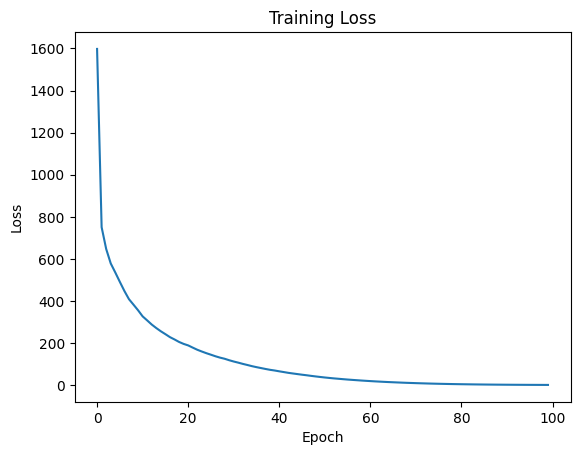

Model saved to models/RBGM/rbgm_simulated_dom1
Average Time per Epoch: 9.92s
Average CPU Usage: 8.43GB
Average Memory Usage: 9.27GB
Average GPU Usage: 0.08GB

Total Training Time: 992.23s
Max CPU Usage: 8.43GB
Max Memory Usage: 9.27GB
Max GPU Usage: 0.09GB


In [14]:
conv_size = adj_train_domain_1.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_dom1_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom1_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_dom1_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_dom1_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_dom1_model_1, rbgm_simulated_dom1_model_2, 
            adj_train_domain_1.to(device), num_epochs=100, lr=0.0001, 
            save_path="models/RBGM/rbgm_simulated_dom1")

#### Domain 2

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820



Epoch 1/100: 100%|██████████| 80/80 [00:09<00:00,  8.31it/s]


Epoch 1, Loss: 1478.9591335296632, Generative Loss: 0.4433498616330326, Topological Loss: 11828.12621498108
Time: 9.63s, CPU: 7.96GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 2/100: 100%|██████████| 80/80 [00:10<00:00,  7.99it/s]


Epoch 2, Loss: 396.5318916320801, Generative Loss: 0.24551489632576703, Topological Loss: 3170.291000366211
Time: 10.02s, CPU: 8.60GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 3/100: 100%|██████████| 80/80 [00:09<00:00,  8.57it/s]


Epoch 3, Loss: 320.7377122879028, Generative Loss: 0.2204440848901868, Topological Loss: 2564.138128757477
Time: 9.34s, CPU: 5.14GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 4/100: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Epoch 4, Loss: 288.77287034988404, Generative Loss: 0.20917584951967, Topological Loss: 2308.509566307068
Time: 9.29s, CPU: 6.58GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 5/100: 100%|██████████| 80/80 [00:10<00:00,  7.99it/s]


Epoch 5, Loss: 262.3944911956787, Generative Loss: 0.199431059602648, Topological Loss: 2097.560474395752
Time: 10.01s, CPU: 8.49GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 6/100: 100%|██████████| 80/80 [00:09<00:00,  8.53it/s]


Epoch 6, Loss: 240.71742906570435, Generative Loss: 0.19106676522642374, Topological Loss: 1924.2108926773071
Time: 9.38s, CPU: 4.76GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 7/100: 100%|██████████| 80/80 [00:09<00:00,  8.82it/s]


Epoch 7, Loss: 233.93315291404724, Generative Loss: 0.18910130052827298, Topological Loss: 1869.952416419983
Time: 9.07s, CPU: 5.23GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 8/100: 100%|██████████| 80/80 [00:09<00:00,  8.85it/s]


Epoch 8, Loss: 214.40450801849366, Generative Loss: 0.18094469043426215, Topological Loss: 1713.7885036468506
Time: 9.04s, CPU: 5.87GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 9/100: 100%|██████████| 80/80 [00:09<00:00,  8.11it/s]


Epoch 9, Loss: 196.07673835754395, Generative Loss: 0.17285983464680613, Topological Loss: 1567.2310190200806
Time: 9.86s, CPU: 7.84GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 10/100: 100%|██████████| 80/80 [00:09<00:00,  8.73it/s]


Epoch 10, Loss: 187.45799775123595, Generative Loss: 0.1693264001980424, Topological Loss: 1498.309365272522
Time: 9.17s, CPU: 4.79GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 11/100: 100%|██████████| 80/80 [00:09<00:00,  8.87it/s]


Epoch 11, Loss: 174.6184808731079, Generative Loss: 0.16330356020480394, Topological Loss: 1395.6414203643799
Time: 9.02s, CPU: 5.20GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 12/100: 100%|██████████| 80/80 [00:08<00:00,  9.06it/s]


Epoch 12, Loss: 161.918132352829, Generative Loss: 0.15698611903935672, Topological Loss: 1294.0891699790955
Time: 8.84s, CPU: 5.02GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 13/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 13, Loss: 152.70948309898375, Generative Loss: 0.15253896806389095, Topological Loss: 1220.455545425415
Time: 9.35s, CPU: 5.17GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 14/100: 100%|██████████| 80/80 [00:09<00:00,  8.27it/s]


Epoch 14, Loss: 142.26056118011473, Generative Loss: 0.1469529469963163, Topological Loss: 1136.908861398697
Time: 9.67s, CPU: 7.52GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 15/100: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Epoch 15, Loss: 134.83046300411223, Generative Loss: 0.14313031742349266, Topological Loss: 1077.4986584186554
Time: 9.30s, CPU: 5.78GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 16/100: 100%|██████████| 80/80 [00:09<00:00,  8.88it/s]


Epoch 16, Loss: 128.10218393802643, Generative Loss: 0.13947119396179913, Topological Loss: 1023.7016990184784
Time: 9.02s, CPU: 6.08GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 17/100: 100%|██████████| 80/80 [00:08<00:00,  8.99it/s]


Epoch 17, Loss: 121.37541770935059, Generative Loss: 0.13571648793295027, Topological Loss: 969.9176127910614
Time: 8.90s, CPU: 4.82GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 18/100: 100%|██████████| 80/80 [00:09<00:00,  8.47it/s]


Epoch 18, Loss: 116.42891461849213, Generative Loss: 0.1328675426542759, Topological Loss: 930.3683726787567
Time: 9.45s, CPU: 5.49GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 19/100: 100%|██████████| 80/80 [00:09<00:00,  8.75it/s]


Epoch 19, Loss: 109.85034427642822, Generative Loss: 0.12907712925225495, Topological Loss: 877.7701306343079
Time: 9.15s, CPU: 5.05GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 20/100: 100%|██████████| 80/80 [00:09<00:00,  8.46it/s]


Epoch 20, Loss: 103.78662650585174, Generative Loss: 0.12529736566357313, Topological Loss: 829.2906332015991
Time: 9.46s, CPU: 7.14GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 21/100: 100%|██████████| 80/80 [00:10<00:00,  7.38it/s]


Epoch 21, Loss: 98.63274991512299, Generative Loss: 0.12209023083560169, Topological Loss: 788.0852794647217
Time: 10.84s, CPU: 9.43GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 22/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 22, Loss: 93.64367687702179, Generative Loss: 0.11884739026427268, Topological Loss: 748.1986345052719
Time: 10.24s, CPU: 7.99GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 23/100: 100%|██████████| 80/80 [00:09<00:00,  8.01it/s]


Epoch 23, Loss: 89.72787222862243, Generative Loss: 0.11633848794735968, Topological Loss: 716.8922686576843
Time: 10.00s, CPU: 7.72GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 24/100: 100%|██████████| 80/80 [00:09<00:00,  8.03it/s]


Epoch 24, Loss: 88.4915827035904, Generative Loss: 0.11564988913014532, Topological Loss: 707.0074602365494
Time: 9.98s, CPU: 6.17GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 25/100: 100%|██████████| 80/80 [00:09<00:00,  8.09it/s]


Epoch 25, Loss: 84.31105692386627, Generative Loss: 0.11274475865066051, Topological Loss: 673.5864938497543
Time: 9.90s, CPU: 6.87GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 26/100: 100%|██████████| 80/80 [00:09<00:00,  8.44it/s]


Epoch 26, Loss: 81.29149000644684, Generative Loss: 0.11076497044414282, Topological Loss: 649.44579911232
Time: 9.48s, CPU: 6.31GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 27/100: 100%|██████████| 80/80 [00:10<00:00,  7.61it/s]


Epoch 27, Loss: 81.33199430704117, Generative Loss: 0.11092564896680415, Topological Loss: 649.7685458660126
Time: 10.52s, CPU: 8.16GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 28/100: 100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Epoch 28, Loss: 75.56264199018479, Generative Loss: 0.1065833059605211, Topological Loss: 603.6484682559967
Time: 10.48s, CPU: 9.16GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 29/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 29, Loss: 71.70045078992844, Generative Loss: 0.10381756071001291, Topological Loss: 572.7730659246445
Time: 9.35s, CPU: 6.05GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 30/100: 100%|██████████| 80/80 [00:09<00:00,  8.10it/s]


Epoch 30, Loss: 68.08132417201996, Generative Loss: 0.10100907124578953, Topological Loss: 543.8425217866898
Time: 9.88s, CPU: 6.90GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 31/100: 100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Epoch 31, Loss: 66.13568445444108, Generative Loss: 0.09959853691980243, Topological Loss: 528.2886873483658
Time: 10.33s, CPU: 8.72GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 32/100: 100%|██████████| 80/80 [00:10<00:00,  7.66it/s]


Epoch 32, Loss: 63.196407806873324, Generative Loss: 0.09720136583782732, Topological Loss: 504.79365134239197
Time: 10.45s, CPU: 9.10GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 33/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 33, Loss: 61.514934349060056, Generative Loss: 0.0960391451837495, Topological Loss: 491.351166844368
Time: 9.91s, CPU: 8.37GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 34/100: 100%|██████████| 80/80 [00:10<00:00,  7.31it/s]


Epoch 34, Loss: 58.645342564582826, Generative Loss: 0.09365844940766692, Topological Loss: 468.41347324848175
Time: 10.94s, CPU: 9.48GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 35/100: 100%|██████████| 80/80 [00:09<00:00,  8.24it/s]


Epoch 35, Loss: 56.611785399913785, Generative Loss: 0.09195731098297984, Topological Loss: 452.15862143039703
Time: 9.72s, CPU: 5.99GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 36/100: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Epoch 36, Loss: 54.59697780609131, Generative Loss: 0.09031574851833284, Topological Loss: 436.0532954931259
Time: 9.29s, CPU: 5.29GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 37/100: 100%|██████████| 80/80 [00:09<00:00,  8.62it/s]


Epoch 37, Loss: 54.19669960737228, Generative Loss: 0.09019962965976447, Topological Loss: 432.8520016670227
Time: 9.28s, CPU: 4.82GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 38/100: 100%|██████████| 80/80 [00:10<00:00,  7.73it/s]


Epoch 38, Loss: 52.17600239515305, Generative Loss: 0.0884621050907299, Topological Loss: 416.70032012462616
Time: 10.35s, CPU: 8.57GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 39/100: 100%|██████████| 80/80 [00:10<00:00,  7.34it/s]


Epoch 39, Loss: 48.074013364315036, Generative Loss: 0.08465337380766869, Topological Loss: 383.9148790836334
Time: 10.90s, CPU: 9.31GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 40/100: 100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Epoch 40, Loss: 45.92677813768387, Generative Loss: 0.08270583380945026, Topological Loss: 366.7525759935379
Time: 10.46s, CPU: 8.19GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 41/100: 100%|██████████| 80/80 [00:09<00:00,  8.39it/s]


Epoch 41, Loss: 43.61461136341095, Generative Loss: 0.08057160463649779, Topological Loss: 348.2723181247711
Time: 9.54s, CPU: 6.31GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 42/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 42, Loss: 41.93311521410942, Generative Loss: 0.0790218458045274, Topological Loss: 334.8327451944351
Time: 10.27s, CPU: 8.31GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 43/100: 100%|██████████| 80/80 [00:09<00:00,  8.11it/s]


Epoch 43, Loss: 40.38356509804726, Generative Loss: 0.07754672230221331, Topological Loss: 322.4481463432312
Time: 9.87s, CPU: 6.67GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 44/100: 100%|██████████| 80/80 [00:08<00:00,  8.93it/s]


Epoch 44, Loss: 39.189692348241806, Generative Loss: 0.07645487415138633, Topological Loss: 312.90589928627014
Time: 8.96s, CPU: 4.84GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 45/100: 100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


Epoch 45, Loss: 37.48675686120987, Generative Loss: 0.07478083912283182, Topological Loss: 299.29580849409103
Time: 10.10s, CPU: 7.55GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 46/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 46, Loss: 35.81235568523407, Generative Loss: 0.07312382895033806, Topological Loss: 285.91385465860367
Time: 9.57s, CPU: 7.78GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 47/100: 100%|██████████| 80/80 [00:09<00:00,  8.79it/s]


Epoch 47, Loss: 33.971083199977876, Generative Loss: 0.07134619054850191, Topological Loss: 271.197895526886
Time: 9.10s, CPU: 5.20GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 48/100: 100%|██████████| 80/80 [00:09<00:00,  8.72it/s]


Epoch 48, Loss: 32.90284736156464, Generative Loss: 0.07018562408629805, Topological Loss: 262.6612940430641
Time: 9.18s, CPU: 5.23GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 49/100: 100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Epoch 49, Loss: 31.182409822940826, Generative Loss: 0.06844774922356009, Topological Loss: 248.91169729828835
Time: 10.47s, CPU: 7.90GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 50/100: 100%|██████████| 80/80 [00:08<00:00,  8.95it/s]


Epoch 50, Loss: 29.951815605163574, Generative Loss: 0.06720180490519852, Topological Loss: 239.0769110918045
Time: 8.95s, CPU: 5.49GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 51/100: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]


Epoch 51, Loss: 28.730010133981704, Generative Loss: 0.06593052987009287, Topological Loss: 229.31263759732246
Time: 9.32s, CPU: 5.11GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 52/100: 100%|██████████| 80/80 [00:09<00:00,  8.76it/s]


Epoch 52, Loss: 27.626909029483794, Generative Loss: 0.06469374559819699, Topological Loss: 220.4977216720581
Time: 9.13s, CPU: 5.64GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 53/100: 100%|██████████| 80/80 [00:10<00:00,  7.94it/s]


Epoch 53, Loss: 25.475016954541207, Generative Loss: 0.0623284526867792, Topological Loss: 203.3015070259571
Time: 10.08s, CPU: 7.49GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 54/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 54, Loss: 23.549223324656488, Generative Loss: 0.060248781298287216, Topological Loss: 187.91179683804512
Time: 10.28s, CPU: 7.63GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 55/100: 100%|██████████| 80/80 [00:09<00:00,  8.28it/s]


Epoch 55, Loss: 22.569451415538786, Generative Loss: 0.05913339997641742, Topological Loss: 180.08254313468933
Time: 9.66s, CPU: 5.76GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 56/100: 100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Epoch 56, Loss: 21.574484169483185, Generative Loss: 0.058000859408639374, Topological Loss: 172.13186678290367
Time: 10.33s, CPU: 8.87GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 57/100: 100%|██████████| 80/80 [00:08<00:00,  8.91it/s]


Epoch 57, Loss: 20.579094281792642, Generative Loss: 0.05685363933444023, Topological Loss: 164.17792391777039
Time: 8.98s, CPU: 5.81GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 58/100: 100%|██████████| 80/80 [00:09<00:00,  8.32it/s]


Epoch 58, Loss: 19.922142958641054, Generative Loss: 0.05590121119748801, Topological Loss: 158.9299339056015
Time: 9.62s, CPU: 7.78GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 59/100: 100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


Epoch 59, Loss: 18.875701639056206, Generative Loss: 0.054707369417883456, Topological Loss: 150.56795424222946
Time: 10.26s, CPU: 8.25GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 60/100: 100%|██████████| 80/80 [00:09<00:00,  8.09it/s]


Epoch 60, Loss: 18.019471561908723, Generative Loss: 0.05367526686750353, Topological Loss: 143.72637048363686
Time: 9.89s, CPU: 6.67GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 61/100: 100%|██████████| 80/80 [00:08<00:00,  8.90it/s]


Epoch 61, Loss: 17.429578265547754, Generative Loss: 0.052943579689599576, Topological Loss: 139.01307767629623
Time: 8.99s, CPU: 5.29GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 62/100: 100%|██████████| 80/80 [00:08<00:00,  9.04it/s]


Epoch 62, Loss: 16.56647662818432, Generative Loss: 0.05192968780174852, Topological Loss: 132.11637526750565
Time: 8.85s, CPU: 4.87GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 63/100: 100%|██████████| 80/80 [00:09<00:00,  8.10it/s]


Epoch 63, Loss: 15.811868357658387, Generative Loss: 0.0511185486568138, Topological Loss: 126.08599787950516
Time: 9.88s, CPU: 7.72GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 64/100: 100%|██████████| 80/80 [00:10<00:00,  7.63it/s]


Epoch 64, Loss: 15.205758902430535, Generative Loss: 0.05016236098017544, Topological Loss: 121.24477228522301
Time: 10.49s, CPU: 9.31GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 65/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 65, Loss: 14.608002418279648, Generative Loss: 0.049327358952723444, Topological Loss: 116.4693998247385
Time: 10.28s, CPU: 8.72GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 66/100: 100%|██████████| 80/80 [00:09<00:00,  8.20it/s]


Epoch 66, Loss: 13.819389291107655, Generative Loss: 0.04842733406694606, Topological Loss: 110.1676951944828
Time: 9.76s, CPU: 6.61GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 67/100: 100%|██████████| 80/80 [00:09<00:00,  8.63it/s]


Epoch 67, Loss: 13.25560583472252, Generative Loss: 0.047561114723794165, Topological Loss: 105.66435714066029
Time: 9.27s, CPU: 5.61GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 68/100: 100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


Epoch 68, Loss: 12.725238510966301, Generative Loss: 0.04688960666535422, Topological Loss: 101.42679078876972
Time: 10.14s, CPU: 8.81GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 69/100: 100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


Epoch 69, Loss: 12.166570937633514, Generative Loss: 0.046041535527911036, Topological Loss: 96.96423478424549
Time: 10.31s, CPU: 7.99GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 70/100: 100%|██████████| 80/80 [00:10<00:00,  7.71it/s]


Epoch 70, Loss: 11.628320682048798, Generative Loss: 0.045315484423190354, Topological Loss: 92.6640414595604
Time: 10.38s, CPU: 7.90GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 71/100: 100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


Epoch 71, Loss: 11.19571894109249, Generative Loss: 0.044532622070983054, Topological Loss: 89.20949053764343
Time: 10.31s, CPU: 9.16GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 72/100: 100%|██████████| 80/80 [00:11<00:00,  7.13it/s]


Epoch 72, Loss: 10.603482156991959, Generative Loss: 0.04395661815069616, Topological Loss: 84.47620368003845
Time: 11.22s, CPU: 8.78GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 73/100: 100%|██████████| 80/80 [00:09<00:00,  8.24it/s]


Epoch 73, Loss: 10.244459575414657, Generative Loss: 0.04304642758797854, Topological Loss: 81.61130475997925
Time: 9.71s, CPU: 7.87GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 74/100: 100%|██████████| 80/80 [00:09<00:00,  8.11it/s]


Epoch 74, Loss: 10.094536796212196, Generative Loss: 0.04248626660555601, Topological Loss: 80.41640467941761
Time: 9.86s, CPU: 6.99GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 75/100: 100%|██████████| 80/80 [00:09<00:00,  8.84it/s]


Epoch 75, Loss: 9.321375632286072, Generative Loss: 0.04190687262453139, Topological Loss: 74.23575015366077
Time: 9.05s, CPU: 4.82GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 76/100: 100%|██████████| 80/80 [00:10<00:00,  7.67it/s]


Epoch 76, Loss: 8.963909423351287, Generative Loss: 0.04104743853677064, Topological Loss: 71.38289542496204
Time: 10.43s, CPU: 9.04GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 77/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 77, Loss: 8.534326361119748, Generative Loss: 0.040506627259310334, Topological Loss: 67.95055782794952
Time: 10.23s, CPU: 7.40GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 78/100: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


Epoch 78, Loss: 8.225626070797443, Generative Loss: 0.03975387668469921, Topological Loss: 65.4869774878025
Time: 10.17s, CPU: 6.72GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 79/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 79, Loss: 7.8105808109045025, Generative Loss: 0.039151330338791014, Topological Loss: 62.17143555730581
Time: 9.35s, CPU: 5.46GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 80/100: 100%|██████████| 80/80 [00:10<00:00,  7.81it/s]


Epoch 80, Loss: 7.424224506318569, Generative Loss: 0.0385864379699342, Topological Loss: 59.08510425686836
Time: 10.25s, CPU: 8.31GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 81/100: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Epoch 81, Loss: 7.079712410271168, Generative Loss: 0.037934378953650594, Topological Loss: 56.33422387391329
Time: 10.34s, CPU: 8.34GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 82/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 82, Loss: 6.777370205521583, Generative Loss: 0.037264314747881146, Topological Loss: 53.92084711045027
Time: 9.74s, CPU: 6.55GB, Memory: 9.27GB, GPU: 0.13GB



Epoch 83/100: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]


Epoch 83, Loss: 6.625627539306879, Generative Loss: 0.03664921636227518, Topological Loss: 52.71182657778263
Time: 9.70s, CPU: 5.46GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 84/100: 100%|██████████| 80/80 [00:09<00:00,  8.70it/s]


Epoch 84, Loss: 6.288289051502943, Generative Loss: 0.03600758842658251, Topological Loss: 50.018251933157444
Time: 9.19s, CPU: 5.02GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 85/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 85, Loss: 6.006583511084318, Generative Loss: 0.03541611742693931, Topological Loss: 47.76933877170086
Time: 9.73s, CPU: 6.96GB, Memory: 9.31GB, GPU: 0.13GB



Epoch 86/100: 100%|██████████| 80/80 [00:10<00:00,  7.77it/s]


Epoch 86, Loss: 5.686170223355293, Generative Loss: 0.03483905292814597, Topological Loss: 45.21064925938845
Time: 10.30s, CPU: 8.87GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 87/100: 100%|██████████| 80/80 [00:09<00:00,  8.09it/s]


Epoch 87, Loss: 5.40255277082324, Generative Loss: 0.03410031924722716, Topological Loss: 42.94761949777603
Time: 9.89s, CPU: 8.52GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 88/100: 100%|██████████| 80/80 [00:09<00:00,  8.32it/s]


Epoch 88, Loss: 5.255647435039282, Generative Loss: 0.033368437050376086, Topological Loss: 41.77823190391064
Time: 9.62s, CPU: 6.90GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 89/100: 100%|██████████| 80/80 [00:10<00:00,  7.30it/s]


Epoch 89, Loss: 5.020424112677574, Generative Loss: 0.03289546523010358, Topological Loss: 39.900229036808014
Time: 10.96s, CPU: 9.19GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 90/100: 100%|██████████| 80/80 [00:09<00:00,  8.57it/s]


Epoch 90, Loss: 4.755455010384321, Generative Loss: 0.03204025860177353, Topological Loss: 37.787318110466
Time: 9.35s, CPU: 5.93GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 91/100: 100%|██████████| 80/80 [00:10<00:00,  7.95it/s]


Epoch 91, Loss: 4.594195491820574, Generative Loss: 0.03157909484580159, Topological Loss: 36.50093114003539
Time: 10.07s, CPU: 9.19GB, Memory: 9.30GB, GPU: 0.13GB



Epoch 92/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 92, Loss: 4.315372277796269, Generative Loss: 0.030947368452325465, Topological Loss: 34.275399032980204
Time: 9.58s, CPU: 6.61GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 93/100: 100%|██████████| 80/80 [00:09<00:00,  8.49it/s]


Epoch 93, Loss: 4.1321345247328285, Generative Loss: 0.030340910563245414, Topological Loss: 32.81434903666377
Time: 9.43s, CPU: 6.78GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 94/100: 100%|██████████| 80/80 [00:09<00:00,  8.68it/s]


Epoch 94, Loss: 3.9557840593159197, Generative Loss: 0.029699138761498035, Topological Loss: 31.408679272979498
Time: 9.22s, CPU: 5.64GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 95/100: 100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Epoch 95, Loss: 3.7411804109811784, Generative Loss: 0.029036438523326068, Topological Loss: 29.697151586413383
Time: 10.47s, CPU: 9.57GB, Memory: 9.28GB, GPU: 0.13GB



Epoch 96/100: 100%|██████████| 80/80 [00:10<00:00,  7.60it/s]


Epoch 96, Loss: 3.641114245355129, Generative Loss: 0.02862163947429508, Topological Loss: 28.89994065091014
Time: 10.53s, CPU: 9.04GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 97/100: 100%|██████████| 80/80 [00:10<00:00,  7.30it/s]


Epoch 97, Loss: 3.465012321993709, Generative Loss: 0.02805921093095094, Topological Loss: 27.495624862611294
Time: 10.96s, CPU: 9.25GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 98/100: 100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


Epoch 98, Loss: 3.2273521583527325, Generative Loss: 0.02734644142910838, Topological Loss: 25.60004561394453
Time: 10.16s, CPU: 8.02GB, Memory: 9.32GB, GPU: 0.13GB



Epoch 99/100: 100%|██████████| 80/80 [00:09<00:00,  8.18it/s]


Epoch 99, Loss: 3.0431866344064473, Generative Loss: 0.02669251346960664, Topological Loss: 24.13195287436247
Time: 9.78s, CPU: 6.64GB, Memory: 9.29GB, GPU: 0.13GB



Epoch 100/100: 100%|██████████| 80/80 [00:09<00:00,  8.46it/s]


Epoch 100, Loss: 2.879948991909623, Generative Loss: 0.026146449008956553, Topological Loss: 22.83042035624385
Time: 9.47s, CPU: 6.93GB, Memory: 9.33GB, GPU: 0.13GB



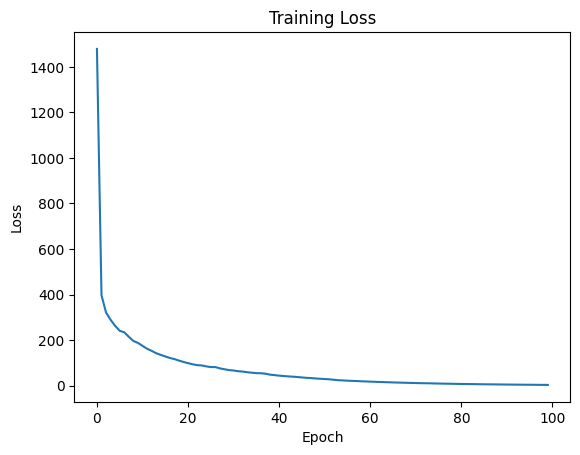

Model saved to models/RBGM/rbgm_simulated_dom2
Average Time per Epoch: 9.80s
Average CPU Usage: 6.93GB
Average Memory Usage: 9.33GB
Average GPU Usage: 0.13GB

Total Training Time: 980.24s
Max CPU Usage: 6.93GB
Max Memory Usage: 9.33GB
Max GPU Usage: 0.13GB


In [15]:
conv_size = adj_train_domain_2.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_dom2_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom2_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_dom2_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_dom2_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_dom2_model_1, rbgm_simulated_dom2_model_2, 
            adj_train_domain_2.to(device), num_epochs=100, lr=0.0001, 
            save_path="models/RBGM/rbgm_simulated_dom2")

#### Domain 3

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820



Epoch 1/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 1, Loss: 1247.7858401298522, Generative Loss: 0.4216610093601048, Topological Loss: 9978.913403511047
Time: 10.24s, CPU: 7.08GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 2/100: 100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Epoch 2, Loss: 367.19597511291505, Generative Loss: 0.2378286703489721, Topological Loss: 2935.665165901184
Time: 10.47s, CPU: 8.84GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 3/100: 100%|██████████| 80/80 [00:09<00:00,  8.20it/s]


Epoch 3, Loss: 313.4883521080017, Generative Loss: 0.2196263276040554, Topological Loss: 2506.1498050689697
Time: 9.76s, CPU: 8.31GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 4/100: 100%|██████████| 80/80 [00:09<00:00,  8.46it/s]


Epoch 4, Loss: 271.50687980651855, Generative Loss: 0.204322262853384, Topological Loss: 2170.42044878006
Time: 9.45s, CPU: 7.99GB, Memory: 9.33GB, GPU: 0.17GB



Epoch 5/100: 100%|██████████| 80/80 [00:09<00:00,  8.47it/s]


Epoch 5, Loss: 262.9745520114899, Generative Loss: 0.2013525919057429, Topological Loss: 2102.1855940818787
Time: 9.45s, CPU: 5.14GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 6/100: 100%|██████████| 80/80 [00:09<00:00,  8.75it/s]


Epoch 6, Loss: 232.27534146308898, Generative Loss: 0.1893485190346837, Topological Loss: 1856.6879420280457
Time: 9.15s, CPU: 5.55GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 7/100: 100%|██████████| 80/80 [00:09<00:00,  8.48it/s]


Epoch 7, Loss: 215.61661620140075, Generative Loss: 0.18276161225512624, Topological Loss: 1723.4708309173584
Time: 9.44s, CPU: 5.17GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 8/100: 100%|██████████| 80/80 [00:10<00:00,  7.63it/s]


Epoch 8, Loss: 198.2259166240692, Generative Loss: 0.17492569652386009, Topological Loss: 1584.4079217910767
Time: 10.49s, CPU: 8.02GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 9/100: 100%|██████████| 80/80 [00:09<00:00,  8.44it/s]


Epoch 9, Loss: 184.4155700683594, Generative Loss: 0.16916837878525257, Topological Loss: 1473.9712178707123
Time: 9.49s, CPU: 5.29GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 10/100: 100%|██████████| 80/80 [00:10<00:00,  7.78it/s]


Epoch 10, Loss: 168.92174792289734, Generative Loss: 0.16171457949094475, Topological Loss: 1350.0802652835846
Time: 10.29s, CPU: 7.40GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 11/100: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Epoch 11, Loss: 163.74874839782714, Generative Loss: 0.15976339280605317, Topological Loss: 1308.7118780612946
Time: 10.19s, CPU: 7.46GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 12/100: 100%|██████████| 80/80 [00:09<00:00,  8.06it/s]


Epoch 12, Loss: 142.2397202730179, Generative Loss: 0.14865458798594772, Topological Loss: 1136.7285208702087
Time: 9.92s, CPU: 6.90GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 13/100: 100%|██████████| 80/80 [00:09<00:00,  8.17it/s]


Epoch 13, Loss: 138.52488174438477, Generative Loss: 0.14702179050073028, Topological Loss: 1107.0228803157806
Time: 9.79s, CPU: 5.70GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 14/100: 100%|██████████| 80/80 [00:09<00:00,  8.37it/s]


Epoch 14, Loss: 124.82811071872712, Generative Loss: 0.13906626254320145, Topological Loss: 997.5123541355133
Time: 9.56s, CPU: 5.43GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 15/100: 100%|██████████| 80/80 [00:09<00:00,  8.30it/s]


Epoch 15, Loss: 121.89363279342652, Generative Loss: 0.13758855941705406, Topological Loss: 974.048356294632
Time: 9.64s, CPU: 5.23GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 16/100: 100%|██████████| 80/80 [00:08<00:00,  8.89it/s]


Epoch 16, Loss: 110.22022902965546, Generative Loss: 0.13090063584968448, Topological Loss: 880.714626789093
Time: 9.00s, CPU: 5.08GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 17/100: 100%|██████████| 80/80 [00:09<00:00,  8.75it/s]


Epoch 17, Loss: 107.89860665798187, Generative Loss: 0.12976021999493242, Topological Loss: 862.1507697105408
Time: 9.15s, CPU: 5.29GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 18/100: 100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


Epoch 18, Loss: 97.3626262664795, Generative Loss: 0.12293602330610157, Topological Loss: 777.9175176620483
Time: 10.16s, CPU: 7.87GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 19/100: 100%|██████████| 80/80 [00:09<00:00,  8.57it/s]


Epoch 19, Loss: 96.92784259319305, Generative Loss: 0.12293984307907521, Topological Loss: 774.439218044281
Time: 9.34s, CPU: 5.61GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 20/100: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]


Epoch 20, Loss: 87.06189777851105, Generative Loss: 0.1162054168060422, Topological Loss: 695.565535902977
Time: 10.55s, CPU: 8.22GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 21/100: 100%|██████████| 80/80 [00:10<00:00,  7.81it/s]


Epoch 21, Loss: 88.19229347705841, Generative Loss: 0.11696314816363156, Topological Loss: 704.6026420593262
Time: 10.25s, CPU: 7.84GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 22/100: 100%|██████████| 80/80 [00:10<00:00,  7.98it/s]


Epoch 22, Loss: 83.67168625593186, Generative Loss: 0.11380159598775208, Topological Loss: 668.4630756378174
Time: 10.03s, CPU: 7.02GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 23/100: 100%|██████████| 80/80 [00:09<00:00,  8.33it/s]


Epoch 23, Loss: 78.51550841331482, Generative Loss: 0.11039476748555899, Topological Loss: 627.2409067153931
Time: 9.61s, CPU: 6.40GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 24/100: 100%|██████████| 80/80 [00:09<00:00,  8.30it/s]


Epoch 24, Loss: 72.31448742151261, Generative Loss: 0.10574909397400915, Topological Loss: 577.6699060201645
Time: 9.65s, CPU: 6.61GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 25/100: 100%|██████████| 80/80 [00:09<00:00,  8.50it/s]


Epoch 25, Loss: 72.6684276819229, Generative Loss: 0.10627136980183423, Topological Loss: 580.4972479343414
Time: 9.41s, CPU: 5.55GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 26/100: 100%|██████████| 80/80 [00:09<00:00,  8.63it/s]


Epoch 26, Loss: 68.40953502655029, Generative Loss: 0.10282961612101645, Topological Loss: 546.4536409378052
Time: 9.28s, CPU: 4.87GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 27/100: 100%|██████████| 80/80 [00:10<00:00,  7.71it/s]


Epoch 27, Loss: 64.0734057545662, Generative Loss: 0.09939080874901265, Topological Loss: 511.79211843013763
Time: 10.37s, CPU: 7.96GB, Memory: 9.33GB, GPU: 0.17GB



Epoch 28/100: 100%|██████████| 80/80 [00:10<00:00,  7.58it/s]


Epoch 28, Loss: 61.11950788497925, Generative Loss: 0.09722500962670892, Topological Loss: 488.17826199531555
Time: 10.56s, CPU: 8.10GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 29/100: 100%|██████████| 80/80 [00:09<00:00,  8.77it/s]


Epoch 29, Loss: 61.5497151017189, Generative Loss: 0.09744980204850436, Topological Loss: 491.6181185245514
Time: 9.12s, CPU: 5.17GB, Memory: 9.33GB, GPU: 0.17GB



Epoch 30/100: 100%|██████████| 80/80 [00:10<00:00,  7.31it/s]


Epoch 30, Loss: 59.05200436115265, Generative Loss: 0.09523991879541427, Topological Loss: 471.6541170477867
Time: 10.95s, CPU: 9.13GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 31/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 31, Loss: 54.21756725311279, Generative Loss: 0.09138154843822122, Topological Loss: 433.0094857811928
Time: 9.35s, CPU: 5.64GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 32/100: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Epoch 32, Loss: 52.98082424402237, Generative Loss: 0.09025020117405802, Topological Loss: 423.1245901584625
Time: 9.25s, CPU: 4.79GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 33/100: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]


Epoch 33, Loss: 50.94538173675537, Generative Loss: 0.08844111158978193, Topological Loss: 406.85552418231964
Time: 9.33s, CPU: 5.26GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 34/100: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Epoch 34, Loss: 47.72277776002884, Generative Loss: 0.08549874816089868, Topological Loss: 381.09822940826416
Time: 9.25s, CPU: 5.20GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 35/100: 100%|██████████| 80/80 [00:09<00:00,  8.60it/s]


Epoch 35, Loss: 46.186338800191876, Generative Loss: 0.08417190369218588, Topological Loss: 368.81733548641205
Time: 9.30s, CPU: 4.93GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 36/100: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


Epoch 36, Loss: 44.52507576942444, Generative Loss: 0.08267168106976897, Topological Loss: 355.53923255205154
Time: 9.97s, CPU: 8.37GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 37/100: 100%|██████████| 80/80 [00:10<00:00,  7.67it/s]


Epoch 37, Loss: 40.98730862736702, Generative Loss: 0.07914417816791683, Topological Loss: 327.26531422138214
Time: 10.43s, CPU: 9.22GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 38/100: 100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Epoch 38, Loss: 39.84143542051315, Generative Loss: 0.07802263582125306, Topological Loss: 318.1073014140129
Time: 10.70s, CPU: 8.87GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 39/100: 100%|██████████| 80/80 [00:11<00:00,  7.21it/s]


Epoch 39, Loss: 37.85706562995911, Generative Loss: 0.07595488810911774, Topological Loss: 302.2488844394684
Time: 11.11s, CPU: 9.72GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 40/100: 100%|██████████| 80/80 [00:10<00:00,  7.37it/s]


Epoch 40, Loss: 37.08736132383346, Generative Loss: 0.07507045078091323, Topological Loss: 296.0983250141144
Time: 10.85s, CPU: 9.19GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 41/100: 100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Epoch 41, Loss: 34.55053884983063, Generative Loss: 0.07247738905716687, Topological Loss: 275.8244916200638
Time: 10.48s, CPU: 8.22GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 42/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 42, Loss: 32.666084808111194, Generative Loss: 0.0703903954476118, Topological Loss: 260.7655564546585
Time: 10.23s, CPU: 8.10GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 43/100: 100%|██████████| 80/80 [00:09<00:00,  8.51it/s]


Epoch 43, Loss: 32.356345671415326, Generative Loss: 0.07002947833389044, Topological Loss: 258.29052859544754
Time: 9.40s, CPU: 5.76GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 44/100: 100%|██████████| 80/80 [00:09<00:00,  8.71it/s]


Epoch 44, Loss: 30.673486328125, Generative Loss: 0.06816275008022785, Topological Loss: 244.84259051084518
Time: 9.19s, CPU: 5.05GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 45/100: 100%|██████████| 80/80 [00:09<00:00,  8.24it/s]


Epoch 45, Loss: 29.075639247894287, Generative Loss: 0.06641524634324014, Topological Loss: 232.0737906396389
Time: 9.71s, CPU: 5.76GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 46/100: 100%|██████████| 80/80 [00:09<00:00,  8.14it/s]


Epoch 46, Loss: 27.19157585501671, Generative Loss: 0.06411862610839307, Topological Loss: 217.0196571946144
Time: 9.83s, CPU: 6.46GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 47/100: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s]


Epoch 47, Loss: 26.38289431333542, Generative Loss: 0.06316730682738125, Topological Loss: 210.55781519412994
Time: 9.98s, CPU: 7.31GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 48/100: 100%|██████████| 80/80 [00:09<00:00,  8.34it/s]


Epoch 48, Loss: 25.54032581746578, Generative Loss: 0.06216780031099915, Topological Loss: 203.8252628147602
Time: 9.60s, CPU: 6.31GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 49/100: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Epoch 49, Loss: 24.051463305950165, Generative Loss: 0.06025332163553685, Topological Loss: 191.92967861890793
Time: 10.33s, CPU: 7.11GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 50/100: 100%|██████████| 80/80 [00:11<00:00,  7.03it/s]


Epoch 50, Loss: 22.857337030768395, Generative Loss: 0.05867844857275486, Topological Loss: 182.38926827907562
Time: 11.39s, CPU: 8.99GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 51/100: 100%|██████████| 80/80 [00:09<00:00,  8.52it/s]


Epoch 51, Loss: 22.36297692656517, Generative Loss: 0.058103403402492405, Topological Loss: 178.438988417387
Time: 9.39s, CPU: 5.20GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 52/100: 100%|██████████| 80/80 [00:10<00:00,  7.71it/s]


Epoch 52, Loss: 21.91484799683094, Generative Loss: 0.05748494698200375, Topological Loss: 174.85890406370163
Time: 10.37s, CPU: 6.93GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 53/100: 100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


Epoch 53, Loss: 20.200496610999107, Generative Loss: 0.05509429890662432, Topological Loss: 161.1632173359394
Time: 10.31s, CPU: 6.25GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 54/100: 100%|██████████| 80/80 [00:10<00:00,  7.31it/s]


Epoch 54, Loss: 19.91783861517906, Generative Loss: 0.05471754283644259, Topological Loss: 158.9049680531025
Time: 10.95s, CPU: 7.90GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 55/100: 100%|██████████| 80/80 [00:10<00:00,  7.84it/s]


Epoch 55, Loss: 19.186149060726166, Generative Loss: 0.05378262519370765, Topological Loss: 153.05893170833588
Time: 10.20s, CPU: 7.63GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 56/100: 100%|██████████| 80/80 [00:09<00:00,  8.13it/s]


Epoch 56, Loss: 18.001847544312476, Generative Loss: 0.05203240535920486, Topological Loss: 143.5985211879015
Time: 9.84s, CPU: 6.28GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 57/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 57, Loss: 16.686246752738953, Generative Loss: 0.05010573753388599, Topological Loss: 133.08912852406502
Time: 10.27s, CPU: 6.43GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 58/100: 100%|██████████| 80/80 [00:10<00:00,  7.99it/s]


Epoch 58, Loss: 16.01970692873001, Generative Loss: 0.049114313069731, Topological Loss: 127.76474119722843
Time: 10.01s, CPU: 7.93GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 59/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 59, Loss: 15.384704764187337, Generative Loss: 0.04815643291221931, Topological Loss: 122.69238656759262
Time: 10.24s, CPU: 8.66GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 60/100: 100%|██████████| 80/80 [00:09<00:00,  8.34it/s]


Epoch 60, Loss: 14.87228253930807, Generative Loss: 0.0473184467991814, Topological Loss: 118.5997122079134
Time: 9.59s, CPU: 7.05GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 61/100: 100%|██████████| 80/80 [00:09<00:00,  8.04it/s]


Epoch 61, Loss: 13.753132952749729, Generative Loss: 0.045551837526727465, Topological Loss: 109.66064830124378
Time: 9.95s, CPU: 6.75GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 62/100: 100%|██████████| 80/80 [00:09<00:00,  8.38it/s]


Epoch 62, Loss: 12.986490522325038, Generative Loss: 0.04432090820046142, Topological Loss: 103.53735594451427
Time: 9.55s, CPU: 5.17GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 63/100: 100%|██████████| 80/80 [00:09<00:00,  8.31it/s]


Epoch 63, Loss: 12.311285085976124, Generative Loss: 0.04320648827124387, Topological Loss: 98.14462910592556
Time: 9.63s, CPU: 6.49GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 64/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 64, Loss: 11.980325450003146, Generative Loss: 0.04267848418094218, Topological Loss: 95.501175776124
Time: 9.57s, CPU: 5.31GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 65/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 65, Loss: 11.257730713486671, Generative Loss: 0.04139364933362231, Topological Loss: 89.7306966111064
Time: 10.27s, CPU: 7.34GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 66/100: 100%|██████████| 80/80 [00:09<00:00,  8.06it/s]


Epoch 66, Loss: 10.758335369825364, Generative Loss: 0.040575232089031486, Topological Loss: 85.74208065867424
Time: 9.93s, CPU: 6.69GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 67/100: 100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


Epoch 67, Loss: 10.34960106164217, Generative Loss: 0.03984356948640198, Topological Loss: 82.47805950045586
Time: 10.22s, CPU: 9.04GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 68/100: 100%|██████████| 80/80 [00:09<00:00,  8.35it/s]


Epoch 68, Loss: 9.57962386906147, Generative Loss: 0.03846304679755121, Topological Loss: 76.32928638905287
Time: 9.58s, CPU: 5.52GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 69/100: 100%|██████████| 80/80 [00:09<00:00,  8.11it/s]


Epoch 69, Loss: 9.263905119895934, Generative Loss: 0.03786946702748537, Topological Loss: 73.80828493088484
Time: 9.87s, CPU: 6.69GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 70/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 70, Loss: 8.641606187820434, Generative Loss: 0.0367191968485713, Topological Loss: 68.8390957787633
Time: 9.90s, CPU: 6.25GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 71/100: 100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Epoch 71, Loss: 8.260405877232552, Generative Loss: 0.035993443732149896, Topological Loss: 65.79529963433743
Time: 10.32s, CPU: 7.58GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 72/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 72, Loss: 8.00227655172348, Generative Loss: 0.03553790614241734, Topological Loss: 63.73390877991915
Time: 9.49s, CPU: 5.20GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 73/100: 100%|██████████| 80/80 [00:10<00:00,  7.66it/s]


Epoch 73, Loss: 7.433386099338532, Generative Loss: 0.034437889500986786, Topological Loss: 59.19158583134413
Time: 10.45s, CPU: 8.49GB, Memory: 9.33GB, GPU: 0.17GB



Epoch 74/100: 100%|██████████| 80/80 [00:11<00:00,  7.08it/s]


Epoch 74, Loss: 7.096142268925905, Generative Loss: 0.033775815542321654, Topological Loss: 56.49893143773079
Time: 11.30s, CPU: 9.16GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 75/100: 100%|██████████| 80/80 [00:11<00:00,  7.04it/s]


Epoch 75, Loss: 6.671123788505793, Generative Loss: 0.03293399699032307, Topological Loss: 53.10551839321852
Time: 11.36s, CPU: 8.60GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 76/100: 100%|██████████| 80/80 [00:09<00:00,  8.60it/s]


Epoch 76, Loss: 6.215486060082912, Generative Loss: 0.03203058595536277, Topological Loss: 49.46764354035258
Time: 9.31s, CPU: 4.90GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 77/100: 100%|██████████| 80/80 [00:09<00:00,  8.07it/s]


Epoch 77, Loss: 5.8049944959580895, Generative Loss: 0.03121097747934982, Topological Loss: 46.19026827439666
Time: 9.91s, CPU: 5.23GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 78/100: 100%|██████████| 80/80 [00:10<00:00,  7.70it/s]


Epoch 78, Loss: 5.455429857969284, Generative Loss: 0.030483827576972544, Topological Loss: 43.39956810325384
Time: 10.39s, CPU: 7.93GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 79/100: 100%|██████████| 80/80 [00:09<00:00,  8.66it/s]


Epoch 79, Loss: 5.149270468950272, Generative Loss: 0.02986704893410206, Topological Loss: 40.95522728189826
Time: 9.25s, CPU: 5.78GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 80/100: 100%|██████████| 80/80 [00:10<00:00,  7.72it/s]


Epoch 80, Loss: 4.821958550810814, Generative Loss: 0.02915157451061532, Topological Loss: 38.34245566278696
Time: 10.36s, CPU: 7.61GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 81/100: 100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Epoch 81, Loss: 4.658528673276305, Generative Loss: 0.028787540225312113, Topological Loss: 37.03792894259095
Time: 10.27s, CPU: 7.52GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 82/100: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Epoch 82, Loss: 4.363579246029258, Generative Loss: 0.028164063207805158, Topological Loss: 34.68332144245505
Time: 9.25s, CPU: 5.23GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 83/100: 100%|██████████| 80/80 [00:10<00:00,  7.60it/s]


Epoch 83, Loss: 4.175389191880822, Generative Loss: 0.027748136350419374, Topological Loss: 33.18112853169441
Time: 10.54s, CPU: 9.16GB, Memory: 9.29GB, GPU: 0.17GB



Epoch 84/100: 100%|██████████| 80/80 [00:10<00:00,  7.61it/s]


Epoch 84, Loss: 3.8318424217402933, Generative Loss: 0.02702335357898846, Topological Loss: 30.438552521169186
Time: 10.52s, CPU: 8.37GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 85/100: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


Epoch 85, Loss: 3.664691445231438, Generative Loss: 0.026645994756836443, Topological Loss: 29.10436362028122
Time: 10.17s, CPU: 7.05GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 86/100: 100%|██████████| 80/80 [00:10<00:00,  7.54it/s]


Epoch 86, Loss: 3.3792900774627923, Generative Loss: 0.026009123690892012, Topological Loss: 26.82624740898609
Time: 10.62s, CPU: 8.66GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 87/100: 100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


Epoch 87, Loss: 3.2172713220119475, Generative Loss: 0.02566323846112937, Topological Loss: 25.532864656299353
Time: 10.22s, CPU: 7.28GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 88/100: 100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


Epoch 88, Loss: 3.025289362296462, Generative Loss: 0.02522261379053816, Topological Loss: 24.00053385645151
Time: 10.10s, CPU: 5.93GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 89/100: 100%|██████████| 80/80 [00:10<00:00,  7.68it/s]


Epoch 89, Loss: 2.831005449965596, Generative Loss: 0.024787956604268403, Topological Loss: 22.449739795178175
Time: 10.42s, CPU: 8.13GB, Memory: 9.28GB, GPU: 0.17GB



Epoch 90/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 90, Loss: 2.6564219515770673, Generative Loss: 0.02439361547585577, Topological Loss: 21.05622662976384
Time: 10.23s, CPU: 8.43GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 91/100: 100%|██████████| 80/80 [00:09<00:00,  8.46it/s]


Epoch 91, Loss: 2.507783493027091, Generative Loss: 0.0240232523297891, Topological Loss: 19.870081750676036
Time: 9.46s, CPU: 5.67GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 92/100: 100%|██████████| 80/80 [00:09<00:00,  8.00it/s]


Epoch 92, Loss: 2.344659583643079, Generative Loss: 0.023687518131919206, Topological Loss: 18.567776508629322
Time: 10.00s, CPU: 6.20GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 93/100: 100%|██████████| 80/80 [00:09<00:00,  8.51it/s]


Epoch 93, Loss: 2.197687676921487, Generative Loss: 0.02333552421769127, Topological Loss: 17.394817266613245
Time: 9.40s, CPU: 5.46GB, Memory: 9.30GB, GPU: 0.17GB



Epoch 94/100: 100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


Epoch 94, Loss: 2.0851284239441155, Generative Loss: 0.023070989281404764, Topological Loss: 16.496459379792213
Time: 10.11s, CPU: 6.90GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 95/100: 100%|██████████| 80/80 [00:10<00:00,  7.58it/s]


Epoch 95, Loss: 1.9508359216153621, Generative Loss: 0.022769514890387654, Topological Loss: 15.424531158059835
Time: 10.55s, CPU: 8.84GB, Memory: 9.33GB, GPU: 0.17GB



Epoch 96/100: 100%|██████████| 80/80 [00:11<00:00,  7.17it/s]


Epoch 96, Loss: 1.8530332269147038, Generative Loss: 0.022518753807526083, Topological Loss: 14.644115695729852
Time: 11.16s, CPU: 9.43GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 97/100: 100%|██████████| 80/80 [00:11<00:00,  7.27it/s]


Epoch 97, Loss: 1.7470103679224849, Generative Loss: 0.022283970459830015, Topological Loss: 13.7978111859411
Time: 11.01s, CPU: 9.51GB, Memory: 9.32GB, GPU: 0.17GB



Epoch 98/100: 100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Epoch 98, Loss: 1.6354807637631894, Generative Loss: 0.021999381552450358, Topological Loss: 12.907851045951247
Time: 10.68s, CPU: 7.72GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 99/100: 100%|██████████| 80/80 [00:10<00:00,  7.33it/s]


Epoch 99, Loss: 1.5449139328673482, Generative Loss: 0.021779204381164163, Topological Loss: 12.18507780879736
Time: 10.91s, CPU: 8.22GB, Memory: 9.31GB, GPU: 0.17GB



Epoch 100/100: 100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Epoch 100, Loss: 1.478946055844426, Generative Loss: 0.02159874652279541, Topological Loss: 11.658778565004468
Time: 10.68s, CPU: 8.28GB, Memory: 9.31GB, GPU: 0.17GB



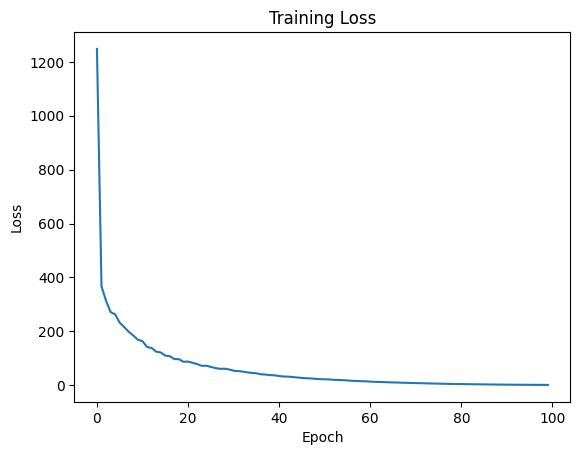

Model saved to models/RBGM/rbgm_simulated_dom3
Average Time per Epoch: 10.03s
Average CPU Usage: 8.28GB
Average Memory Usage: 9.31GB
Average GPU Usage: 0.17GB

Total Training Time: 1002.53s
Max CPU Usage: 8.28GB
Max Memory Usage: 9.31GB
Max GPU Usage: 0.17GB


In [16]:
conv_size = adj_train_domain_3.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_dom3_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom3_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_dom3_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_dom3_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_dom3_model_1, rbgm_simulated_dom3_model_2, 
            adj_train_domain_3.to(device), num_epochs=100, lr=0.0001, 
            save_path="models/RBGM/rbgm_simulated_dom3")

#### Domain 4

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820



Epoch 1/100: 100%|██████████| 80/80 [00:10<00:00,  7.63it/s]


Epoch 1, Loss: 1000.0920546531677, Generative Loss: 0.372363131120801, Topological Loss: 7997.757489204407
Time: 10.49s, CPU: 8.13GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 2/100: 100%|██████████| 80/80 [00:10<00:00,  7.81it/s]


Epoch 2, Loss: 261.42885007858274, Generative Loss: 0.20027457289397715, Topological Loss: 2089.828598499298
Time: 10.24s, CPU: 7.28GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 3/100: 100%|██████████| 80/80 [00:09<00:00,  8.39it/s]


Epoch 3, Loss: 221.86634283065797, Generative Loss: 0.1843617048114538, Topological Loss: 1773.4558472633362
Time: 9.54s, CPU: 5.31GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 4/100: 100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Epoch 4, Loss: 197.39842615127563, Generative Loss: 0.17405261429958047, Topological Loss: 1577.7949872016907
Time: 10.66s, CPU: 7.72GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 5/100: 100%|██████████| 80/80 [00:10<00:00,  7.97it/s]


Epoch 5, Loss: 182.73583989143373, Generative Loss: 0.16770022232085466, Topological Loss: 1460.5451169013977
Time: 10.04s, CPU: 6.99GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 6/100: 100%|██████████| 80/80 [00:09<00:00,  8.28it/s]


Epoch 6, Loss: 168.07081050872802, Generative Loss: 0.16099736108444632, Topological Loss: 1343.278504371643
Time: 9.67s, CPU: 5.52GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 7/100: 100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Epoch 7, Loss: 156.8663345336914, Generative Loss: 0.155470658140257, Topological Loss: 1253.6869041919708
Time: 10.33s, CPU: 8.05GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 8/100: 100%|██████████| 80/80 [00:10<00:00,  7.28it/s]


Epoch 8, Loss: 143.3587751865387, Generative Loss: 0.14873410840518772, Topological Loss: 1145.680320739746
Time: 11.00s, CPU: 9.51GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 9/100: 100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Epoch 9, Loss: 129.64161002635956, Generative Loss: 0.14144894597120583, Topological Loss: 1036.0012829303741
Time: 10.64s, CPU: 9.04GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 10/100: 100%|██████████| 80/80 [00:10<00:00,  7.43it/s]


Epoch 10, Loss: 128.80869300365447, Generative Loss: 0.14122994798235594, Topological Loss: 1029.3397026062012
Time: 10.77s, CPU: 8.31GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 11/100: 100%|██████████| 80/80 [00:09<00:00,  8.45it/s]


Epoch 11, Loss: 118.26628239154816, Generative Loss: 0.1352126641664654, Topological Loss: 945.0485548973083
Time: 9.47s, CPU: 5.31GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 12/100: 100%|██████████| 80/80 [00:09<00:00,  8.75it/s]


Epoch 12, Loss: 108.3848785161972, Generative Loss: 0.12946037338115274, Topological Loss: 866.0433435440063
Time: 9.14s, CPU: 5.17GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 13/100: 100%|██████████| 80/80 [00:10<00:00,  7.39it/s]


Epoch 13, Loss: 103.08428752422333, Generative Loss: 0.126283928565681, Topological Loss: 823.6640295982361
Time: 10.83s, CPU: 8.13GB, Memory: 9.35GB, GPU: 0.22GB



Epoch 14/100: 100%|██████████| 80/80 [00:10<00:00,  7.97it/s]


Epoch 14, Loss: 101.22034134864808, Generative Loss: 0.12522022072225808, Topological Loss: 808.7609660625458
Time: 10.04s, CPU: 8.02GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 15/100: 100%|██████████| 80/80 [00:10<00:00,  7.40it/s]


Epoch 15, Loss: 92.6659152507782, Generative Loss: 0.11970141278579831, Topological Loss: 740.3697082996368
Time: 10.82s, CPU: 8.16GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 16/100: 100%|██████████| 80/80 [00:10<00:00,  7.46it/s]


Epoch 16, Loss: 85.45217547416686, Generative Loss: 0.11486031715758145, Topological Loss: 682.698520898819
Time: 10.72s, CPU: 9.13GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 17/100: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]


Epoch 17, Loss: 77.86355063915252, Generative Loss: 0.10963411848060786, Topological Loss: 622.0313280820847
Time: 10.54s, CPU: 8.69GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 18/100: 100%|██████████| 80/80 [00:09<00:00,  8.52it/s]


Epoch 18, Loss: 76.12939697504044, Generative Loss: 0.10843545692041516, Topological Loss: 608.167692065239
Time: 9.39s, CPU: 4.87GB, Memory: 9.34GB, GPU: 0.22GB



Epoch 19/100: 100%|██████████| 80/80 [00:11<00:00,  7.23it/s]


Epoch 19, Loss: 73.51891521215438, Generative Loss: 0.10650594495236873, Topological Loss: 587.2992765903473
Time: 11.07s, CPU: 9.31GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 20/100: 100%|██████████| 80/80 [00:11<00:00,  7.20it/s]


Epoch 20, Loss: 69.0879967212677, Generative Loss: 0.10332564851269126, Topological Loss: 551.8773670196533
Time: 11.11s, CPU: 9.57GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 21/100: 100%|██████████| 80/80 [00:10<00:00,  7.34it/s]


Epoch 21, Loss: 65.94598100185394, Generative Loss: 0.10088974093087018, Topological Loss: 526.7607260942459
Time: 10.90s, CPU: 8.49GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 22/100: 100%|██████████| 80/80 [00:09<00:00,  8.16it/s]


Epoch 22, Loss: 63.36466827392578, Generative Loss: 0.09885627892799675, Topological Loss: 506.1264947652817
Time: 9.81s, CPU: 5.34GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 23/100: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]


Epoch 23, Loss: 59.26734757423401, Generative Loss: 0.09557411456480622, Topological Loss: 473.3741855621338
Time: 10.54s, CPU: 7.81GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 24/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 24, Loss: 55.7491415143013, Generative Loss: 0.09256643736734986, Topological Loss: 445.2525991201401
Time: 9.91s, CPU: 8.13GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 25/100: 100%|██████████| 80/80 [00:09<00:00,  8.47it/s]


Epoch 25, Loss: 53.73335994482041, Generative Loss: 0.09088796384166926, Topological Loss: 429.13977682590485
Time: 9.45s, CPU: 5.58GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 26/100: 100%|██████████| 80/80 [00:09<00:00,  8.50it/s]


Epoch 26, Loss: 51.75489047765732, Generative Loss: 0.08908435804769396, Topological Loss: 413.3264489173889
Time: 9.42s, CPU: 6.28GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 27/100: 100%|██████████| 80/80 [00:11<00:00,  7.05it/s]


Epoch 27, Loss: 50.32652146816254, Generative Loss: 0.08780613029375672, Topological Loss: 401.9097235798836
Time: 11.36s, CPU: 9.07GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 28/100: 100%|██████████| 80/80 [00:10<00:00,  7.30it/s]


Epoch 28, Loss: 46.309434223175046, Generative Loss: 0.08411093633621931, Topological Loss: 369.80258470773697
Time: 10.96s, CPU: 8.54GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 29/100: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


Epoch 29, Loss: 45.03685051202774, Generative Loss: 0.0829503508284688, Topological Loss: 359.63120061159134
Time: 10.17s, CPU: 7.72GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 30/100: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]


Epoch 30, Loss: 44.33142017126083, Generative Loss: 0.082374727842398, Topological Loss: 353.9923624396324
Time: 9.32s, CPU: 4.90GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 31/100: 100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


Epoch 31, Loss: 42.27213144302368, Generative Loss: 0.0802951039513573, Topological Loss: 337.5346895456314
Time: 10.14s, CPU: 7.63GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 32/100: 100%|██████████| 80/80 [00:11<00:00,  6.86it/s]


Epoch 32, Loss: 41.70532646179199, Generative Loss: 0.0797627780586481, Topological Loss: 333.00450682640076
Time: 11.67s, CPU: 9.63GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 33/100: 100%|██████████| 80/80 [00:11<00:00,  7.08it/s]


Epoch 33, Loss: 39.13212704062462, Generative Loss: 0.07723723242525012, Topological Loss: 312.4391172528267
Time: 11.30s, CPU: 9.22GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 34/100: 100%|██████████| 80/80 [00:11<00:00,  6.99it/s]


Epoch 34, Loss: 38.70812309980393, Generative Loss: 0.07682482730597258, Topological Loss: 309.05038726329803
Time: 11.45s, CPU: 9.07GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 35/100: 100%|██████████| 80/80 [00:09<00:00,  8.32it/s]


Epoch 35, Loss: 37.5137837946415, Generative Loss: 0.07561804694123567, Topological Loss: 299.5053254365921
Time: 9.62s, CPU: 5.20GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 36/100: 100%|██████████| 80/80 [00:09<00:00,  8.74it/s]


Epoch 36, Loss: 34.772430473566054, Generative Loss: 0.07259967108257115, Topological Loss: 277.59864515066147
Time: 9.16s, CPU: 5.64GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 37/100: 100%|██████████| 80/80 [00:09<00:00,  8.79it/s]


Epoch 37, Loss: 35.30915458202362, Generative Loss: 0.07320083987433464, Topological Loss: 281.88762933015823
Time: 9.10s, CPU: 5.29GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 38/100: 100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Epoch 38, Loss: 33.21994210481644, Generative Loss: 0.07093494946602732, Topological Loss: 265.1920567750931
Time: 10.63s, CPU: 8.07GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 39/100: 100%|██████████| 80/80 [00:09<00:00,  8.20it/s]


Epoch 39, Loss: 30.841092109680176, Generative Loss: 0.06827077735215425, Topological Loss: 246.18256843090057
Time: 9.75s, CPU: 5.64GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 40/100: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]


Epoch 40, Loss: 30.582639849185945, Generative Loss: 0.06803363098297269, Topological Loss: 244.1168487071991
Time: 10.54s, CPU: 7.81GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 41/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 41, Loss: 28.568197429180145, Generative Loss: 0.06561116920784116, Topological Loss: 228.02069011330605
Time: 9.73s, CPU: 6.46GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 42/100: 100%|██████████| 80/80 [00:10<00:00,  7.56it/s]


Epoch 42, Loss: 27.20241515636444, Generative Loss: 0.06398445314262062, Topological Loss: 217.10744634270668
Time: 10.59s, CPU: 8.10GB, Memory: 9.29GB, GPU: 0.22GB



Epoch 43/100: 100%|██████████| 80/80 [00:09<00:00,  8.60it/s]


Epoch 43, Loss: 26.31561695933342, Generative Loss: 0.06291805987711996, Topological Loss: 210.02159076929092
Time: 9.30s, CPU: 5.43GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 44/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 44, Loss: 25.647071981430052, Generative Loss: 0.06211924687959254, Topological Loss: 204.67962169647217
Time: 9.57s, CPU: 6.20GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 45/100: 100%|██████████| 80/80 [00:10<00:00,  7.46it/s]


Epoch 45, Loss: 24.780298173427582, Generative Loss: 0.06103189764544368, Topological Loss: 197.75412932038307
Time: 10.72s, CPU: 8.28GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 46/100: 100%|██████████| 80/80 [00:09<00:00,  8.17it/s]


Epoch 46, Loss: 24.81285578906536, Generative Loss: 0.06109459169674665, Topological Loss: 198.0140904188156
Time: 9.79s, CPU: 6.72GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 47/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 47, Loss: 23.37223302125931, Generative Loss: 0.05927184459287673, Topological Loss: 186.50368875265121
Time: 9.50s, CPU: 6.34GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 48/100: 100%|██████████| 80/80 [00:09<00:00,  8.80it/s]


Epoch 48, Loss: 23.29589959681034, Generative Loss: 0.05919169259723276, Topological Loss: 185.89366218447685
Time: 9.10s, CPU: 5.46GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 49/100: 100%|██████████| 80/80 [00:08<00:00,  8.92it/s]


Epoch 49, Loss: 21.56100119650364, Generative Loss: 0.05689534367993474, Topological Loss: 172.0328460931778
Time: 8.97s, CPU: 4.82GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 50/100: 100%|██████████| 80/80 [00:09<00:00,  8.09it/s]


Epoch 50, Loss: 20.379185301065444, Generative Loss: 0.05526934725930914, Topological Loss: 162.59132707118988
Time: 9.89s, CPU: 7.11GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 51/100: 100%|██████████| 80/80 [00:09<00:00,  8.23it/s]


Epoch 51, Loss: 19.85288422703743, Generative Loss: 0.05453724078834057, Topological Loss: 158.3867755830288
Time: 9.72s, CPU: 6.64GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 52/100: 100%|██████████| 80/80 [00:10<00:00,  7.41it/s]


Epoch 52, Loss: 19.177601689100264, Generative Loss: 0.05363766592927277, Topological Loss: 152.99171224236488
Time: 10.80s, CPU: 8.87GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 53/100: 100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Epoch 53, Loss: 18.215924513339996, Generative Loss: 0.052272130153141916, Topological Loss: 145.30921874940395
Time: 10.33s, CPU: 9.22GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 54/100: 100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Epoch 54, Loss: 17.39643737077713, Generative Loss: 0.05102889877744019, Topological Loss: 138.76326805353165
Time: 10.23s, CPU: 7.61GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 55/100: 100%|██████████| 80/80 [00:10<00:00,  7.84it/s]


Epoch 55, Loss: 17.267148771882056, Generative Loss: 0.05088372189784422, Topological Loss: 137.73012000322342
Time: 10.21s, CPU: 8.31GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 56/100: 100%|██████████| 80/80 [00:09<00:00,  8.11it/s]


Epoch 56, Loss: 16.092112129926683, Generative Loss: 0.049083718284964564, Topological Loss: 128.34422680735588
Time: 9.87s, CPU: 6.37GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 57/100: 100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Epoch 57, Loss: 15.750780287384988, Generative Loss: 0.04856424351455644, Topological Loss: 125.61772854626179
Time: 10.47s, CPU: 8.40GB, Memory: 9.30GB, GPU: 0.22GB



Epoch 58/100: 100%|██████████| 80/80 [00:09<00:00,  8.15it/s]


Epoch 58, Loss: 15.120674346387386, Generative Loss: 0.04758775245863944, Topological Loss: 120.58469249308109
Time: 9.82s, CPU: 7.05GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 59/100: 100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Epoch 59, Loss: 14.066445179283619, Generative Loss: 0.04593383073806763, Topological Loss: 112.16409029066563
Time: 10.66s, CPU: 8.87GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 60/100: 100%|██████████| 80/80 [00:10<00:00,  7.43it/s]


Epoch 60, Loss: 13.214824014902115, Generative Loss: 0.044541125383693723, Topological Loss: 105.36226274073124
Time: 10.77s, CPU: 9.40GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 61/100: 100%|██████████| 80/80 [00:10<00:00,  7.35it/s]


Epoch 61, Loss: 12.768603570759296, Generative Loss: 0.04383751784916967, Topological Loss: 101.79812856018543
Time: 10.89s, CPU: 9.72GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 62/100: 100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


Epoch 62, Loss: 12.083441814780235, Generative Loss: 0.042680988321080804, Topological Loss: 96.32608661055565
Time: 10.18s, CPU: 6.28GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 63/100: 100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


Epoch 63, Loss: 11.863809366524219, Generative Loss: 0.04232066200347617, Topological Loss: 94.57190950214863
Time: 10.17s, CPU: 7.66GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 64/100: 100%|██████████| 80/80 [00:10<00:00,  7.99it/s]


Epoch 64, Loss: 11.777325397729873, Generative Loss: 0.042107625189237295, Topological Loss: 93.88174244761467
Time: 10.01s, CPU: 8.72GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 65/100: 100%|██████████| 80/80 [00:10<00:00,  7.77it/s]


Epoch 65, Loss: 10.82724912762642, Generative Loss: 0.040499539708253, Topological Loss: 86.29399700462818
Time: 10.29s, CPU: 8.40GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 66/100: 100%|██████████| 80/80 [00:09<00:00,  8.04it/s]


Epoch 66, Loss: 10.129275040328503, Generative Loss: 0.039275462774094196, Topological Loss: 80.71999643743038
Time: 9.95s, CPU: 8.10GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 67/100: 100%|██████████| 80/80 [00:09<00:00,  8.41it/s]


Epoch 67, Loss: 9.687063182890416, Generative Loss: 0.03848821965511888, Topological Loss: 77.18859983235598
Time: 9.51s, CPU: 6.34GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 68/100: 100%|██████████| 80/80 [00:09<00:00,  8.33it/s]


Epoch 68, Loss: 9.570763814449311, Generative Loss: 0.03824991201981902, Topological Loss: 76.26011097431183
Time: 9.60s, CPU: 7.43GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 69/100: 100%|██████████| 80/80 [00:10<00:00,  8.00it/s]


Epoch 69, Loss: 9.406172141432762, Generative Loss: 0.037954167230054736, Topological Loss: 74.94574384391308
Time: 10.01s, CPU: 6.72GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 70/100: 100%|██████████| 80/80 [00:09<00:00,  8.17it/s]


Epoch 70, Loss: 9.098300749063492, Generative Loss: 0.03738838008139282, Topological Loss: 72.4872986227274
Time: 9.80s, CPU: 8.34GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 71/100: 100%|██████████| 80/80 [00:10<00:00,  7.46it/s]


Epoch 71, Loss: 8.385063788294792, Generative Loss: 0.036040221666917206, Topological Loss: 66.79218851774931
Time: 10.73s, CPU: 9.07GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 72/100: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Epoch 72, Loss: 7.969264025241136, Generative Loss: 0.035251035063993186, Topological Loss: 63.47210372239351
Time: 10.33s, CPU: 8.72GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 73/100: 100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


Epoch 73, Loss: 7.824019347876311, Generative Loss: 0.03497750977985561, Topological Loss: 62.312334306538105
Time: 9.90s, CPU: 7.78GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 74/100: 100%|██████████| 80/80 [00:09<00:00,  8.62it/s]


Epoch 74, Loss: 7.080716376751662, Generative Loss: 0.03350110958563164, Topological Loss: 56.37772210687399
Time: 9.28s, CPU: 5.14GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 75/100: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Epoch 75, Loss: 6.733772537857294, Generative Loss: 0.032819613197352736, Topological Loss: 53.60762310773134
Time: 9.25s, CPU: 5.37GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 76/100: 100%|██████████| 80/80 [00:10<00:00,  7.54it/s]


Epoch 76, Loss: 6.545246052742004, Generative Loss: 0.03241911951918155, Topological Loss: 52.102615498006344
Time: 10.62s, CPU: 9.22GB, Memory: 9.30GB, GPU: 0.22GB



Epoch 77/100: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]


Epoch 77, Loss: 6.286900754272938, Generative Loss: 0.031894400028977546, Topological Loss: 50.04005064815283
Time: 10.55s, CPU: 9.16GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 78/100: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Epoch 78, Loss: 5.6846705883741375, Generative Loss: 0.030643701110966502, Topological Loss: 45.23221505433321
Time: 9.30s, CPU: 5.76GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 79/100: 100%|██████████| 80/80 [00:09<00:00,  8.51it/s]


Epoch 79, Loss: 5.401678072661161, Generative Loss: 0.03004440088989213, Topological Loss: 42.973069097846746
Time: 9.41s, CPU: 6.61GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 80/100: 100%|██████████| 80/80 [00:09<00:00,  8.13it/s]


Epoch 80, Loss: 5.24375581368804, Generative Loss: 0.02968622193438932, Topological Loss: 41.712556667625904
Time: 9.85s, CPU: 6.93GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 81/100: 100%|██████████| 80/80 [00:09<00:00,  8.15it/s]


Epoch 81, Loss: 4.9345882486552, Generative Loss: 0.029036766418721528, Topological Loss: 39.2444116845727
Time: 9.82s, CPU: 7.78GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 82/100: 100%|██████████| 80/80 [00:10<00:00,  7.56it/s]


Epoch 82, Loss: 4.721676444634795, Generative Loss: 0.02859929334372282, Topological Loss: 37.5446169860661
Time: 10.58s, CPU: 9.16GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 83/100: 100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Epoch 83, Loss: 4.450306168571115, Generative Loss: 0.02797706431010738, Topological Loss: 35.37863285839558
Time: 10.47s, CPU: 8.87GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 84/100: 100%|██████████| 80/80 [00:09<00:00,  8.05it/s]


Epoch 84, Loss: 4.311155806109309, Generative Loss: 0.02767114562448114, Topological Loss: 34.26787718012929
Time: 9.94s, CPU: 7.49GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 85/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 85, Loss: 3.9943170618265866, Generative Loss: 0.026950189226772635, Topological Loss: 31.738934844732285
Time: 9.50s, CPU: 6.37GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 86/100: 100%|██████████| 80/80 [00:09<00:00,  8.71it/s]


Epoch 86, Loss: 3.836664489284158, Generative Loss: 0.02662693173624575, Topological Loss: 30.480300463736057
Time: 9.18s, CPU: 6.14GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 87/100: 100%|██████████| 80/80 [00:09<00:00,  8.27it/s]


Epoch 87, Loss: 3.6584815487265585, Generative Loss: 0.026221627567429094, Topological Loss: 29.05807952210307
Time: 9.68s, CPU: 7.16GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 88/100: 100%|██████████| 80/80 [00:09<00:00,  8.40it/s]


Epoch 88, Loss: 3.453835007920861, Generative Loss: 0.025755891448352487, Topological Loss: 27.424632988870144
Time: 9.52s, CPU: 5.43GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 89/100: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Epoch 89, Loss: 3.2676745653152466, Generative Loss: 0.025310505682136865, Topological Loss: 25.938912320882082
Time: 10.34s, CPU: 8.13GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 90/100: 100%|██████████| 80/80 [00:10<00:00,  7.39it/s]


Epoch 90, Loss: 3.2010802146047355, Generative Loss: 0.025136652565561236, Topological Loss: 25.407548462972045
Time: 10.82s, CPU: 9.40GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 91/100: 100%|██████████| 80/80 [00:09<00:00,  8.23it/s]


Epoch 91, Loss: 2.976476075872779, Generative Loss: 0.024618137907236815, Topological Loss: 23.614863516762853
Time: 9.72s, CPU: 7.43GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 92/100: 100%|██████████| 80/80 [00:09<00:00,  8.55it/s]


Epoch 92, Loss: 2.8828067921102045, Generative Loss: 0.024408290174324065, Topological Loss: 22.867187989875674
Time: 9.36s, CPU: 5.02GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 93/100: 100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


Epoch 93, Loss: 2.6927199184894564, Generative Loss: 0.02394879248458892, Topological Loss: 21.350168934091926
Time: 10.10s, CPU: 7.02GB, Memory: 9.30GB, GPU: 0.22GB



Epoch 94/100: 100%|██████████| 80/80 [00:10<00:00,  7.59it/s]


Epoch 94, Loss: 2.533095299452543, Generative Loss: 0.023536323709413408, Topological Loss: 20.076471792533994
Time: 10.54s, CPU: 8.31GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 95/100: 100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


Epoch 95, Loss: 2.4076718939468265, Generative Loss: 0.023254401166923344, Topological Loss: 19.075339872390032
Time: 10.11s, CPU: 7.75GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 96/100: 100%|██████████| 80/80 [00:09<00:00,  8.01it/s]


Epoch 96, Loss: 2.4171270448714495, Generative Loss: 0.02326998332282528, Topological Loss: 19.150856530293822
Time: 9.99s, CPU: 7.43GB, Memory: 9.30GB, GPU: 0.22GB



Epoch 97/100: 100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Epoch 97, Loss: 2.1723629001528026, Generative Loss: 0.022626178769860415, Topological Loss: 17.197893802076578
Time: 10.34s, CPU: 6.23GB, Memory: 9.31GB, GPU: 0.22GB



Epoch 98/100: 100%|██████████| 80/80 [00:09<00:00,  8.20it/s]


Epoch 98, Loss: 2.0692772708833216, Generative Loss: 0.022402609628625215, Topological Loss: 16.374997302889824
Time: 9.75s, CPU: 6.40GB, Memory: 9.33GB, GPU: 0.22GB



Epoch 99/100: 100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


Epoch 99, Loss: 1.942681548371911, Generative Loss: 0.02203941954066977, Topological Loss: 15.36513695307076
Time: 10.13s, CPU: 7.55GB, Memory: 9.32GB, GPU: 0.22GB



Epoch 100/100: 100%|██████████| 80/80 [00:09<00:00,  8.47it/s]


Epoch 100, Loss: 1.8700254160910845, Generative Loss: 0.021935913397464903, Topological Loss: 14.784715933725238
Time: 9.45s, CPU: 6.52GB, Memory: 9.33GB, GPU: 0.22GB



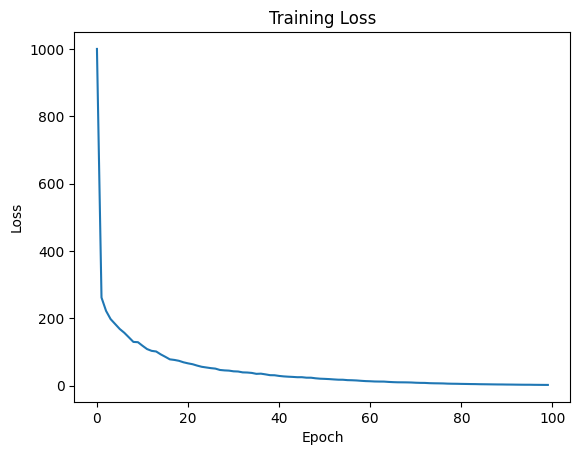

Model saved to models/RBGM/rbgm_simulated_dom4
Average Time per Epoch: 10.11s
Average CPU Usage: 6.52GB
Average Memory Usage: 9.33GB
Average GPU Usage: 0.22GB

Total Training Time: 1010.75s
Max CPU Usage: 6.52GB
Max Memory Usage: 9.33GB
Max GPU Usage: 0.22GB


In [17]:
conv_size = adj_train_domain_4.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_dom4_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom4_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_dom2_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_dom4_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_dom4_model_1, rbgm_simulated_dom4_model_2, 
            adj_train_domain_4.to(device), num_epochs=100, lr=0.0001, 
            save_path="models/RBGM/rbgm_simulated_dom4")

### SLIM Dataset

In [20]:
conv_size = adj_train_slim160.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_slim160_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_slim160_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_slim160_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_slim160_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_slim160_model_1, rbgm_simulated_slim160_model_2, 
            adj_train_slim160, num_epochs=200, lr=0.0001, 
            save_path="models/RBGM/rbgm_slim160")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.89 GiB of which 582.69 MiB is free. Process 3248824 has 15.32 GiB memory in use. Of the allocated memory 12.47 GiB is allocated by PyTorch, and 2.25 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
conv_size = adj_train_slim268.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_slim268_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_slim268_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_slim268_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_slim268_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_simulated_slim268_model_1, rbgm_simulated_slim160_model_2, 
            adj_train_slim268, num_epochs=200, lr=0.0001, 
            save_path="models/RBGM/rbgm_slim160")

## EvoGraph Net

In [13]:
class EvoGenerator(nn.Module):
    def __init__(self, conv_size, hidden_size):
        super(EvoGenerator, self).__init__()
        self.conv_size = conv_size
        self.hidden_size = hidden_size

        lin = Sequential(Linear(1, self.hidden_size), ReLU())
        self.conv1 = NNConv(self.conv_size, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(1, self.conv_size), ReLU())
        self.conv2 = NNConv(self.conv_size, 1, lin, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(1, self.conv_size), ReLU())
        self.conv3 = NNConv(1, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv33 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x1 = torch.sigmoid(self.conv11(self.conv1(x, edge_index, edge_attr)))
        x1 = F.dropout(x1, training=self.training)
        
        x1 = (x1 + x1.T) / 2.0
        x1.fill_diagonal_(fill_value=0)
        x2 = torch.sigmoid(self.conv22(self.conv2(x1, edge_index, edge_attr)))
        x2 = F.dropout(x2, training=self.training)

        x3 = torch.cat([torch.sigmoid(self.conv33(self.conv3(x2, edge_index, edge_attr))), x1], dim=1)
        x4 = x3[:, 0:self.conv_size]
        x5 = x3[:, self.conv_size:self.conv_size*2]

        x6 = (x4 + x5) / 2
        x6 = (x6 + x6.T) / 2.0
        x6.fill_diagonal_(fill_value=0)
        return x6
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class EvoDiscriminator(nn.Module):
    def __init__(self, conv_size, hidden_size):
        super(EvoDiscriminator, self).__init__()
        self.conv_size = conv_size
        self.hidden_size = hidden_size
        
        lin = Sequential(Linear(2, self.hidden_size), ReLU())
        self.conv1 = NNConv(self.conv_size, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(2, self.conv_size), ReLU())
        self.conv2 = NNConv(self.conv_size, 1, lin, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, data, data_to_translate):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr_data_to_translate = data_to_translate.edge_attr

        edge_attr_data_to_translate_reshaped = edge_attr_data_to_translate.view(self.hidden_size, 1)

        gen_input = torch.cat((edge_attr, edge_attr_data_to_translate_reshaped), -1)
        x = F.relu(self.conv11(self.conv1(x, edge_index, gen_input)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv22(self.conv2(x, edge_index, gen_input)))

        return torch.sigmoid(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [14]:
def train_evograph(generator_1, discriminator_1, generator_2, discriminator_2, train_adj, 
                    num_epochs=500, lr_g=0.01, lr_d=0.0002, save_path='models/EvoGraph/evograph_model', 
                    tp_c=0.00, g_c=2.0, i_c=2.0,kl_c=0.001):
    
    adversarial_loss= torch.nn.BCELoss().to(device)
    identity_loss   = torch.nn.L1Loss().to(device)  # Will be used in training
    msel            = torch.nn.MSELoss().to(device)
    mael            = torch.nn.L1Loss().to(device)  # Not to be used in training (Measure generator success)
    tp              = torch.nn.MSELoss().to(device) # Used for node strength

    i_coeff = 2.0
    g_coeff = 2.0
    kl_coeff = 0.001
    tp_coeff = 0.0

    num_nodes = train_adj.shape[2]
    optimizer_G1 = torch.optim.AdamW(generator_1.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_D1 = torch.optim.AdamW(discriminator_1.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_G2 = torch.optim.AdamW(generator_2.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_D2 = torch.optim.AdamW(discriminator_2.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=0.0)

    total_step = train_adj.shape[0]
    data_size = total_step
    
    real_label = torch.ones(num_nodes, 1).to(device)
    fake_label = torch.zeros(num_nodes, 1).to(device)

    real_losses1, fake_losses1, mse_losses1, mae_losses1 = list(), list(), list(), list()
    real_losses2, fake_losses2, mse_losses2, mae_losses2 = list(), list(), list(), list()

    k1_losses, k2_losses = list(), list()
    tp_losses_1_tr,  tp_losses_2_tr  = list(), list()
    gan_losses_1_tr, gan_losses_2_tr = list(), list()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []
    gpu_usage = []

    d_loss = []
    g_loss = []

    for epoch in range(num_epochs):
        # Reporting
        r1, f1, d1, g1, mse_l1, mae_l1 = 0, 0, 0, 0, 0, 0
        r2, f2, d2, g2, mse_l2, mae_l2 = 0, 0, 0, 0, 0, 0
        k1_train, k2_train  = 0.0, 0.0
        tp1_tr, tp2_tr      = 0.0, 0.0
        gan1_tr, gan2_tr    = 0.0, 0.0

        # Train
        generator_1.train()
        discriminator_1.train()
        generator_2.train()
        discriminator_2.train()

        epoch_start_time = time.time()

        for i in tqdm(range(data_size), desc=f'Epoch {epoch+1}/{num_epochs}'):
            data = train_adj.to(device)
            
            edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(data[i, 0])
            data_t0 = Data(x=data[i, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
            edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(data[i, 1])
            data_t1 = Data(x=data[i, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
            edge_idx_t2, edge_att_t2, _, _ = create_edge_index_attribute(data[i, 2])
            data_t2 = Data(x=data[i, 2], edge_attr=edge_att_t2, edge_index=edge_idx_t2).to(device)
            
            ########################################################################################
            ################################### 1st Part Training ##################################
            ########################################################################################
            # Train the discriminator
            optimizer_D1.zero_grad()
            fake_t1 = generator_1(data_t0).detach()
            edge_idx_f1, edge_att_f1, _, _ = create_edge_index_attribute(fake_t1)
            fake_data_t1 = Data(x=fake_t1, edge_attr=edge_att_f1, edge_index=edge_idx_f1).to(device)

            # data      : Real source and real target
            # fake_data : Real source and generated target
            real_loss_1 = adversarial_loss(discriminator_1(data_t1, data_t0), real_label)
            fake_loss_1 = adversarial_loss(discriminator_1(fake_data_t1, data_t0), fake_label)
            loss_D1 = torch.mean(real_loss_1 + fake_loss_1) / 2
            r1 += real_loss_1.item()
            f1 += fake_loss_1.item()
            d1 += loss_D1.item()

            loss_D1.backward(retain_graph=True)
            optimizer_D1.step()


            # Train the generator
            optimizer_G1.zero_grad()

            # Adversarial Loss
            fake_data_t1.x = generator_1(data_t0)
            gan_loss_1 = torch.mean(adversarial_loss(discriminator_1(fake_data_t1, data_t0), real_label))
            gan1_tr += gan_loss_1.item()

            # KL Loss
            kl_loss_1 = kl.kl_divergence(normal.Normal(fake_data_t1.x.mean(dim=1), fake_data_t1.x.std(dim=1)),
                                       normal.Normal(data_t1.x.mean(dim=1), data_t1.x.std(dim=1))).sum()

            # Topology Loss
            tp_loss_1 = tp(fake_data_t1.x.sum(dim=-1), data_t0.x.sum(dim=-1))
            tp1_tr += tp_loss_1.item()

            # Identity Loss is included in the end
            swapped_data = generator_1(data_t1)
            # print(f'swapped_data shape: {swapped_data.shape}, swapped_data type: {type(swapped_data)}')
            loss_G1 = (i_coeff * identity_loss(generator_1(data_t1), data_t1.x)) + (g_coeff * gan_loss_1) + (kl_coeff * kl_loss_1) + (tp_coeff * tp_loss_1)
            g1 += loss_G1.item()
            
            loss_G1.backward(retain_graph=True)
            optimizer_G1.step()
            
            k1_train += kl_loss_1.item()
            mse_l1 += msel(generator_1(data_t0), data_t1.x).item()
            mae_l1 += mael(generator_1(data_t0), data_t1.x).item()

            ########################################################################################
            ################################### 2nd Part Training ##################################
            ########################################################################################
            # Train the discriminator
            optimizer_D2.zero_grad()
            fake_t2 = generator_2(data_t1).detach()
            edge_idx_f2, edge_att_f2, _, _ = create_edge_index_attribute(fake_t2)
            fake_data_t2 = Data(x=fake_t2, edge_attr=edge_att_f2, edge_index=edge_idx_f2).to(device)

            # data      : Real source and real target
            # fake_data : Real source and generated target
            real_loss_2 = adversarial_loss(discriminator_2(data_t2, data_t1), real_label)
            fake_loss_2 = adversarial_loss(discriminator_2(fake_data_t2, data_t1), fake_label)
            loss_D2 = torch.mean(real_loss_2 + fake_loss_2) / 2
            r2 += real_loss_2.item()
            f2 += fake_loss_2.item()
            d2 += loss_D2.item()

            loss_D2.backward(retain_graph=True)
            optimizer_D2.step()


            # Train the generator
            optimizer_G2.zero_grad()

            # Adversarial Loss
            fake_data_t2.x = generator_2(data_t1)
            gan_loss_2 = torch.mean(adversarial_loss(discriminator_2(fake_data_t2, data_t1), real_label))
            gan2_tr += gan_loss_2.item()

            # KL Loss
            kl_loss_2 = kl.kl_divergence(normal.Normal(fake_data_t2.x.mean(dim=1), fake_data_t2.x.std(dim=1)),
                                       normal.Normal(data_t2.x.mean(dim=1), data_t2.x.std(dim=1))).sum()

            # Topology Loss
            tp_loss_2 = tp(fake_data_t2.x.sum(dim=-1), data_t1.x.sum(dim=-1))
            tp2_tr += tp_loss_2.item()

            # Identity Loss is included in the end
            loss_G2 = (i_coeff * identity_loss(generator_2(data_t2), data_t2.x)) + (g_coeff * gan_loss_2) + (kl_coeff * kl_loss_2) + (tp_coeff * tp_loss_2)
            g2 += loss_G2.item()
            
            loss_G2.backward(retain_graph=True)
            optimizer_G2.step()
            
            k2_train += kl_loss_2.item()
            mse_l2 += msel(generator_2(data_t0), data_t2.x).item()
            mae_l2 += mael(generator_2(data_t0), data_t2.x).item()


        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB

        if device.type == 'cuda':
            gpu_usage.append(torch.cuda.memory_allocated(device) / (1024**3))  # GPU usage in GB
        else:
            gpu_usage.append(0)

        d1 /= total_step
        g1 /= total_step
        d2 /= total_step
        g2 /= total_step

        d_loss.append(d1 + d2) 
        g_loss.append(g1 + g2)

        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'D1 Loss: {d1:.5f}, G1 Loss: {g1:.5f}, R1 Loss: {r1/total_step:.5f}, F1 Loss: {f1/total_step:.5f}, MSE: {mse_l1/total_step:.5f}, MAE: {mae_l1/total_step:.5f}')
        print(f'D2 Loss: {d2:.5f}, G2 Loss: {g2:.5f}, R2 Loss: {r2/total_step:.5f}, F2 Loss: {f2/total_step:.5f}, MSE: {mse_l2/total_step:.5f}, MAE: {mae_l2/total_step:.5f}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB\n')
        
    # Plot the training losses
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, d_loss, label='Discriminator Loss (D)', marker='o', linestyle='-', color='b')
    plt.plot(epochs, g_loss, label='Generator Loss (G)', marker='x', linestyle='-', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title('Line Chart of Discriminator Loss (D) and Generator Loss (G) per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save the trained model
    save_path_generator1 = save_path + '_model_generator1.pth'
    torch.save(generator_1.state_dict(), save_path_generator1)
    save_path_discriminator1 = save_path + '_model_discriminator1.pth'
    torch.save(discriminator_1.state_dict(), save_path_discriminator1)

    save_path_generator2 = save_path + '_model_generator2.pth'
    torch.save(generator_2.state_dict(), save_path_generator2)
    save_path_discriminator2 = save_path + '_model_discriminator2.pth'
    torch.save(discriminator_2.state_dict(), save_path_discriminator2)
    
    
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')
    print(f'Average GPU Usage: {np.mean(gpu_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')
    print(f'Max GPU Usage: {np.max(gpu_usage):.2f}GB')  


### Simulated Dataset

#### Domain 1

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492



Epoch 1/100: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]


Epoch [1/100]
D1 Loss: 0.74751, G1 Loss: 13.63168, R1 Loss: 0.55583, F1 Loss: 0.93919, MSE: 0.16698, MAE: 0.36957
D2 Loss: 0.74334, G2 Loss: 13.30739, R2 Loss: 0.55153, F2 Loss: 0.93514, MSE: 0.16883, MAE: 0.37209
Time: 28.68s, CPU: 7.58GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 2/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [2/100]
D1 Loss: 0.74438, G1 Loss: 6.49179, R1 Loss: 0.55647, F1 Loss: 0.93230, MSE: 0.07006, MAE: 0.23916
D2 Loss: 0.73888, G2 Loss: 6.36282, R2 Loss: 0.54995, F2 Loss: 0.92782, MSE: 0.07023, MAE: 0.24084
Time: 28.57s, CPU: 6.05GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 3/100: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]


Epoch [3/100]
D1 Loss: 0.73929, G1 Loss: 3.81043, R1 Loss: 0.55550, F1 Loss: 0.92308, MSE: 0.03402, MAE: 0.16519
D2 Loss: 0.73362, G2 Loss: 3.74176, R2 Loss: 0.54693, F2 Loss: 0.92030, MSE: 0.03469, MAE: 0.16686
Time: 28.64s, CPU: 6.75GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 4/100: 100%|██████████| 80/80 [00:29<00:00,  2.71it/s]


Epoch [4/100]
D1 Loss: 0.73221, G1 Loss: 2.67132, R1 Loss: 0.55431, F1 Loss: 0.91011, MSE: 0.01924, MAE: 0.12331
D2 Loss: 0.72862, G2 Loss: 2.64576, R2 Loss: 0.54655, F2 Loss: 0.91070, MSE: 0.01958, MAE: 0.12435
Time: 29.50s, CPU: 7.25GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 5/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [5/100]
D1 Loss: 0.72877, G1 Loss: 2.13160, R1 Loss: 0.55540, F1 Loss: 0.90214, MSE: 0.01215, MAE: 0.09669
D2 Loss: 0.72534, G2 Loss: 2.10191, R2 Loss: 0.54910, F2 Loss: 0.90158, MSE: 0.01243, MAE: 0.09745
Time: 28.21s, CPU: 6.25GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 6/100: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]


Epoch [6/100]
D1 Loss: 0.72474, G1 Loss: 1.82542, R1 Loss: 0.55557, F1 Loss: 0.89392, MSE: 0.00821, MAE: 0.07861
D2 Loss: 0.72084, G2 Loss: 1.80667, R2 Loss: 0.55194, F2 Loss: 0.88973, MSE: 0.00838, MAE: 0.07918
Time: 28.49s, CPU: 6.67GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 7/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [7/100]
D1 Loss: 0.72136, G1 Loss: 1.63837, R1 Loss: 0.55873, F1 Loss: 0.88399, MSE: 0.00586, MAE: 0.06582
D2 Loss: 0.71940, G2 Loss: 1.62740, R2 Loss: 0.55613, F2 Loss: 0.88268, MSE: 0.00596, MAE: 0.06608
Time: 30.07s, CPU: 7.58GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 8/100: 100%|██████████| 80/80 [00:31<00:00,  2.53it/s]


Epoch [8/100]
D1 Loss: 0.71775, G1 Loss: 1.52464, R1 Loss: 0.56045, F1 Loss: 0.87505, MSE: 0.00438, MAE: 0.05619
D2 Loss: 0.71794, G2 Loss: 1.51941, R2 Loss: 0.56121, F2 Loss: 0.87467, MSE: 0.00449, MAE: 0.05700
Time: 31.61s, CPU: 8.25GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 9/100: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


Epoch [9/100]
D1 Loss: 0.71583, G1 Loss: 1.44359, R1 Loss: 0.56535, F1 Loss: 0.86631, MSE: 0.00338, MAE: 0.04909
D2 Loss: 0.71580, G2 Loss: 1.44059, R2 Loss: 0.56450, F2 Loss: 0.86709, MSE: 0.00346, MAE: 0.04968
Time: 30.92s, CPU: 8.78GB, Memory: 9.36GB, GPU: 0.27GB



Epoch 10/100: 100%|██████████| 80/80 [00:29<00:00,  2.74it/s]


Epoch [10/100]
D1 Loss: 0.71323, G1 Loss: 1.39468, R1 Loss: 0.56856, F1 Loss: 0.85789, MSE: 0.00264, MAE: 0.04313
D2 Loss: 0.71027, G2 Loss: 1.38823, R2 Loss: 0.56921, F2 Loss: 0.85132, MSE: 0.00271, MAE: 0.04382
Time: 29.19s, CPU: 7.28GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 11/100: 100%|██████████| 80/80 [00:28<00:00,  2.76it/s]


Epoch [11/100]
D1 Loss: 0.71330, G1 Loss: 1.35234, R1 Loss: 0.57362, F1 Loss: 0.85298, MSE: 0.00216, MAE: 0.03866
D2 Loss: 0.71047, G2 Loss: 1.35469, R2 Loss: 0.57440, F2 Loss: 0.84654, MSE: 0.00220, MAE: 0.03906
Time: 28.97s, CPU: 7.31GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 12/100: 100%|██████████| 80/80 [00:29<00:00,  2.71it/s]


Epoch [12/100]
D1 Loss: 0.71038, G1 Loss: 1.33089, R1 Loss: 0.57707, F1 Loss: 0.84369, MSE: 0.00178, MAE: 0.03505
D2 Loss: 0.70688, G2 Loss: 1.33018, R2 Loss: 0.57821, F2 Loss: 0.83556, MSE: 0.00181, MAE: 0.03524
Time: 29.53s, CPU: 7.75GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 13/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [13/100]
D1 Loss: 0.70868, G1 Loss: 1.31125, R1 Loss: 0.58024, F1 Loss: 0.83712, MSE: 0.00151, MAE: 0.03163
D2 Loss: 0.70626, G2 Loss: 1.31184, R2 Loss: 0.58216, F2 Loss: 0.83036, MSE: 0.00153, MAE: 0.03191
Time: 29.91s, CPU: 7.46GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 14/100: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Epoch [14/100]
D1 Loss: 0.70879, G1 Loss: 1.29883, R1 Loss: 0.58437, F1 Loss: 0.83322, MSE: 0.00129, MAE: 0.02912
D2 Loss: 0.70507, G2 Loss: 1.30159, R2 Loss: 0.58730, F2 Loss: 0.82283, MSE: 0.00131, MAE: 0.02943
Time: 30.58s, CPU: 7.81GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 15/100: 100%|██████████| 80/80 [00:29<00:00,  2.71it/s]


Epoch [15/100]
D1 Loss: 0.70692, G1 Loss: 1.28869, R1 Loss: 0.58799, F1 Loss: 0.82584, MSE: 0.00114, MAE: 0.02694
D2 Loss: 0.70619, G2 Loss: 1.29100, R2 Loss: 0.59096, F2 Loss: 0.82141, MSE: 0.00114, MAE: 0.02733
Time: 29.47s, CPU: 6.78GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 16/100: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]


Epoch [16/100]
D1 Loss: 0.70547, G1 Loss: 1.28673, R1 Loss: 0.59111, F1 Loss: 0.81983, MSE: 0.00099, MAE: 0.02541
D2 Loss: 0.70459, G2 Loss: 1.28764, R2 Loss: 0.59445, F2 Loss: 0.81472, MSE: 0.00102, MAE: 0.02576
Time: 29.31s, CPU: 7.34GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 17/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [17/100]
D1 Loss: 0.70414, G1 Loss: 1.28425, R1 Loss: 0.59611, F1 Loss: 0.81216, MSE: 0.00089, MAE: 0.02386
D2 Loss: 0.70288, G2 Loss: 1.28668, R2 Loss: 0.59930, F2 Loss: 0.80646, MSE: 0.00092, MAE: 0.02436
Time: 29.86s, CPU: 7.58GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 18/100: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]


Epoch [18/100]
D1 Loss: 0.70418, G1 Loss: 1.28350, R1 Loss: 0.59796, F1 Loss: 0.81040, MSE: 0.00080, MAE: 0.02277
D2 Loss: 0.70333, G2 Loss: 1.29065, R2 Loss: 0.60232, F2 Loss: 0.80434, MSE: 0.00083, MAE: 0.02331
Time: 28.69s, CPU: 7.14GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 19/100: 100%|██████████| 80/80 [00:30<00:00,  2.67it/s]


Epoch [19/100]
D1 Loss: 0.70198, G1 Loss: 1.28365, R1 Loss: 0.60148, F1 Loss: 0.80248, MSE: 0.00073, MAE: 0.02179
D2 Loss: 0.70212, G2 Loss: 1.28643, R2 Loss: 0.60545, F2 Loss: 0.79878, MSE: 0.00077, MAE: 0.02235
Time: 30.01s, CPU: 7.58GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 20/100: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Epoch [20/100]
D1 Loss: 0.70068, G1 Loss: 1.28357, R1 Loss: 0.60474, F1 Loss: 0.79661, MSE: 0.00066, MAE: 0.02084
D2 Loss: 0.70078, G2 Loss: 1.28989, R2 Loss: 0.60664, F2 Loss: 0.79491, MSE: 0.00073, MAE: 0.02156
Time: 30.33s, CPU: 8.31GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 21/100: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Epoch [21/100]
D1 Loss: 0.70053, G1 Loss: 1.28689, R1 Loss: 0.60705, F1 Loss: 0.79400, MSE: 0.00062, MAE: 0.02012
D2 Loss: 0.70031, G2 Loss: 1.29206, R2 Loss: 0.61110, F2 Loss: 0.78953, MSE: 0.00068, MAE: 0.02082
Time: 30.33s, CPU: 8.02GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 22/100: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]


Epoch [22/100]
D1 Loss: 0.70063, G1 Loss: 1.28791, R1 Loss: 0.61175, F1 Loss: 0.78952, MSE: 0.00059, MAE: 0.01952
D2 Loss: 0.70136, G2 Loss: 1.28788, R2 Loss: 0.61437, F2 Loss: 0.78835, MSE: 0.00064, MAE: 0.02018
Time: 28.75s, CPU: 6.84GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 23/100: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]


Epoch [23/100]
D1 Loss: 0.70054, G1 Loss: 1.28664, R1 Loss: 0.61400, F1 Loss: 0.78707, MSE: 0.00056, MAE: 0.01910
D2 Loss: 0.70283, G2 Loss: 1.28962, R2 Loss: 0.61928, F2 Loss: 0.78638, MSE: 0.00063, MAE: 0.01989
Time: 29.33s, CPU: 7.19GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 24/100: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]


Epoch [24/100]
D1 Loss: 0.69857, G1 Loss: 1.29651, R1 Loss: 0.61706, F1 Loss: 0.78009, MSE: 0.00054, MAE: 0.01871
D2 Loss: 0.70230, G2 Loss: 1.29192, R2 Loss: 0.62187, F2 Loss: 0.78274, MSE: 0.00058, MAE: 0.01930
Time: 31.31s, CPU: 8.75GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 25/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [25/100]
D1 Loss: 0.69677, G1 Loss: 1.29649, R1 Loss: 0.61887, F1 Loss: 0.77468, MSE: 0.00051, MAE: 0.01819
D2 Loss: 0.70127, G2 Loss: 1.29115, R2 Loss: 0.62578, F2 Loss: 0.77676, MSE: 0.00055, MAE: 0.01873
Time: 29.82s, CPU: 7.93GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 26/100: 100%|██████████| 80/80 [00:31<00:00,  2.55it/s]


Epoch [26/100]
D1 Loss: 0.69498, G1 Loss: 1.30523, R1 Loss: 0.62221, F1 Loss: 0.76775, MSE: 0.00049, MAE: 0.01766
D2 Loss: 0.70093, G2 Loss: 1.29244, R2 Loss: 0.62641, F2 Loss: 0.77546, MSE: 0.00056, MAE: 0.01870
Time: 31.32s, CPU: 8.52GB, Memory: 9.36GB, GPU: 0.27GB



Epoch 27/100: 100%|██████████| 80/80 [00:29<00:00,  2.72it/s]


Epoch [27/100]
D1 Loss: 0.69545, G1 Loss: 1.30516, R1 Loss: 0.62424, F1 Loss: 0.76667, MSE: 0.00049, MAE: 0.01750
D2 Loss: 0.70050, G2 Loss: 1.29704, R2 Loss: 0.62924, F2 Loss: 0.77175, MSE: 0.00054, MAE: 0.01831
Time: 29.39s, CPU: 7.52GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 28/100: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


Epoch [28/100]
D1 Loss: 0.69458, G1 Loss: 1.31053, R1 Loss: 0.62730, F1 Loss: 0.76186, MSE: 0.00048, MAE: 0.01732
D2 Loss: 0.70294, G2 Loss: 1.29951, R2 Loss: 0.63326, F2 Loss: 0.77262, MSE: 0.00053, MAE: 0.01805
Time: 30.94s, CPU: 7.81GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 29/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [29/100]
D1 Loss: 0.69276, G1 Loss: 1.31388, R1 Loss: 0.62735, F1 Loss: 0.75818, MSE: 0.00047, MAE: 0.01718
D2 Loss: 0.70029, G2 Loss: 1.30461, R2 Loss: 0.63380, F2 Loss: 0.76679, MSE: 0.00049, MAE: 0.01750
Time: 30.05s, CPU: 7.72GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 30/100: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]


Epoch [30/100]
D1 Loss: 0.69192, G1 Loss: 1.32239, R1 Loss: 0.62888, F1 Loss: 0.75495, MSE: 0.00049, MAE: 0.01726
D2 Loss: 0.69882, G2 Loss: 1.30990, R2 Loss: 0.63626, F2 Loss: 0.76137, MSE: 0.00047, MAE: 0.01715
Time: 28.76s, CPU: 6.84GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 31/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [31/100]
D1 Loss: 0.69209, G1 Loss: 1.32677, R1 Loss: 0.63152, F1 Loss: 0.75267, MSE: 0.00053, MAE: 0.01746
D2 Loss: 0.69935, G2 Loss: 1.31260, R2 Loss: 0.63770, F2 Loss: 0.76100, MSE: 0.00044, MAE: 0.01662
Time: 28.56s, CPU: 6.40GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 32/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [32/100]
D1 Loss: 0.69004, G1 Loss: 1.33040, R1 Loss: 0.63154, F1 Loss: 0.74855, MSE: 0.00055, MAE: 0.01754
D2 Loss: 0.69844, G2 Loss: 1.31723, R2 Loss: 0.63979, F2 Loss: 0.75709, MSE: 0.00043, MAE: 0.01638
Time: 29.86s, CPU: 6.64GB, Memory: 9.36GB, GPU: 0.27GB



Epoch 33/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [33/100]
D1 Loss: 0.68886, G1 Loss: 1.34051, R1 Loss: 0.63349, F1 Loss: 0.74423, MSE: 0.00054, MAE: 0.01732
D2 Loss: 0.69741, G2 Loss: 1.32152, R2 Loss: 0.64133, F2 Loss: 0.75349, MSE: 0.00042, MAE: 0.01609
Time: 27.34s, CPU: 5.08GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 34/100: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]


Epoch [34/100]
D1 Loss: 0.68848, G1 Loss: 1.34146, R1 Loss: 0.63530, F1 Loss: 0.74165, MSE: 0.00056, MAE: 0.01749
D2 Loss: 0.69661, G2 Loss: 1.32458, R2 Loss: 0.64302, F2 Loss: 0.75020, MSE: 0.00040, MAE: 0.01575
Time: 28.32s, CPU: 5.64GB, Memory: 9.37GB, GPU: 0.27GB



Epoch 35/100: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Epoch [35/100]
D1 Loss: 0.68639, G1 Loss: 1.34902, R1 Loss: 0.63383, F1 Loss: 0.73895, MSE: 0.00057, MAE: 0.01765
D2 Loss: 0.69541, G2 Loss: 1.33432, R2 Loss: 0.64384, F2 Loss: 0.74698, MSE: 0.00040, MAE: 0.01573
Time: 30.26s, CPU: 8.22GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 36/100: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]


Epoch [36/100]
D1 Loss: 0.68683, G1 Loss: 1.35333, R1 Loss: 0.63616, F1 Loss: 0.73751, MSE: 0.00059, MAE: 0.01765
D2 Loss: 0.69433, G2 Loss: 1.33700, R2 Loss: 0.64500, F2 Loss: 0.74366, MSE: 0.00039, MAE: 0.01555
Time: 29.02s, CPU: 7.69GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 37/100: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]


Epoch [37/100]
D1 Loss: 0.68829, G1 Loss: 1.35089, R1 Loss: 0.63575, F1 Loss: 0.74083, MSE: 0.00067, MAE: 0.01857
D2 Loss: 0.69247, G2 Loss: 1.34359, R2 Loss: 0.64718, F2 Loss: 0.73775, MSE: 0.00038, MAE: 0.01516
Time: 28.42s, CPU: 6.72GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 38/100: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]


Epoch [38/100]
D1 Loss: 0.68929, G1 Loss: 1.35697, R1 Loss: 0.63830, F1 Loss: 0.74029, MSE: 0.00067, MAE: 0.01847
D2 Loss: 0.69167, G2 Loss: 1.34985, R2 Loss: 0.64916, F2 Loss: 0.73418, MSE: 0.00037, MAE: 0.01500
Time: 28.23s, CPU: 5.81GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 39/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [39/100]
D1 Loss: 0.68700, G1 Loss: 1.35791, R1 Loss: 0.63639, F1 Loss: 0.73761, MSE: 0.00067, MAE: 0.01842
D2 Loss: 0.69365, G2 Loss: 1.34973, R2 Loss: 0.65291, F2 Loss: 0.73439, MSE: 0.00035, MAE: 0.01454
Time: 29.84s, CPU: 7.81GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 40/100: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Epoch [40/100]
D1 Loss: 0.68577, G1 Loss: 1.35821, R1 Loss: 0.63855, F1 Loss: 0.73298, MSE: 0.00065, MAE: 0.01829
D2 Loss: 0.69234, G2 Loss: 1.35509, R2 Loss: 0.65473, F2 Loss: 0.72995, MSE: 0.00036, MAE: 0.01454
Time: 29.72s, CPU: 8.25GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 41/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [41/100]
D1 Loss: 0.68330, G1 Loss: 1.36711, R1 Loss: 0.63687, F1 Loss: 0.72973, MSE: 0.00070, MAE: 0.01850
D2 Loss: 0.69638, G2 Loss: 1.34858, R2 Loss: 0.65696, F2 Loss: 0.73579, MSE: 0.00037, MAE: 0.01448
Time: 28.56s, CPU: 6.20GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 42/100: 100%|██████████| 80/80 [00:30<00:00,  2.63it/s]


Epoch [42/100]
D1 Loss: 0.68389, G1 Loss: 1.36549, R1 Loss: 0.63913, F1 Loss: 0.72864, MSE: 0.00065, MAE: 0.01811
D2 Loss: 0.69454, G2 Loss: 1.35175, R2 Loss: 0.65898, F2 Loss: 0.73011, MSE: 0.00038, MAE: 0.01451
Time: 30.39s, CPU: 8.22GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 43/100: 100%|██████████| 80/80 [00:29<00:00,  2.75it/s]


Epoch [43/100]
D1 Loss: 0.68142, G1 Loss: 1.37308, R1 Loss: 0.63819, F1 Loss: 0.72466, MSE: 0.00064, MAE: 0.01806
D2 Loss: 0.69497, G2 Loss: 1.35609, R2 Loss: 0.66142, F2 Loss: 0.72853, MSE: 0.00036, MAE: 0.01425
Time: 29.10s, CPU: 7.40GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 44/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [44/100]
D1 Loss: 0.68078, G1 Loss: 1.37480, R1 Loss: 0.63899, F1 Loss: 0.72258, MSE: 0.00062, MAE: 0.01794
D2 Loss: 0.69212, G2 Loss: 1.36632, R2 Loss: 0.66196, F2 Loss: 0.72228, MSE: 0.00037, MAE: 0.01428
Time: 30.04s, CPU: 8.63GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 45/100: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]


Epoch [45/100]
D1 Loss: 0.67951, G1 Loss: 1.38003, R1 Loss: 0.63981, F1 Loss: 0.71921, MSE: 0.00060, MAE: 0.01763
D2 Loss: 0.69281, G2 Loss: 1.36456, R2 Loss: 0.66100, F2 Loss: 0.72461, MSE: 0.00036, MAE: 0.01439
Time: 28.49s, CPU: 7.25GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 46/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [46/100]
D1 Loss: 0.67916, G1 Loss: 1.38009, R1 Loss: 0.64001, F1 Loss: 0.71832, MSE: 0.00056, MAE: 0.01723
D2 Loss: 0.69181, G2 Loss: 1.37119, R2 Loss: 0.66295, F2 Loss: 0.72067, MSE: 0.00035, MAE: 0.01427
Time: 27.47s, CPU: 6.67GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 47/100: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


Epoch [47/100]
D1 Loss: 0.67846, G1 Loss: 1.37979, R1 Loss: 0.63852, F1 Loss: 0.71841, MSE: 0.00057, MAE: 0.01731
D2 Loss: 0.69100, G2 Loss: 1.37506, R2 Loss: 0.66374, F2 Loss: 0.71826, MSE: 0.00034, MAE: 0.01420
Time: 30.63s, CPU: 7.90GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 48/100: 100%|██████████| 80/80 [00:31<00:00,  2.55it/s]


Epoch [48/100]
D1 Loss: 0.67547, G1 Loss: 1.38440, R1 Loss: 0.63574, F1 Loss: 0.71521, MSE: 0.00056, MAE: 0.01722
D2 Loss: 0.69282, G2 Loss: 1.37600, R2 Loss: 0.66604, F2 Loss: 0.71960, MSE: 0.00033, MAE: 0.01396
Time: 31.37s, CPU: 8.07GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 49/100: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]


Epoch [49/100]
D1 Loss: 0.67540, G1 Loss: 1.38051, R1 Loss: 0.63383, F1 Loss: 0.71697, MSE: 0.00061, MAE: 0.01780
D2 Loss: 0.69134, G2 Loss: 1.37231, R2 Loss: 0.66505, F2 Loss: 0.71763, MSE: 0.00032, MAE: 0.01391
Time: 28.04s, CPU: 5.76GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 50/100: 100%|██████████| 80/80 [00:31<00:00,  2.54it/s]


Epoch [50/100]
D1 Loss: 0.67013, G1 Loss: 1.37817, R1 Loss: 0.62891, F1 Loss: 0.71136, MSE: 0.00064, MAE: 0.01888
D2 Loss: 0.69134, G2 Loss: 1.37583, R2 Loss: 0.66655, F2 Loss: 0.71613, MSE: 0.00030, MAE: 0.01351
Time: 31.53s, CPU: 8.96GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 51/100: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]


Epoch [51/100]
D1 Loss: 0.67014, G1 Loss: 1.37057, R1 Loss: 0.62499, F1 Loss: 0.71529, MSE: 0.00069, MAE: 0.01933
D2 Loss: 0.69139, G2 Loss: 1.37648, R2 Loss: 0.66726, F2 Loss: 0.71553, MSE: 0.00031, MAE: 0.01352
Time: 28.31s, CPU: 5.78GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 52/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [52/100]
D1 Loss: 0.66644, G1 Loss: 1.37010, R1 Loss: 0.62071, F1 Loss: 0.71218, MSE: 0.00075, MAE: 0.01981
D2 Loss: 0.69111, G2 Loss: 1.38118, R2 Loss: 0.66776, F2 Loss: 0.71446, MSE: 0.00033, MAE: 0.01379
Time: 30.08s, CPU: 7.81GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 53/100: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Epoch [53/100]
D1 Loss: 0.66184, G1 Loss: 1.36472, R1 Loss: 0.61398, F1 Loss: 0.70971, MSE: 0.00083, MAE: 0.02033
D2 Loss: 0.69060, G2 Loss: 1.38012, R2 Loss: 0.66800, F2 Loss: 0.71321, MSE: 0.00032, MAE: 0.01378
Time: 30.56s, CPU: 7.84GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 54/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [54/100]
D1 Loss: 0.66097, G1 Loss: 1.35390, R1 Loss: 0.60813, F1 Loss: 0.71382, MSE: 0.00083, MAE: 0.02074
D2 Loss: 0.69037, G2 Loss: 1.38236, R2 Loss: 0.66766, F2 Loss: 0.71307, MSE: 0.00031, MAE: 0.01361
Time: 30.13s, CPU: 7.84GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 55/100: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]


Epoch [55/100]
D1 Loss: 0.65935, G1 Loss: 1.35006, R1 Loss: 0.60283, F1 Loss: 0.71587, MSE: 0.00084, MAE: 0.02162
D2 Loss: 0.69402, G2 Loss: 1.36943, R2 Loss: 0.66702, F2 Loss: 0.72103, MSE: 0.00035, MAE: 0.01430
Time: 28.79s, CPU: 6.61GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 56/100: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Epoch [56/100]
D1 Loss: 0.65739, G1 Loss: 1.34634, R1 Loss: 0.59909, F1 Loss: 0.71569, MSE: 0.00087, MAE: 0.02184
D2 Loss: 0.69177, G2 Loss: 1.37634, R2 Loss: 0.66557, F2 Loss: 0.71796, MSE: 0.00034, MAE: 0.01419
Time: 30.49s, CPU: 8.60GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 57/100: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]


Epoch [57/100]
D1 Loss: 0.65851, G1 Loss: 1.34223, R1 Loss: 0.59792, F1 Loss: 0.71910, MSE: 0.00087, MAE: 0.02187
D2 Loss: 0.69193, G2 Loss: 1.37612, R2 Loss: 0.66749, F2 Loss: 0.71636, MSE: 0.00032, MAE: 0.01376
Time: 28.85s, CPU: 6.90GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 58/100: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]


Epoch [58/100]
D1 Loss: 0.65433, G1 Loss: 1.34703, R1 Loss: 0.59497, F1 Loss: 0.71370, MSE: 0.00088, MAE: 0.02243
D2 Loss: 0.68958, G2 Loss: 1.38467, R2 Loss: 0.66929, F2 Loss: 0.70987, MSE: 0.00028, MAE: 0.01305
Time: 28.46s, CPU: 6.55GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 59/100: 100%|██████████| 80/80 [00:29<00:00,  2.74it/s]


Epoch [59/100]
D1 Loss: 0.65408, G1 Loss: 1.34294, R1 Loss: 0.59091, F1 Loss: 0.71725, MSE: 0.00094, MAE: 0.02297
D2 Loss: 0.68974, G2 Loss: 1.38388, R2 Loss: 0.66921, F2 Loss: 0.71028, MSE: 0.00028, MAE: 0.01303
Time: 29.23s, CPU: 6.72GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 60/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [60/100]
D1 Loss: 0.65349, G1 Loss: 1.35014, R1 Loss: 0.58839, F1 Loss: 0.71860, MSE: 0.00088, MAE: 0.02299
D2 Loss: 0.69000, G2 Loss: 1.38147, R2 Loss: 0.66908, F2 Loss: 0.71093, MSE: 0.00029, MAE: 0.01305
Time: 29.83s, CPU: 7.75GB, Memory: 9.37GB, GPU: 0.27GB



Epoch 61/100: 100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


Epoch [61/100]
D1 Loss: 0.65285, G1 Loss: 1.33767, R1 Loss: 0.58657, F1 Loss: 0.71913, MSE: 0.00091, MAE: 0.02314
D2 Loss: 0.68854, G2 Loss: 1.38043, R2 Loss: 0.66441, F2 Loss: 0.71266, MSE: 0.00030, MAE: 0.01323
Time: 30.23s, CPU: 8.16GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 62/100: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]


Epoch [62/100]
D1 Loss: 0.65465, G1 Loss: 1.33774, R1 Loss: 0.58581, F1 Loss: 0.72349, MSE: 0.00096, MAE: 0.02344
D2 Loss: 0.68843, G2 Loss: 1.37754, R2 Loss: 0.66359, F2 Loss: 0.71327, MSE: 0.00032, MAE: 0.01371
Time: 28.39s, CPU: 6.93GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 63/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [63/100]
D1 Loss: 0.65836, G1 Loss: 1.32510, R1 Loss: 0.58570, F1 Loss: 0.73103, MSE: 0.00098, MAE: 0.02348
D2 Loss: 0.68896, G2 Loss: 1.37571, R2 Loss: 0.66185, F2 Loss: 0.71607, MSE: 0.00033, MAE: 0.01369
Time: 27.65s, CPU: 5.46GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 64/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [64/100]
D1 Loss: 0.65642, G1 Loss: 1.32460, R1 Loss: 0.58701, F1 Loss: 0.72583, MSE: 0.00100, MAE: 0.02371
D2 Loss: 0.68924, G2 Loss: 1.37911, R2 Loss: 0.66506, F2 Loss: 0.71342, MSE: 0.00028, MAE: 0.01289
Time: 27.82s, CPU: 6.23GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 65/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [65/100]
D1 Loss: 0.65406, G1 Loss: 1.32158, R1 Loss: 0.58690, F1 Loss: 0.72122, MSE: 0.00099, MAE: 0.02366
D2 Loss: 0.68908, G2 Loss: 1.38429, R2 Loss: 0.66735, F2 Loss: 0.71081, MSE: 0.00027, MAE: 0.01279
Time: 27.74s, CPU: 5.81GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 66/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [66/100]
D1 Loss: 0.65443, G1 Loss: 1.32339, R1 Loss: 0.58630, F1 Loss: 0.72256, MSE: 0.00101, MAE: 0.02402
D2 Loss: 0.68803, G2 Loss: 1.38261, R2 Loss: 0.66581, F2 Loss: 0.71025, MSE: 0.00028, MAE: 0.01277
Time: 28.61s, CPU: 6.55GB, Memory: 9.36GB, GPU: 0.27GB



Epoch 67/100: 100%|██████████| 80/80 [00:32<00:00,  2.45it/s]


Epoch [67/100]
D1 Loss: 0.65261, G1 Loss: 1.31583, R1 Loss: 0.58471, F1 Loss: 0.72051, MSE: 0.00102, MAE: 0.02439
D2 Loss: 0.68799, G2 Loss: 1.38166, R2 Loss: 0.66496, F2 Loss: 0.71101, MSE: 0.00029, MAE: 0.01260
Time: 32.72s, CPU: 9.22GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 68/100: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Epoch [68/100]
D1 Loss: 0.65429, G1 Loss: 1.32275, R1 Loss: 0.58404, F1 Loss: 0.72453, MSE: 0.00105, MAE: 0.02442
D2 Loss: 0.68700, G2 Loss: 1.38346, R2 Loss: 0.66312, F2 Loss: 0.71088, MSE: 0.00031, MAE: 0.01322
Time: 30.52s, CPU: 8.13GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 69/100: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]


Epoch [69/100]
D1 Loss: 0.65309, G1 Loss: 1.32108, R1 Loss: 0.58224, F1 Loss: 0.72395, MSE: 0.00108, MAE: 0.02436
D2 Loss: 0.68842, G2 Loss: 1.38289, R2 Loss: 0.66342, F2 Loss: 0.71341, MSE: 0.00030, MAE: 0.01344
Time: 28.52s, CPU: 6.25GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 70/100: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


Epoch [70/100]
D1 Loss: 0.64859, G1 Loss: 1.32928, R1 Loss: 0.57837, F1 Loss: 0.71881, MSE: 0.00103, MAE: 0.02449
D2 Loss: 0.68872, G2 Loss: 1.37721, R2 Loss: 0.66303, F2 Loss: 0.71440, MSE: 0.00031, MAE: 0.01324
Time: 30.68s, CPU: 8.22GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 71/100: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]


Epoch [71/100]
D1 Loss: 0.64952, G1 Loss: 1.32643, R1 Loss: 0.57579, F1 Loss: 0.72325, MSE: 0.00111, MAE: 0.02526
D2 Loss: 0.68680, G2 Loss: 1.37605, R2 Loss: 0.65869, F2 Loss: 0.71491, MSE: 0.00031, MAE: 0.01321
Time: 31.15s, CPU: 8.60GB, Memory: 9.37GB, GPU: 0.27GB



Epoch 72/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [72/100]
D1 Loss: 0.64592, G1 Loss: 1.32596, R1 Loss: 0.57290, F1 Loss: 0.71894, MSE: 0.00110, MAE: 0.02527
D2 Loss: 0.68686, G2 Loss: 1.37761, R2 Loss: 0.65794, F2 Loss: 0.71578, MSE: 0.00032, MAE: 0.01366
Time: 27.16s, CPU: 5.20GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 73/100: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]


Epoch [73/100]
D1 Loss: 0.64560, G1 Loss: 1.32012, R1 Loss: 0.56840, F1 Loss: 0.72281, MSE: 0.00109, MAE: 0.02502
D2 Loss: 0.68781, G2 Loss: 1.36887, R2 Loss: 0.65467, F2 Loss: 0.72095, MSE: 0.00034, MAE: 0.01397
Time: 28.11s, CPU: 6.17GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 74/100: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Epoch [74/100]
D1 Loss: 0.64191, G1 Loss: 1.30658, R1 Loss: 0.56301, F1 Loss: 0.72081, MSE: 0.00116, MAE: 0.02559
D2 Loss: 0.68565, G2 Loss: 1.37068, R2 Loss: 0.65258, F2 Loss: 0.71873, MSE: 0.00033, MAE: 0.01382
Time: 29.69s, CPU: 7.96GB, Memory: 9.36GB, GPU: 0.27GB



Epoch 75/100: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Epoch [75/100]
D1 Loss: 0.64259, G1 Loss: 1.30638, R1 Loss: 0.55906, F1 Loss: 0.72611, MSE: 0.00120, MAE: 0.02611
D2 Loss: 0.68700, G2 Loss: 1.37515, R2 Loss: 0.65752, F2 Loss: 0.71648, MSE: 0.00027, MAE: 0.01260
Time: 31.81s, CPU: 8.46GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 76/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [76/100]
D1 Loss: 0.64248, G1 Loss: 1.30314, R1 Loss: 0.55687, F1 Loss: 0.72808, MSE: 0.00119, MAE: 0.02573
D2 Loss: 0.68515, G2 Loss: 1.38277, R2 Loss: 0.66155, F2 Loss: 0.70874, MSE: 0.00026, MAE: 0.01236
Time: 28.20s, CPU: 6.58GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 77/100: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]


Epoch [77/100]
D1 Loss: 0.63639, G1 Loss: 1.29462, R1 Loss: 0.55199, F1 Loss: 0.72078, MSE: 0.00122, MAE: 0.02608
D2 Loss: 0.68427, G2 Loss: 1.38532, R2 Loss: 0.65917, F2 Loss: 0.70937, MSE: 0.00027, MAE: 0.01278
Time: 31.31s, CPU: 8.31GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 78/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [78/100]
D1 Loss: 0.63583, G1 Loss: 1.29623, R1 Loss: 0.54889, F1 Loss: 0.72277, MSE: 0.00122, MAE: 0.02641
D2 Loss: 0.68338, G2 Loss: 1.38242, R2 Loss: 0.65718, F2 Loss: 0.70958, MSE: 0.00026, MAE: 0.01245
Time: 28.53s, CPU: 5.84GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 79/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [79/100]
D1 Loss: 0.63447, G1 Loss: 1.29004, R1 Loss: 0.54571, F1 Loss: 0.72323, MSE: 0.00122, MAE: 0.02625
D2 Loss: 0.68478, G2 Loss: 1.37229, R2 Loss: 0.65688, F2 Loss: 0.71268, MSE: 0.00027, MAE: 0.01259
Time: 30.12s, CPU: 7.40GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 80/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [80/100]
D1 Loss: 0.63188, G1 Loss: 1.29584, R1 Loss: 0.54169, F1 Loss: 0.72207, MSE: 0.00122, MAE: 0.02661
D2 Loss: 0.68698, G2 Loss: 1.37672, R2 Loss: 0.65621, F2 Loss: 0.71774, MSE: 0.00027, MAE: 0.01227
Time: 28.58s, CPU: 6.23GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 81/100: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Epoch [81/100]
D1 Loss: 0.63219, G1 Loss: 1.28889, R1 Loss: 0.53796, F1 Loss: 0.72643, MSE: 0.00123, MAE: 0.02641
D2 Loss: 0.68523, G2 Loss: 1.37586, R2 Loss: 0.65651, F2 Loss: 0.71395, MSE: 0.00027, MAE: 0.01234
Time: 29.91s, CPU: 7.78GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 82/100: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]


Epoch [82/100]
D1 Loss: 0.63395, G1 Loss: 1.28044, R1 Loss: 0.53638, F1 Loss: 0.73152, MSE: 0.00124, MAE: 0.02652
D2 Loss: 0.68626, G2 Loss: 1.37798, R2 Loss: 0.65626, F2 Loss: 0.71626, MSE: 0.00025, MAE: 0.01232
Time: 28.65s, CPU: 6.67GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 83/100: 100%|██████████| 80/80 [00:29<00:00,  2.67it/s]


Epoch [83/100]
D1 Loss: 0.62995, G1 Loss: 1.27133, R1 Loss: 0.53241, F1 Loss: 0.72748, MSE: 0.00123, MAE: 0.02596
D2 Loss: 0.68551, G2 Loss: 1.37504, R2 Loss: 0.65774, F2 Loss: 0.71328, MSE: 0.00026, MAE: 0.01240
Time: 29.95s, CPU: 7.31GB, Memory: 9.32GB, GPU: 0.27GB



Epoch 84/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [84/100]
D1 Loss: 0.62780, G1 Loss: 1.27090, R1 Loss: 0.52957, F1 Loss: 0.72603, MSE: 0.00123, MAE: 0.02598
D2 Loss: 0.68408, G2 Loss: 1.37864, R2 Loss: 0.65617, F2 Loss: 0.71199, MSE: 0.00027, MAE: 0.01274
Time: 27.88s, CPU: 6.72GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 85/100: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Epoch [85/100]
D1 Loss: 0.62674, G1 Loss: 1.27384, R1 Loss: 0.52744, F1 Loss: 0.72605, MSE: 0.00121, MAE: 0.02606
D2 Loss: 0.68310, G2 Loss: 1.37579, R2 Loss: 0.65328, F2 Loss: 0.71292, MSE: 0.00027, MAE: 0.01260
Time: 31.71s, CPU: 8.81GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 86/100: 100%|██████████| 80/80 [00:30<00:00,  2.63it/s]


Epoch [86/100]
D1 Loss: 0.62671, G1 Loss: 1.26373, R1 Loss: 0.52437, F1 Loss: 0.72904, MSE: 0.00119, MAE: 0.02622
D2 Loss: 0.68347, G2 Loss: 1.37420, R2 Loss: 0.65174, F2 Loss: 0.71520, MSE: 0.00025, MAE: 0.01237
Time: 30.40s, CPU: 8.16GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 87/100: 100%|██████████| 80/80 [00:30<00:00,  2.58it/s]


Epoch [87/100]
D1 Loss: 0.62457, G1 Loss: 1.26875, R1 Loss: 0.52166, F1 Loss: 0.72749, MSE: 0.00123, MAE: 0.02625
D2 Loss: 0.68504, G2 Loss: 1.37157, R2 Loss: 0.65353, F2 Loss: 0.71654, MSE: 0.00025, MAE: 0.01207
Time: 30.97s, CPU: 8.96GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 88/100: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]


Epoch [88/100]
D1 Loss: 0.62433, G1 Loss: 1.26365, R1 Loss: 0.51851, F1 Loss: 0.73016, MSE: 0.00125, MAE: 0.02650
D2 Loss: 0.68398, G2 Loss: 1.37494, R2 Loss: 0.65303, F2 Loss: 0.71494, MSE: 0.00026, MAE: 0.01233
Time: 31.24s, CPU: 8.37GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 89/100: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Epoch [89/100]
D1 Loss: 0.62353, G1 Loss: 1.26163, R1 Loss: 0.51686, F1 Loss: 0.73021, MSE: 0.00121, MAE: 0.02622
D2 Loss: 0.68468, G2 Loss: 1.37390, R2 Loss: 0.65297, F2 Loss: 0.71640, MSE: 0.00027, MAE: 0.01258
Time: 30.30s, CPU: 8.10GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 90/100: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


Epoch [90/100]
D1 Loss: 0.62303, G1 Loss: 1.25228, R1 Loss: 0.51538, F1 Loss: 0.73068, MSE: 0.00121, MAE: 0.02628
D2 Loss: 0.68426, G2 Loss: 1.37471, R2 Loss: 0.65179, F2 Loss: 0.71673, MSE: 0.00027, MAE: 0.01263
Time: 30.94s, CPU: 8.46GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 91/100: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]


Epoch [91/100]
D1 Loss: 0.62188, G1 Loss: 1.25700, R1 Loss: 0.51396, F1 Loss: 0.72979, MSE: 0.00123, MAE: 0.02642
D2 Loss: 0.68336, G2 Loss: 1.37639, R2 Loss: 0.65070, F2 Loss: 0.71603, MSE: 0.00027, MAE: 0.01243
Time: 29.30s, CPU: 6.72GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 92/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [92/100]
D1 Loss: 0.62252, G1 Loss: 1.25793, R1 Loss: 0.51306, F1 Loss: 0.73197, MSE: 0.00122, MAE: 0.02666
D2 Loss: 0.68131, G2 Loss: 1.36971, R2 Loss: 0.64740, F2 Loss: 0.71522, MSE: 0.00026, MAE: 0.01242
Time: 27.40s, CPU: 5.49GB, Memory: 9.33GB, GPU: 0.27GB



Epoch 93/100: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Epoch [93/100]
D1 Loss: 0.62145, G1 Loss: 1.25416, R1 Loss: 0.51085, F1 Loss: 0.73204, MSE: 0.00120, MAE: 0.02661
D2 Loss: 0.68397, G2 Loss: 1.36948, R2 Loss: 0.64838, F2 Loss: 0.71956, MSE: 0.00026, MAE: 0.01248
Time: 30.12s, CPU: 7.55GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 94/100: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]


Epoch [94/100]
D1 Loss: 0.62119, G1 Loss: 1.25140, R1 Loss: 0.51012, F1 Loss: 0.73226, MSE: 0.00121, MAE: 0.02669
D2 Loss: 0.68336, G2 Loss: 1.36688, R2 Loss: 0.64699, F2 Loss: 0.71972, MSE: 0.00026, MAE: 0.01242
Time: 28.26s, CPU: 6.52GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 95/100: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]


Epoch [95/100]
D1 Loss: 0.62122, G1 Loss: 1.24509, R1 Loss: 0.50931, F1 Loss: 0.73313, MSE: 0.00121, MAE: 0.02641
D2 Loss: 0.68145, G2 Loss: 1.36940, R2 Loss: 0.64761, F2 Loss: 0.71529, MSE: 0.00027, MAE: 0.01265
Time: 29.33s, CPU: 7.66GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 96/100: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]


Epoch [96/100]
D1 Loss: 0.62023, G1 Loss: 1.24473, R1 Loss: 0.50778, F1 Loss: 0.73269, MSE: 0.00121, MAE: 0.02654
D2 Loss: 0.68048, G2 Loss: 1.37009, R2 Loss: 0.64523, F2 Loss: 0.71574, MSE: 0.00026, MAE: 0.01243
Time: 28.67s, CPU: 6.99GB, Memory: 9.36GB, GPU: 0.27GB



Epoch 97/100: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]


Epoch [97/100]
D1 Loss: 0.62226, G1 Loss: 1.24916, R1 Loss: 0.50683, F1 Loss: 0.73770, MSE: 0.00125, MAE: 0.02665
D2 Loss: 0.68241, G2 Loss: 1.36966, R2 Loss: 0.64570, F2 Loss: 0.71911, MSE: 0.00026, MAE: 0.01244
Time: 29.33s, CPU: 7.05GB, Memory: 9.35GB, GPU: 0.27GB



Epoch 98/100: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Epoch [98/100]
D1 Loss: 0.62223, G1 Loss: 1.23989, R1 Loss: 0.50721, F1 Loss: 0.73725, MSE: 0.00128, MAE: 0.02676
D2 Loss: 0.68043, G2 Loss: 1.36969, R2 Loss: 0.64372, F2 Loss: 0.71714, MSE: 0.00029, MAE: 0.01293
Time: 29.73s, CPU: 7.25GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 99/100: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Epoch [99/100]
D1 Loss: 0.62179, G1 Loss: 1.25402, R1 Loss: 0.50632, F1 Loss: 0.73726, MSE: 0.00129, MAE: 0.02700
D2 Loss: 0.68126, G2 Loss: 1.36948, R2 Loss: 0.64438, F2 Loss: 0.71813, MSE: 0.00027, MAE: 0.01259
Time: 29.74s, CPU: 7.14GB, Memory: 9.34GB, GPU: 0.27GB



Epoch 100/100: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


Epoch [100/100]
D1 Loss: 0.61803, G1 Loss: 1.27440, R1 Loss: 0.50374, F1 Loss: 0.73231, MSE: 0.00129, MAE: 0.02724
D2 Loss: 0.67961, G2 Loss: 1.37455, R2 Loss: 0.64414, F2 Loss: 0.71509, MSE: 0.00027, MAE: 0.01265
Time: 30.65s, CPU: 7.28GB, Memory: 9.35GB, GPU: 0.27GB



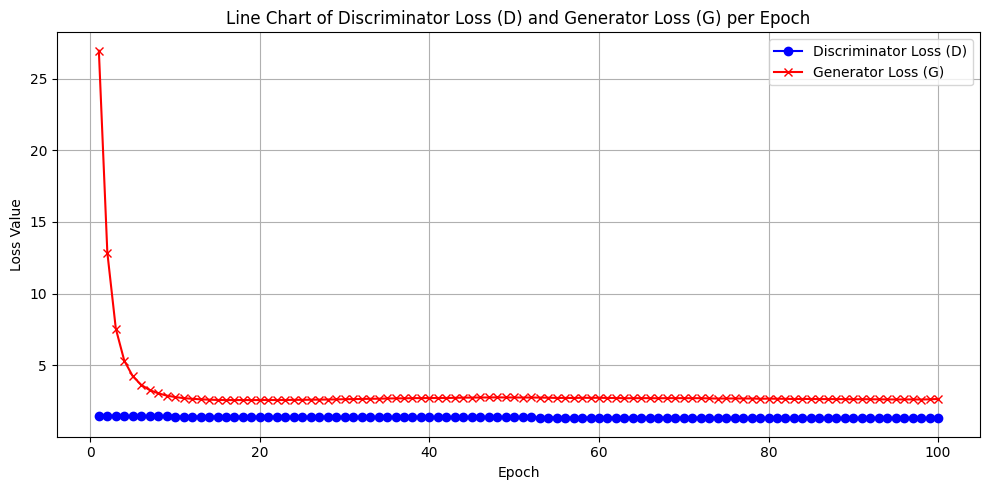

Model saved to models/EVOGRAPH/evograph_simulated_dom1
Average Time per Epoch: 29.52s
Average CPU Usage: 7.31GB
Average Memory Usage: 9.34GB
Average GPU Usage: 0.27GB

Total Training Time: 2952.49s
Max CPU Usage: 9.22GB
Max Memory Usage: 9.37GB
Max GPU Usage: 0.27GB


In [20]:
conv_size = adj_train_domain_1.shape[2]
hidden_size = conv_size*conv_size

sim_dom1_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom1_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
sim_dom1_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom1_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(sim_dom1_generator1)
print(sim_dom1_discriminator1)
n_generator_param = sim_dom1_generator1.count_parameters()
n_discriminator_param = sim_dom1_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(sim_dom1_generator1, sim_dom1_discriminator1, sim_dom1_generator2, sim_dom1_discriminator2,
            adj_train_domain_1, num_epochs=100, save_path="models/EVOGRAPH/evograph_simulated_dom1")

#### Domain 2

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492



Epoch 1/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [1/100]
D1 Loss: 0.74975, G1 Loss: 11.60690, R1 Loss: 0.56151, F1 Loss: 0.93799, MSE: 0.16926, MAE: 0.37078
D2 Loss: 0.74622, G2 Loss: 11.70799, R2 Loss: 0.55845, F2 Loss: 0.93398, MSE: 0.16978, MAE: 0.37195
Time: 26.75s, CPU: 3.96GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 2/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [2/100]
D1 Loss: 0.74558, G1 Loss: 5.70959, R1 Loss: 0.55806, F1 Loss: 0.93311, MSE: 0.07299, MAE: 0.24176
D2 Loss: 0.73889, G2 Loss: 5.78186, R2 Loss: 0.55570, F2 Loss: 0.92207, MSE: 0.07339, MAE: 0.24096
Time: 27.54s, CPU: 7.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 3/100: 100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epoch [3/100]
D1 Loss: 0.74087, G1 Loss: 3.44337, R1 Loss: 0.55819, F1 Loss: 0.92354, MSE: 0.03604, MAE: 0.16750
D2 Loss: 0.73294, G2 Loss: 3.57058, R2 Loss: 0.55306, F2 Loss: 0.91282, MSE: 0.03855, MAE: 0.16839
Time: 25.63s, CPU: 4.73GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 4/100: 100%|██████████| 80/80 [00:25<00:00,  3.15it/s]


Epoch [4/100]
D1 Loss: 0.73399, G1 Loss: 2.48834, R1 Loss: 0.56039, F1 Loss: 0.90758, MSE: 0.02094, MAE: 0.12533
D2 Loss: 0.72104, G2 Loss: 2.60916, R2 Loss: 0.54987, F2 Loss: 0.89222, MSE: 0.02366, MAE: 0.12626
Time: 25.41s, CPU: 4.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 5/100: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]


Epoch [5/100]
D1 Loss: 0.72666, G1 Loss: 2.03375, R1 Loss: 0.56078, F1 Loss: 0.89254, MSE: 0.01376, MAE: 0.09912
D2 Loss: 0.70867, G2 Loss: 2.12152, R2 Loss: 0.55251, F2 Loss: 0.86483, MSE: 0.01561, MAE: 0.10032
Time: 28.44s, CPU: 8.37GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 6/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [6/100]
D1 Loss: 0.72421, G1 Loss: 1.76480, R1 Loss: 0.56298, F1 Loss: 0.88545, MSE: 0.00928, MAE: 0.08116
D2 Loss: 0.70137, G2 Loss: 1.85562, R2 Loss: 0.55563, F2 Loss: 0.84711, MSE: 0.01105, MAE: 0.08250
Time: 28.17s, CPU: 8.25GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 7/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [7/100]
D1 Loss: 0.72024, G1 Loss: 1.60925, R1 Loss: 0.56601, F1 Loss: 0.87446, MSE: 0.00669, MAE: 0.06830
D2 Loss: 0.70319, G2 Loss: 1.69071, R2 Loss: 0.55991, F2 Loss: 0.84646, MSE: 0.00811, MAE: 0.07037
Time: 26.76s, CPU: 7.49GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 8/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [8/100]
D1 Loss: 0.71767, G1 Loss: 1.50718, R1 Loss: 0.56907, F1 Loss: 0.86626, MSE: 0.00487, MAE: 0.05867
D2 Loss: 0.70337, G2 Loss: 1.55322, R2 Loss: 0.56281, F2 Loss: 0.84393, MSE: 0.00553, MAE: 0.06007
Time: 26.46s, CPU: 6.20GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 9/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [9/100]
D1 Loss: 0.71428, G1 Loss: 1.42815, R1 Loss: 0.57112, F1 Loss: 0.85744, MSE: 0.00362, MAE: 0.05074
D2 Loss: 0.69867, G2 Loss: 1.48779, R2 Loss: 0.56697, F2 Loss: 0.83037, MSE: 0.00446, MAE: 0.05295
Time: 27.25s, CPU: 7.43GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 10/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [10/100]
D1 Loss: 0.71223, G1 Loss: 1.38149, R1 Loss: 0.57470, F1 Loss: 0.84976, MSE: 0.00286, MAE: 0.04474
D2 Loss: 0.69764, G2 Loss: 1.43554, R2 Loss: 0.57058, F2 Loss: 0.82470, MSE: 0.00359, MAE: 0.04709
Time: 27.93s, CPU: 8.43GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 11/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [11/100]
D1 Loss: 0.71111, G1 Loss: 1.35192, R1 Loss: 0.57859, F1 Loss: 0.84362, MSE: 0.00229, MAE: 0.04004
D2 Loss: 0.70683, G2 Loss: 1.36176, R2 Loss: 0.57512, F2 Loss: 0.83854, MSE: 0.00243, MAE: 0.04122
Time: 26.72s, CPU: 7.05GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 12/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [12/100]
D1 Loss: 0.70645, G1 Loss: 1.33446, R1 Loss: 0.58325, F1 Loss: 0.82965, MSE: 0.00191, MAE: 0.03659
D2 Loss: 0.70536, G2 Loss: 1.33587, R2 Loss: 0.57868, F2 Loss: 0.83204, MSE: 0.00194, MAE: 0.03675
Time: 27.76s, CPU: 8.28GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 13/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [13/100]
D1 Loss: 0.70608, G1 Loss: 1.32069, R1 Loss: 0.58573, F1 Loss: 0.82642, MSE: 0.00160, MAE: 0.03321
D2 Loss: 0.70506, G2 Loss: 1.32133, R2 Loss: 0.58339, F2 Loss: 0.82674, MSE: 0.00163, MAE: 0.03335
Time: 27.88s, CPU: 8.52GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 14/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [14/100]
D1 Loss: 0.70416, G1 Loss: 1.30957, R1 Loss: 0.59168, F1 Loss: 0.81664, MSE: 0.00138, MAE: 0.03081
D2 Loss: 0.70374, G2 Loss: 1.31473, R2 Loss: 0.58789, F2 Loss: 0.81959, MSE: 0.00139, MAE: 0.03085
Time: 27.22s, CPU: 7.75GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 15/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [15/100]
D1 Loss: 0.70106, G1 Loss: 1.30736, R1 Loss: 0.59504, F1 Loss: 0.80709, MSE: 0.00120, MAE: 0.02873
D2 Loss: 0.70163, G2 Loss: 1.30437, R2 Loss: 0.59115, F2 Loss: 0.81211, MSE: 0.00119, MAE: 0.02856
Time: 26.79s, CPU: 7.55GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 16/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [16/100]
D1 Loss: 0.70110, G1 Loss: 1.30669, R1 Loss: 0.59831, F1 Loss: 0.80389, MSE: 0.00106, MAE: 0.02698
D2 Loss: 0.69967, G2 Loss: 1.30557, R2 Loss: 0.59587, F2 Loss: 0.80347, MSE: 0.00106, MAE: 0.02683
Time: 27.17s, CPU: 6.99GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 17/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [17/100]
D1 Loss: 0.69887, G1 Loss: 1.30766, R1 Loss: 0.60235, F1 Loss: 0.79540, MSE: 0.00095, MAE: 0.02542
D2 Loss: 0.69862, G2 Loss: 1.30051, R2 Loss: 0.60009, F2 Loss: 0.79714, MSE: 0.00095, MAE: 0.02553
Time: 27.30s, CPU: 8.37GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 18/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [18/100]
D1 Loss: 0.69760, G1 Loss: 1.30847, R1 Loss: 0.60508, F1 Loss: 0.79012, MSE: 0.00084, MAE: 0.02388
D2 Loss: 0.69633, G2 Loss: 1.30649, R2 Loss: 0.60269, F2 Loss: 0.78996, MSE: 0.00084, MAE: 0.02413
Time: 26.61s, CPU: 6.05GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 19/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [19/100]
D1 Loss: 0.69475, G1 Loss: 1.31387, R1 Loss: 0.60901, F1 Loss: 0.78049, MSE: 0.00077, MAE: 0.02280
D2 Loss: 0.69488, G2 Loss: 1.30558, R2 Loss: 0.60769, F2 Loss: 0.78207, MSE: 0.00077, MAE: 0.02302
Time: 27.42s, CPU: 7.55GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 20/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [20/100]
D1 Loss: 0.69429, G1 Loss: 1.31322, R1 Loss: 0.61216, F1 Loss: 0.77642, MSE: 0.00068, MAE: 0.02151
D2 Loss: 0.69320, G2 Loss: 1.31423, R2 Loss: 0.60960, F2 Loss: 0.77680, MSE: 0.00071, MAE: 0.02194
Time: 27.71s, CPU: 7.90GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 21/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [21/100]
D1 Loss: 0.69415, G1 Loss: 1.31418, R1 Loss: 0.61680, F1 Loss: 0.77149, MSE: 0.00062, MAE: 0.02051
D2 Loss: 0.69301, G2 Loss: 1.32150, R2 Loss: 0.61259, F2 Loss: 0.77343, MSE: 0.00066, MAE: 0.02108
Time: 27.44s, CPU: 8.60GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 22/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [22/100]
D1 Loss: 0.69019, G1 Loss: 1.31904, R1 Loss: 0.61781, F1 Loss: 0.76257, MSE: 0.00057, MAE: 0.01959
D2 Loss: 0.69183, G2 Loss: 1.31773, R2 Loss: 0.61532, F2 Loss: 0.76834, MSE: 0.00061, MAE: 0.02033
Time: 27.11s, CPU: 7.46GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 23/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [23/100]
D1 Loss: 0.68955, G1 Loss: 1.32385, R1 Loss: 0.62076, F1 Loss: 0.75834, MSE: 0.00054, MAE: 0.01889
D2 Loss: 0.69117, G2 Loss: 1.32499, R2 Loss: 0.61785, F2 Loss: 0.76450, MSE: 0.00058, MAE: 0.01979
Time: 27.26s, CPU: 6.05GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 24/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [24/100]
D1 Loss: 0.69017, G1 Loss: 1.32689, R1 Loss: 0.62409, F1 Loss: 0.75625, MSE: 0.00050, MAE: 0.01817
D2 Loss: 0.69009, G2 Loss: 1.32967, R2 Loss: 0.62147, F2 Loss: 0.75870, MSE: 0.00056, MAE: 0.01932
Time: 27.33s, CPU: 6.93GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 25/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [25/100]
D1 Loss: 0.68774, G1 Loss: 1.33594, R1 Loss: 0.62691, F1 Loss: 0.74857, MSE: 0.00047, MAE: 0.01751
D2 Loss: 0.68884, G2 Loss: 1.33564, R2 Loss: 0.62440, F2 Loss: 0.75329, MSE: 0.00055, MAE: 0.01903
Time: 27.79s, CPU: 6.40GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 26/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [26/100]
D1 Loss: 0.68518, G1 Loss: 1.33894, R1 Loss: 0.62851, F1 Loss: 0.74185, MSE: 0.00043, MAE: 0.01672
D2 Loss: 0.68777, G2 Loss: 1.33805, R2 Loss: 0.62710, F2 Loss: 0.74845, MSE: 0.00052, MAE: 0.01845
Time: 26.73s, CPU: 5.64GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 27/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [27/100]
D1 Loss: 0.68707, G1 Loss: 1.34387, R1 Loss: 0.63164, F1 Loss: 0.74251, MSE: 0.00041, MAE: 0.01630
D2 Loss: 0.68580, G2 Loss: 1.34084, R2 Loss: 0.62888, F2 Loss: 0.74271, MSE: 0.00050, MAE: 0.01796
Time: 27.81s, CPU: 6.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 28/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [28/100]
D1 Loss: 0.68449, G1 Loss: 1.35130, R1 Loss: 0.63379, F1 Loss: 0.73519, MSE: 0.00040, MAE: 0.01608
D2 Loss: 0.68694, G2 Loss: 1.34124, R2 Loss: 0.63153, F2 Loss: 0.74235, MSE: 0.00047, MAE: 0.01741
Time: 26.90s, CPU: 6.34GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 29/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [29/100]
D1 Loss: 0.68235, G1 Loss: 1.35903, R1 Loss: 0.63502, F1 Loss: 0.72968, MSE: 0.00039, MAE: 0.01566
D2 Loss: 0.68500, G2 Loss: 1.35305, R2 Loss: 0.63322, F2 Loss: 0.73677, MSE: 0.00045, MAE: 0.01705
Time: 26.61s, CPU: 7.16GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 30/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [30/100]
D1 Loss: 0.68294, G1 Loss: 1.35992, R1 Loss: 0.63860, F1 Loss: 0.72729, MSE: 0.00037, MAE: 0.01534
D2 Loss: 0.68537, G2 Loss: 1.35391, R2 Loss: 0.63533, F2 Loss: 0.73540, MSE: 0.00045, MAE: 0.01690
Time: 27.50s, CPU: 7.31GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 31/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [31/100]
D1 Loss: 0.68327, G1 Loss: 1.36258, R1 Loss: 0.64076, F1 Loss: 0.72577, MSE: 0.00037, MAE: 0.01510
D2 Loss: 0.68324, G2 Loss: 1.36184, R2 Loss: 0.63656, F2 Loss: 0.72992, MSE: 0.00043, MAE: 0.01664
Time: 26.54s, CPU: 5.96GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 32/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [32/100]
D1 Loss: 0.68364, G1 Loss: 1.36629, R1 Loss: 0.64119, F1 Loss: 0.72609, MSE: 0.00036, MAE: 0.01480
D2 Loss: 0.68325, G2 Loss: 1.36248, R2 Loss: 0.63814, F2 Loss: 0.72835, MSE: 0.00042, MAE: 0.01644
Time: 27.02s, CPU: 6.34GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 33/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [33/100]
D1 Loss: 0.68121, G1 Loss: 1.37188, R1 Loss: 0.64276, F1 Loss: 0.71966, MSE: 0.00035, MAE: 0.01451
D2 Loss: 0.68322, G2 Loss: 1.36240, R2 Loss: 0.63921, F2 Loss: 0.72723, MSE: 0.00041, MAE: 0.01603
Time: 26.27s, CPU: 5.17GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 34/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [34/100]
D1 Loss: 0.68332, G1 Loss: 1.37529, R1 Loss: 0.64455, F1 Loss: 0.72209, MSE: 0.00034, MAE: 0.01414
D2 Loss: 0.68088, G2 Loss: 1.37464, R2 Loss: 0.63999, F2 Loss: 0.72177, MSE: 0.00039, MAE: 0.01566
Time: 27.13s, CPU: 6.49GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 35/100: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]


Epoch [35/100]
D1 Loss: 0.68034, G1 Loss: 1.37871, R1 Loss: 0.64547, F1 Loss: 0.71522, MSE: 0.00033, MAE: 0.01400
D2 Loss: 0.68004, G2 Loss: 1.37059, R2 Loss: 0.64178, F2 Loss: 0.71830, MSE: 0.00038, MAE: 0.01536
Time: 25.98s, CPU: 6.08GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 36/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [36/100]
D1 Loss: 0.67980, G1 Loss: 1.38232, R1 Loss: 0.64424, F1 Loss: 0.71535, MSE: 0.00033, MAE: 0.01389
D2 Loss: 0.68259, G2 Loss: 1.37955, R2 Loss: 0.64438, F2 Loss: 0.72079, MSE: 0.00038, MAE: 0.01507
Time: 27.32s, CPU: 7.40GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 37/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [37/100]
D1 Loss: 0.68021, G1 Loss: 1.37401, R1 Loss: 0.64508, F1 Loss: 0.71535, MSE: 0.00033, MAE: 0.01375
D2 Loss: 0.68099, G2 Loss: 1.37716, R2 Loss: 0.64478, F2 Loss: 0.71720, MSE: 0.00038, MAE: 0.01502
Time: 27.43s, CPU: 7.81GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 38/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [38/100]
D1 Loss: 0.67915, G1 Loss: 1.38194, R1 Loss: 0.64444, F1 Loss: 0.71385, MSE: 0.00034, MAE: 0.01377
D2 Loss: 0.68067, G2 Loss: 1.37747, R2 Loss: 0.64578, F2 Loss: 0.71557, MSE: 0.00037, MAE: 0.01479
Time: 27.60s, CPU: 8.07GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 39/100: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


Epoch [39/100]
D1 Loss: 0.67804, G1 Loss: 1.38522, R1 Loss: 0.64546, F1 Loss: 0.71063, MSE: 0.00032, MAE: 0.01340
D2 Loss: 0.68218, G2 Loss: 1.37509, R2 Loss: 0.64519, F2 Loss: 0.71918, MSE: 0.00039, MAE: 0.01510
Time: 26.10s, CPU: 6.20GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 40/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [40/100]
D1 Loss: 0.67683, G1 Loss: 1.38600, R1 Loss: 0.64322, F1 Loss: 0.71045, MSE: 0.00031, MAE: 0.01333
D2 Loss: 0.68184, G2 Loss: 1.37503, R2 Loss: 0.64517, F2 Loss: 0.71851, MSE: 0.00038, MAE: 0.01485
Time: 26.33s, CPU: 5.87GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 41/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [41/100]
D1 Loss: 0.67561, G1 Loss: 1.38151, R1 Loss: 0.64208, F1 Loss: 0.70914, MSE: 0.00030, MAE: 0.01307
D2 Loss: 0.68194, G2 Loss: 1.37432, R2 Loss: 0.64571, F2 Loss: 0.71817, MSE: 0.00035, MAE: 0.01443
Time: 27.06s, CPU: 5.84GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 42/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [42/100]
D1 Loss: 0.67534, G1 Loss: 1.38284, R1 Loss: 0.64146, F1 Loss: 0.70921, MSE: 0.00030, MAE: 0.01299
D2 Loss: 0.67992, G2 Loss: 1.38157, R2 Loss: 0.64642, F2 Loss: 0.71342, MSE: 0.00035, MAE: 0.01425
Time: 26.42s, CPU: 5.99GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 43/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [43/100]
D1 Loss: 0.67559, G1 Loss: 1.38280, R1 Loss: 0.64029, F1 Loss: 0.71089, MSE: 0.00029, MAE: 0.01281
D2 Loss: 0.68016, G2 Loss: 1.38406, R2 Loss: 0.64771, F2 Loss: 0.71262, MSE: 0.00034, MAE: 0.01409
Time: 26.19s, CPU: 5.29GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 44/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [44/100]
D1 Loss: 0.67488, G1 Loss: 1.38912, R1 Loss: 0.64102, F1 Loss: 0.70874, MSE: 0.00030, MAE: 0.01266
D2 Loss: 0.68002, G2 Loss: 1.38617, R2 Loss: 0.64950, F2 Loss: 0.71054, MSE: 0.00033, MAE: 0.01397
Time: 28.21s, CPU: 8.22GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 45/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [45/100]
D1 Loss: 0.67279, G1 Loss: 1.38710, R1 Loss: 0.63823, F1 Loss: 0.70734, MSE: 0.00028, MAE: 0.01252
D2 Loss: 0.67789, G2 Loss: 1.38612, R2 Loss: 0.64740, F2 Loss: 0.70838, MSE: 0.00032, MAE: 0.01368
Time: 26.94s, CPU: 6.58GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 46/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [46/100]
D1 Loss: 0.67241, G1 Loss: 1.38446, R1 Loss: 0.63637, F1 Loss: 0.70845, MSE: 0.00028, MAE: 0.01232
D2 Loss: 0.67860, G2 Loss: 1.38538, R2 Loss: 0.64696, F2 Loss: 0.71025, MSE: 0.00032, MAE: 0.01347
Time: 26.88s, CPU: 6.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 47/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [47/100]
D1 Loss: 0.67212, G1 Loss: 1.38864, R1 Loss: 0.63599, F1 Loss: 0.70825, MSE: 0.00028, MAE: 0.01233
D2 Loss: 0.67695, G2 Loss: 1.39036, R2 Loss: 0.64763, F2 Loss: 0.70628, MSE: 0.00029, MAE: 0.01300
Time: 26.71s, CPU: 6.40GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 48/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [48/100]
D1 Loss: 0.67105, G1 Loss: 1.38880, R1 Loss: 0.63485, F1 Loss: 0.70725, MSE: 0.00028, MAE: 0.01209
D2 Loss: 0.67584, G2 Loss: 1.38849, R2 Loss: 0.64634, F2 Loss: 0.70533, MSE: 0.00029, MAE: 0.01300
Time: 26.44s, CPU: 5.87GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 49/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [49/100]
D1 Loss: 0.66937, G1 Loss: 1.38719, R1 Loss: 0.63090, F1 Loss: 0.70783, MSE: 0.00028, MAE: 0.01217
D2 Loss: 0.67619, G2 Loss: 1.38693, R2 Loss: 0.64346, F2 Loss: 0.70893, MSE: 0.00026, MAE: 0.01257
Time: 26.80s, CPU: 6.93GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 50/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [50/100]
D1 Loss: 0.66980, G1 Loss: 1.37655, R1 Loss: 0.62757, F1 Loss: 0.71202, MSE: 0.00028, MAE: 0.01223
D2 Loss: 0.67669, G2 Loss: 1.37580, R2 Loss: 0.64054, F2 Loss: 0.71285, MSE: 0.00028, MAE: 0.01274
Time: 27.04s, CPU: 6.31GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 51/100: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


Epoch [51/100]
D1 Loss: 0.67457, G1 Loss: 1.36756, R1 Loss: 0.62670, F1 Loss: 0.72243, MSE: 0.00033, MAE: 0.01281
D2 Loss: 0.67702, G2 Loss: 1.37129, R2 Loss: 0.63888, F2 Loss: 0.71515, MSE: 0.00031, MAE: 0.01345
Time: 26.09s, CPU: 5.84GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 52/100: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Epoch [52/100]
D1 Loss: 0.67776, G1 Loss: 1.36121, R1 Loss: 0.62894, F1 Loss: 0.72658, MSE: 0.00032, MAE: 0.01282
D2 Loss: 0.67567, G2 Loss: 1.37104, R2 Loss: 0.63779, F2 Loss: 0.71355, MSE: 0.00031, MAE: 0.01317
Time: 26.99s, CPU: 6.93GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 53/100: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]


Epoch [53/100]
D1 Loss: 0.67579, G1 Loss: 1.36177, R1 Loss: 0.63100, F1 Loss: 0.72057, MSE: 0.00032, MAE: 0.01250
D2 Loss: 0.67365, G2 Loss: 1.37474, R2 Loss: 0.63571, F2 Loss: 0.71159, MSE: 0.00031, MAE: 0.01322
Time: 25.82s, CPU: 4.82GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 54/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [54/100]
D1 Loss: 0.67499, G1 Loss: 1.36310, R1 Loss: 0.62839, F1 Loss: 0.72158, MSE: 0.00030, MAE: 0.01235
D2 Loss: 0.67454, G2 Loss: 1.37607, R2 Loss: 0.63581, F2 Loss: 0.71326, MSE: 0.00031, MAE: 0.01318
Time: 27.25s, CPU: 6.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 55/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [55/100]
D1 Loss: 0.67712, G1 Loss: 1.37103, R1 Loss: 0.63126, F1 Loss: 0.72297, MSE: 0.00030, MAE: 0.01237
D2 Loss: 0.67532, G2 Loss: 1.37471, R2 Loss: 0.63665, F2 Loss: 0.71399, MSE: 0.00031, MAE: 0.01306
Time: 26.54s, CPU: 6.96GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 56/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [56/100]
D1 Loss: 0.67519, G1 Loss: 1.37034, R1 Loss: 0.63224, F1 Loss: 0.71814, MSE: 0.00029, MAE: 0.01231
D2 Loss: 0.67620, G2 Loss: 1.37864, R2 Loss: 0.63747, F2 Loss: 0.71493, MSE: 0.00031, MAE: 0.01317
Time: 27.05s, CPU: 7.55GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 57/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [57/100]
D1 Loss: 0.67511, G1 Loss: 1.37063, R1 Loss: 0.63315, F1 Loss: 0.71706, MSE: 0.00030, MAE: 0.01233
D2 Loss: 0.67351, G2 Loss: 1.37876, R2 Loss: 0.63681, F2 Loss: 0.71021, MSE: 0.00031, MAE: 0.01329
Time: 26.53s, CPU: 6.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 58/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [58/100]
D1 Loss: 0.67350, G1 Loss: 1.37496, R1 Loss: 0.63049, F1 Loss: 0.71652, MSE: 0.00029, MAE: 0.01223
D2 Loss: 0.67460, G2 Loss: 1.38175, R2 Loss: 0.63805, F2 Loss: 0.71116, MSE: 0.00030, MAE: 0.01273
Time: 26.54s, CPU: 5.87GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 59/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [59/100]
D1 Loss: 0.67379, G1 Loss: 1.37379, R1 Loss: 0.63037, F1 Loss: 0.71721, MSE: 0.00029, MAE: 0.01208
D2 Loss: 0.67481, G2 Loss: 1.38404, R2 Loss: 0.63828, F2 Loss: 0.71134, MSE: 0.00030, MAE: 0.01286
Time: 27.28s, CPU: 7.49GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 60/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [60/100]
D1 Loss: 0.67338, G1 Loss: 1.37159, R1 Loss: 0.63107, F1 Loss: 0.71569, MSE: 0.00029, MAE: 0.01208
D2 Loss: 0.67374, G2 Loss: 1.38130, R2 Loss: 0.63841, F2 Loss: 0.70907, MSE: 0.00030, MAE: 0.01289
Time: 27.07s, CPU: 7.02GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 61/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [61/100]
D1 Loss: 0.67269, G1 Loss: 1.38093, R1 Loss: 0.63171, F1 Loss: 0.71368, MSE: 0.00030, MAE: 0.01232
D2 Loss: 0.67417, G2 Loss: 1.38266, R2 Loss: 0.63676, F2 Loss: 0.71158, MSE: 0.00030, MAE: 0.01272
Time: 27.61s, CPU: 6.58GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 62/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [62/100]
D1 Loss: 0.67203, G1 Loss: 1.37513, R1 Loss: 0.63064, F1 Loss: 0.71342, MSE: 0.00030, MAE: 0.01258
D2 Loss: 0.67407, G2 Loss: 1.38464, R2 Loss: 0.63649, F2 Loss: 0.71164, MSE: 0.00029, MAE: 0.01252
Time: 27.26s, CPU: 7.05GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 63/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [63/100]
D1 Loss: 0.67185, G1 Loss: 1.37038, R1 Loss: 0.62911, F1 Loss: 0.71460, MSE: 0.00033, MAE: 0.01298
D2 Loss: 0.67234, G2 Loss: 1.38486, R2 Loss: 0.63670, F2 Loss: 0.70798, MSE: 0.00030, MAE: 0.01275
Time: 27.74s, CPU: 7.02GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 64/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [64/100]
D1 Loss: 0.67351, G1 Loss: 1.37763, R1 Loss: 0.62977, F1 Loss: 0.71725, MSE: 0.00032, MAE: 0.01293
D2 Loss: 0.67331, G2 Loss: 1.39071, R2 Loss: 0.63660, F2 Loss: 0.71002, MSE: 0.00029, MAE: 0.01265
Time: 27.11s, CPU: 6.84GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 65/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [65/100]
D1 Loss: 0.67152, G1 Loss: 1.37658, R1 Loss: 0.63087, F1 Loss: 0.71217, MSE: 0.00032, MAE: 0.01286
D2 Loss: 0.67456, G2 Loss: 1.38632, R2 Loss: 0.63769, F2 Loss: 0.71142, MSE: 0.00029, MAE: 0.01273
Time: 26.78s, CPU: 7.11GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 66/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [66/100]
D1 Loss: 0.67018, G1 Loss: 1.38073, R1 Loss: 0.62806, F1 Loss: 0.71230, MSE: 0.00031, MAE: 0.01260
D2 Loss: 0.67256, G2 Loss: 1.38562, R2 Loss: 0.63776, F2 Loss: 0.70735, MSE: 0.00029, MAE: 0.01258
Time: 26.97s, CPU: 7.46GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 67/100: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]


Epoch [67/100]
D1 Loss: 0.67040, G1 Loss: 1.37793, R1 Loss: 0.62867, F1 Loss: 0.71213, MSE: 0.00034, MAE: 0.01317
D2 Loss: 0.67107, G2 Loss: 1.38799, R2 Loss: 0.63560, F2 Loss: 0.70654, MSE: 0.00029, MAE: 0.01256
Time: 25.84s, CPU: 5.93GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 68/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [68/100]
D1 Loss: 0.67071, G1 Loss: 1.37227, R1 Loss: 0.62757, F1 Loss: 0.71386, MSE: 0.00035, MAE: 0.01345
D2 Loss: 0.67224, G2 Loss: 1.38617, R2 Loss: 0.63554, F2 Loss: 0.70895, MSE: 0.00030, MAE: 0.01287
Time: 27.48s, CPU: 6.61GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 69/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [69/100]
D1 Loss: 0.67300, G1 Loss: 1.36807, R1 Loss: 0.62826, F1 Loss: 0.71775, MSE: 0.00036, MAE: 0.01328
D2 Loss: 0.67170, G2 Loss: 1.38831, R2 Loss: 0.63454, F2 Loss: 0.70886, MSE: 0.00029, MAE: 0.01251
Time: 26.56s, CPU: 6.52GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 70/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [70/100]
D1 Loss: 0.67015, G1 Loss: 1.38361, R1 Loss: 0.62793, F1 Loss: 0.71237, MSE: 0.00035, MAE: 0.01333
D2 Loss: 0.67043, G2 Loss: 1.38785, R2 Loss: 0.63352, F2 Loss: 0.70735, MSE: 0.00028, MAE: 0.01239
Time: 26.68s, CPU: 5.93GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 71/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [71/100]
D1 Loss: 0.67200, G1 Loss: 1.37891, R1 Loss: 0.62925, F1 Loss: 0.71474, MSE: 0.00036, MAE: 0.01353
D2 Loss: 0.67051, G2 Loss: 1.38656, R2 Loss: 0.63285, F2 Loss: 0.70817, MSE: 0.00029, MAE: 0.01248
Time: 27.52s, CPU: 6.37GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 72/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [72/100]
D1 Loss: 0.66941, G1 Loss: 1.37893, R1 Loss: 0.62674, F1 Loss: 0.71209, MSE: 0.00037, MAE: 0.01351
D2 Loss: 0.67000, G2 Loss: 1.38506, R2 Loss: 0.63298, F2 Loss: 0.70702, MSE: 0.00029, MAE: 0.01253
Time: 26.63s, CPU: 6.78GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 73/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [73/100]
D1 Loss: 0.67137, G1 Loss: 1.37206, R1 Loss: 0.62846, F1 Loss: 0.71427, MSE: 0.00037, MAE: 0.01387
D2 Loss: 0.67087, G2 Loss: 1.38474, R2 Loss: 0.63376, F2 Loss: 0.70797, MSE: 0.00029, MAE: 0.01262
Time: 27.68s, CPU: 8.13GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 74/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [74/100]
D1 Loss: 0.67013, G1 Loss: 1.38163, R1 Loss: 0.62836, F1 Loss: 0.71190, MSE: 0.00038, MAE: 0.01373
D2 Loss: 0.67047, G2 Loss: 1.38651, R2 Loss: 0.63343, F2 Loss: 0.70751, MSE: 0.00029, MAE: 0.01236
Time: 26.88s, CPU: 7.34GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 75/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [75/100]
D1 Loss: 0.67171, G1 Loss: 1.38376, R1 Loss: 0.62858, F1 Loss: 0.71484, MSE: 0.00037, MAE: 0.01370
D2 Loss: 0.66906, G2 Loss: 1.38768, R2 Loss: 0.63266, F2 Loss: 0.70546, MSE: 0.00029, MAE: 0.01256
Time: 27.50s, CPU: 8.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 76/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [76/100]
D1 Loss: 0.67131, G1 Loss: 1.38125, R1 Loss: 0.62789, F1 Loss: 0.71473, MSE: 0.00036, MAE: 0.01356
D2 Loss: 0.67069, G2 Loss: 1.39050, R2 Loss: 0.63198, F2 Loss: 0.70940, MSE: 0.00030, MAE: 0.01270
Time: 27.08s, CPU: 7.08GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 77/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [77/100]
D1 Loss: 0.66862, G1 Loss: 1.37944, R1 Loss: 0.62762, F1 Loss: 0.70961, MSE: 0.00036, MAE: 0.01356
D2 Loss: 0.66934, G2 Loss: 1.38078, R2 Loss: 0.63210, F2 Loss: 0.70658, MSE: 0.00030, MAE: 0.01273
Time: 27.21s, CPU: 7.46GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 78/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [78/100]
D1 Loss: 0.67055, G1 Loss: 1.38473, R1 Loss: 0.62832, F1 Loss: 0.71279, MSE: 0.00037, MAE: 0.01362
D2 Loss: 0.66791, G2 Loss: 1.38641, R2 Loss: 0.62930, F2 Loss: 0.70653, MSE: 0.00031, MAE: 0.01288
Time: 26.98s, CPU: 7.16GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 79/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [79/100]
D1 Loss: 0.66920, G1 Loss: 1.38458, R1 Loss: 0.62987, F1 Loss: 0.70854, MSE: 0.00036, MAE: 0.01353
D2 Loss: 0.66959, G2 Loss: 1.38522, R2 Loss: 0.62971, F2 Loss: 0.70946, MSE: 0.00032, MAE: 0.01291
Time: 26.57s, CPU: 7.19GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 80/100: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]


Epoch [80/100]
D1 Loss: 0.66979, G1 Loss: 1.38069, R1 Loss: 0.62791, F1 Loss: 0.71167, MSE: 0.00036, MAE: 0.01369
D2 Loss: 0.66872, G2 Loss: 1.38425, R2 Loss: 0.63017, F2 Loss: 0.70726, MSE: 0.00030, MAE: 0.01256
Time: 25.95s, CPU: 5.61GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 81/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [81/100]
D1 Loss: 0.66920, G1 Loss: 1.38325, R1 Loss: 0.62681, F1 Loss: 0.71159, MSE: 0.00037, MAE: 0.01355
D2 Loss: 0.67064, G2 Loss: 1.39297, R2 Loss: 0.63040, F2 Loss: 0.71089, MSE: 0.00030, MAE: 0.01260
Time: 27.16s, CPU: 7.49GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 82/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [82/100]
D1 Loss: 0.67042, G1 Loss: 1.38270, R1 Loss: 0.62741, F1 Loss: 0.71344, MSE: 0.00036, MAE: 0.01350
D2 Loss: 0.66914, G2 Loss: 1.38731, R2 Loss: 0.63002, F2 Loss: 0.70825, MSE: 0.00030, MAE: 0.01266
Time: 26.86s, CPU: 6.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 83/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [83/100]
D1 Loss: 0.66841, G1 Loss: 1.38920, R1 Loss: 0.62636, F1 Loss: 0.71046, MSE: 0.00036, MAE: 0.01339
D2 Loss: 0.66824, G2 Loss: 1.38923, R2 Loss: 0.62975, F2 Loss: 0.70673, MSE: 0.00030, MAE: 0.01261
Time: 26.86s, CPU: 7.55GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 84/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [84/100]
D1 Loss: 0.66897, G1 Loss: 1.38552, R1 Loss: 0.62601, F1 Loss: 0.71192, MSE: 0.00035, MAE: 0.01355
D2 Loss: 0.66765, G2 Loss: 1.38586, R2 Loss: 0.62888, F2 Loss: 0.70641, MSE: 0.00029, MAE: 0.01229
Time: 26.95s, CPU: 6.49GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 85/100: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]


Epoch [85/100]
D1 Loss: 0.66830, G1 Loss: 1.38464, R1 Loss: 0.62593, F1 Loss: 0.71067, MSE: 0.00035, MAE: 0.01320
D2 Loss: 0.66721, G2 Loss: 1.39043, R2 Loss: 0.62787, F2 Loss: 0.70656, MSE: 0.00028, MAE: 0.01208
Time: 25.90s, CPU: 4.76GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 86/100: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


Epoch [86/100]
D1 Loss: 0.66772, G1 Loss: 1.38317, R1 Loss: 0.62519, F1 Loss: 0.71025, MSE: 0.00035, MAE: 0.01333
D2 Loss: 0.66703, G2 Loss: 1.38562, R2 Loss: 0.62804, F2 Loss: 0.70601, MSE: 0.00028, MAE: 0.01227
Time: 26.02s, CPU: 6.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 87/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [87/100]
D1 Loss: 0.66868, G1 Loss: 1.38166, R1 Loss: 0.62576, F1 Loss: 0.71160, MSE: 0.00036, MAE: 0.01335
D2 Loss: 0.66532, G2 Loss: 1.38186, R2 Loss: 0.62608, F2 Loss: 0.70456, MSE: 0.00031, MAE: 0.01253
Time: 27.78s, CPU: 8.28GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 88/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [88/100]
D1 Loss: 0.66634, G1 Loss: 1.38400, R1 Loss: 0.62528, F1 Loss: 0.70740, MSE: 0.00036, MAE: 0.01354
D2 Loss: 0.66716, G2 Loss: 1.38397, R2 Loss: 0.62480, F2 Loss: 0.70952, MSE: 0.00031, MAE: 0.01274
Time: 26.81s, CPU: 5.29GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 89/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [89/100]
D1 Loss: 0.66667, G1 Loss: 1.38997, R1 Loss: 0.62432, F1 Loss: 0.70901, MSE: 0.00036, MAE: 0.01348
D2 Loss: 0.66705, G2 Loss: 1.38036, R2 Loss: 0.62597, F2 Loss: 0.70814, MSE: 0.00030, MAE: 0.01250
Time: 27.25s, CPU: 7.37GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 90/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [90/100]
D1 Loss: 0.66973, G1 Loss: 1.38553, R1 Loss: 0.62284, F1 Loss: 0.71662, MSE: 0.00036, MAE: 0.01336
D2 Loss: 0.66626, G2 Loss: 1.38141, R2 Loss: 0.62608, F2 Loss: 0.70645, MSE: 0.00031, MAE: 0.01262
Time: 27.33s, CPU: 6.81GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 91/100: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]


Epoch [91/100]
D1 Loss: 0.66670, G1 Loss: 1.38246, R1 Loss: 0.62446, F1 Loss: 0.70894, MSE: 0.00036, MAE: 0.01344
D2 Loss: 0.66618, G2 Loss: 1.38055, R2 Loss: 0.62403, F2 Loss: 0.70833, MSE: 0.00031, MAE: 0.01270
Time: 28.91s, CPU: 7.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 92/100: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]


Epoch [92/100]
D1 Loss: 0.66777, G1 Loss: 1.38932, R1 Loss: 0.62541, F1 Loss: 0.71012, MSE: 0.00036, MAE: 0.01341
D2 Loss: 0.66529, G2 Loss: 1.38683, R2 Loss: 0.62359, F2 Loss: 0.70699, MSE: 0.00031, MAE: 0.01264
Time: 25.91s, CPU: 5.96GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 93/100: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]


Epoch [93/100]
D1 Loss: 0.66768, G1 Loss: 1.38271, R1 Loss: 0.62440, F1 Loss: 0.71095, MSE: 0.00035, MAE: 0.01318
D2 Loss: 0.66644, G2 Loss: 1.39052, R2 Loss: 0.62383, F2 Loss: 0.70906, MSE: 0.00032, MAE: 0.01284
Time: 25.92s, CPU: 5.67GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 94/100: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]


Epoch [94/100]
D1 Loss: 0.66764, G1 Loss: 1.38795, R1 Loss: 0.62391, F1 Loss: 0.71137, MSE: 0.00035, MAE: 0.01316
D2 Loss: 0.66616, G2 Loss: 1.38583, R2 Loss: 0.62489, F2 Loss: 0.70742, MSE: 0.00033, MAE: 0.01308
Time: 25.84s, CPU: 5.70GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 95/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [95/100]
D1 Loss: 0.66771, G1 Loss: 1.38552, R1 Loss: 0.62521, F1 Loss: 0.71021, MSE: 0.00036, MAE: 0.01330
D2 Loss: 0.66500, G2 Loss: 1.38436, R2 Loss: 0.62217, F2 Loss: 0.70783, MSE: 0.00034, MAE: 0.01343
Time: 26.74s, CPU: 7.96GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 96/100: 100%|██████████| 80/80 [00:25<00:00,  3.11it/s]


Epoch [96/100]
D1 Loss: 0.66641, G1 Loss: 1.38529, R1 Loss: 0.62461, F1 Loss: 0.70822, MSE: 0.00035, MAE: 0.01335
D2 Loss: 0.66837, G2 Loss: 1.39027, R2 Loss: 0.62488, F2 Loss: 0.71186, MSE: 0.00034, MAE: 0.01341
Time: 25.72s, CPU: 5.52GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 97/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [97/100]
D1 Loss: 0.66707, G1 Loss: 1.38983, R1 Loss: 0.62399, F1 Loss: 0.71015, MSE: 0.00036, MAE: 0.01349
D2 Loss: 0.66487, G2 Loss: 1.38158, R2 Loss: 0.62292, F2 Loss: 0.70683, MSE: 0.00038, MAE: 0.01373
Time: 27.26s, CPU: 7.40GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 98/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [98/100]
D1 Loss: 0.66657, G1 Loss: 1.39165, R1 Loss: 0.62367, F1 Loss: 0.70947, MSE: 0.00036, MAE: 0.01330
D2 Loss: 0.66457, G2 Loss: 1.38688, R2 Loss: 0.62065, F2 Loss: 0.70850, MSE: 0.00037, MAE: 0.01386
Time: 27.27s, CPU: 7.16GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 99/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [99/100]
D1 Loss: 0.66504, G1 Loss: 1.39046, R1 Loss: 0.62265, F1 Loss: 0.70744, MSE: 0.00033, MAE: 0.01275
D2 Loss: 0.66553, G2 Loss: 1.38574, R2 Loss: 0.62276, F2 Loss: 0.70830, MSE: 0.00037, MAE: 0.01381
Time: 27.35s, CPU: 7.75GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 100/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [100/100]
D1 Loss: 0.66343, G1 Loss: 1.38931, R1 Loss: 0.62054, F1 Loss: 0.70631, MSE: 0.00031, MAE: 0.01255
D2 Loss: 0.66616, G2 Loss: 1.39306, R2 Loss: 0.62341, F2 Loss: 0.70892, MSE: 0.00040, MAE: 0.01418
Time: 27.39s, CPU: 8.07GB, Memory: 5.18GB, GPU: 0.12GB



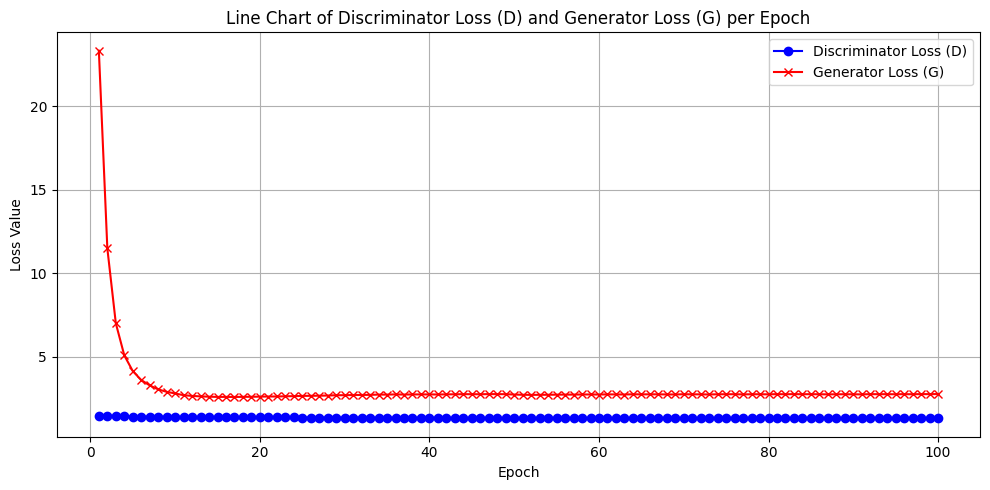

Model saved to models/EVOGRAPH/evograph_simulated_dom2
Average Time per Epoch: 26.96s
Average CPU Usage: 6.82GB
Average Memory Usage: 5.17GB
Average GPU Usage: 0.12GB

Total Training Time: 2696.24s
Max CPU Usage: 8.60GB
Max Memory Usage: 5.21GB
Max GPU Usage: 0.12GB


In [27]:
conv_size = adj_train_domain_2.shape[2]
hidden_size = conv_size*conv_size

sim_dom2_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom2_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
sim_dom2_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom2_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(sim_dom2_generator1)
print(sim_dom2_discriminator1)
n_generator_param = sim_dom2_generator1.count_parameters()
n_discriminator_param = sim_dom2_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(sim_dom2_generator1, sim_dom2_discriminator1, sim_dom2_generator2, sim_dom2_discriminator2,
            adj_train_domain_2, num_epochs=100, save_path="models/EVOGRAPH/evograph_simulated_dom2")

#### Domain 3

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492



Epoch 1/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [1/100]
D1 Loss: 0.75054, G1 Loss: 13.54583, R1 Loss: 0.56223, F1 Loss: 0.93885, MSE: 0.16803, MAE: 0.36958
D2 Loss: 0.74774, G2 Loss: 13.84791, R2 Loss: 0.55577, F2 Loss: 0.93972, MSE: 0.16825, MAE: 0.37096
Time: 26.77s, CPU: 3.44GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 2/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [2/100]
D1 Loss: 0.74521, G1 Loss: 6.34202, R1 Loss: 0.55827, F1 Loss: 0.93215, MSE: 0.06901, MAE: 0.23835
D2 Loss: 0.74514, G2 Loss: 6.49548, R2 Loss: 0.55808, F2 Loss: 0.93220, MSE: 0.06920, MAE: 0.23759
Time: 27.09s, CPU: 6.78GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 3/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [3/100]
D1 Loss: 0.74107, G1 Loss: 3.73939, R1 Loss: 0.55830, F1 Loss: 0.92384, MSE: 0.03341, MAE: 0.16464
D2 Loss: 0.74117, G2 Loss: 3.79543, R2 Loss: 0.56111, F2 Loss: 0.92122, MSE: 0.03367, MAE: 0.16422
Time: 27.13s, CPU: 6.37GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 4/100: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]


Epoch [4/100]
D1 Loss: 0.73402, G1 Loss: 2.63338, R1 Loss: 0.55816, F1 Loss: 0.90987, MSE: 0.01895, MAE: 0.12224
D2 Loss: 0.73938, G2 Loss: 2.66330, R2 Loss: 0.56616, F2 Loss: 0.91261, MSE: 0.01907, MAE: 0.12284
Time: 28.65s, CPU: 8.66GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 5/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [5/100]
D1 Loss: 0.72979, G1 Loss: 2.10623, R1 Loss: 0.55623, F1 Loss: 0.90335, MSE: 0.01197, MAE: 0.09626
D2 Loss: 0.73306, G2 Loss: 2.12219, R2 Loss: 0.56636, F2 Loss: 0.89976, MSE: 0.01193, MAE: 0.09606
Time: 26.61s, CPU: 5.96GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 6/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [6/100]
D1 Loss: 0.72422, G1 Loss: 1.80947, R1 Loss: 0.55993, F1 Loss: 0.88850, MSE: 0.00812, MAE: 0.07838
D2 Loss: 0.72942, G2 Loss: 1.82465, R2 Loss: 0.56797, F2 Loss: 0.89088, MSE: 0.00809, MAE: 0.07798
Time: 27.32s, CPU: 7.43GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 7/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [7/100]
D1 Loss: 0.72115, G1 Loss: 1.62978, R1 Loss: 0.56174, F1 Loss: 0.88057, MSE: 0.00582, MAE: 0.06550
D2 Loss: 0.72517, G2 Loss: 1.64031, R2 Loss: 0.56925, F2 Loss: 0.88109, MSE: 0.00580, MAE: 0.06519
Time: 27.53s, CPU: 7.08GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 8/100: 100%|██████████| 80/80 [00:27<00:00,  2.86it/s]


Epoch [8/100]
D1 Loss: 0.71792, G1 Loss: 1.52142, R1 Loss: 0.56387, F1 Loss: 0.87197, MSE: 0.00435, MAE: 0.05595
D2 Loss: 0.72108, G2 Loss: 1.52407, R2 Loss: 0.57215, F2 Loss: 0.87001, MSE: 0.00432, MAE: 0.05572
Time: 27.96s, CPU: 8.63GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 9/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [9/100]
D1 Loss: 0.71385, G1 Loss: 1.44987, R1 Loss: 0.56712, F1 Loss: 0.86059, MSE: 0.00340, MAE: 0.04919
D2 Loss: 0.71783, G2 Loss: 1.45305, R2 Loss: 0.57309, F2 Loss: 0.86256, MSE: 0.00334, MAE: 0.04891
Time: 27.29s, CPU: 7.72GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 10/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [10/100]
D1 Loss: 0.71078, G1 Loss: 1.39730, R1 Loss: 0.57051, F1 Loss: 0.85105, MSE: 0.00268, MAE: 0.04306
D2 Loss: 0.71500, G2 Loss: 1.40189, R2 Loss: 0.57699, F2 Loss: 0.85301, MSE: 0.00265, MAE: 0.04322
Time: 28.15s, CPU: 8.05GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 11/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [11/100]
D1 Loss: 0.70779, G1 Loss: 1.36424, R1 Loss: 0.57380, F1 Loss: 0.84178, MSE: 0.00216, MAE: 0.03855
D2 Loss: 0.71085, G2 Loss: 1.36583, R2 Loss: 0.58032, F2 Loss: 0.84139, MSE: 0.00214, MAE: 0.03839
Time: 26.33s, CPU: 6.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 12/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [12/100]
D1 Loss: 0.70483, G1 Loss: 1.34115, R1 Loss: 0.57728, F1 Loss: 0.83237, MSE: 0.00176, MAE: 0.03475
D2 Loss: 0.70986, G2 Loss: 1.34438, R2 Loss: 0.58328, F2 Loss: 0.83643, MSE: 0.00178, MAE: 0.03472
Time: 27.26s, CPU: 5.78GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 13/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [13/100]
D1 Loss: 0.70420, G1 Loss: 1.32328, R1 Loss: 0.58064, F1 Loss: 0.82776, MSE: 0.00149, MAE: 0.03159
D2 Loss: 0.70471, G2 Loss: 1.32747, R2 Loss: 0.58361, F2 Loss: 0.82580, MSE: 0.00148, MAE: 0.03181
Time: 27.32s, CPU: 7.43GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 14/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [14/100]
D1 Loss: 0.70172, G1 Loss: 1.31146, R1 Loss: 0.58504, F1 Loss: 0.81839, MSE: 0.00127, MAE: 0.02924
D2 Loss: 0.70007, G2 Loss: 1.31926, R2 Loss: 0.58585, F2 Loss: 0.81429, MSE: 0.00126, MAE: 0.02912
Time: 27.56s, CPU: 8.28GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 15/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [15/100]
D1 Loss: 0.69836, G1 Loss: 1.30499, R1 Loss: 0.58817, F1 Loss: 0.80855, MSE: 0.00110, MAE: 0.02720
D2 Loss: 0.69842, G2 Loss: 1.31427, R2 Loss: 0.59005, F2 Loss: 0.80679, MSE: 0.00109, MAE: 0.02693
Time: 27.18s, CPU: 7.99GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 16/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [16/100]
D1 Loss: 0.69514, G1 Loss: 1.30549, R1 Loss: 0.59137, F1 Loss: 0.79891, MSE: 0.00096, MAE: 0.02517
D2 Loss: 0.69700, G2 Loss: 1.30689, R2 Loss: 0.59419, F2 Loss: 0.79980, MSE: 0.00097, MAE: 0.02532
Time: 26.83s, CPU: 7.43GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 17/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [17/100]
D1 Loss: 0.69455, G1 Loss: 1.30114, R1 Loss: 0.59524, F1 Loss: 0.79385, MSE: 0.00086, MAE: 0.02364
D2 Loss: 0.69581, G2 Loss: 1.30643, R2 Loss: 0.59622, F2 Loss: 0.79541, MSE: 0.00086, MAE: 0.02408
Time: 27.24s, CPU: 7.87GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 18/100: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]


Epoch [18/100]
D1 Loss: 0.69210, G1 Loss: 1.30653, R1 Loss: 0.59806, F1 Loss: 0.78615, MSE: 0.00077, MAE: 0.02239
D2 Loss: 0.69540, G2 Loss: 1.30108, R2 Loss: 0.60010, F2 Loss: 0.79070, MSE: 0.00077, MAE: 0.02256
Time: 25.84s, CPU: 4.76GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 19/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [19/100]
D1 Loss: 0.69154, G1 Loss: 1.30774, R1 Loss: 0.60183, F1 Loss: 0.78124, MSE: 0.00070, MAE: 0.02135
D2 Loss: 0.69651, G2 Loss: 1.29836, R2 Loss: 0.60300, F2 Loss: 0.79002, MSE: 0.00070, MAE: 0.02162
Time: 27.86s, CPU: 7.93GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 20/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [20/100]
D1 Loss: 0.68922, G1 Loss: 1.31323, R1 Loss: 0.60471, F1 Loss: 0.77373, MSE: 0.00064, MAE: 0.02053
D2 Loss: 0.69752, G2 Loss: 1.29770, R2 Loss: 0.60709, F2 Loss: 0.78794, MSE: 0.00065, MAE: 0.02046
Time: 27.24s, CPU: 7.19GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 21/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [21/100]
D1 Loss: 0.68939, G1 Loss: 1.31942, R1 Loss: 0.60845, F1 Loss: 0.77033, MSE: 0.00060, MAE: 0.01974
D2 Loss: 0.69733, G2 Loss: 1.29816, R2 Loss: 0.61048, F2 Loss: 0.78418, MSE: 0.00059, MAE: 0.01969
Time: 27.47s, CPU: 7.43GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 22/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [22/100]
D1 Loss: 0.68777, G1 Loss: 1.31762, R1 Loss: 0.61041, F1 Loss: 0.76513, MSE: 0.00056, MAE: 0.01903
D2 Loss: 0.69738, G2 Loss: 1.29896, R2 Loss: 0.61583, F2 Loss: 0.77893, MSE: 0.00055, MAE: 0.01883
Time: 27.74s, CPU: 8.16GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 23/100: 100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epoch [23/100]
D1 Loss: 0.68770, G1 Loss: 1.32572, R1 Loss: 0.61361, F1 Loss: 0.76179, MSE: 0.00053, MAE: 0.01864
D2 Loss: 0.69566, G2 Loss: 1.30269, R2 Loss: 0.61801, F2 Loss: 0.77330, MSE: 0.00050, MAE: 0.01806
Time: 25.68s, CPU: 5.64GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 24/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [24/100]
D1 Loss: 0.68699, G1 Loss: 1.32330, R1 Loss: 0.61568, F1 Loss: 0.75831, MSE: 0.00050, MAE: 0.01801
D2 Loss: 0.69409, G2 Loss: 1.31076, R2 Loss: 0.62234, F2 Loss: 0.76584, MSE: 0.00047, MAE: 0.01751
Time: 27.10s, CPU: 6.93GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 25/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [25/100]
D1 Loss: 0.68708, G1 Loss: 1.32678, R1 Loss: 0.61986, F1 Loss: 0.75430, MSE: 0.00048, MAE: 0.01739
D2 Loss: 0.69296, G2 Loss: 1.31157, R2 Loss: 0.62500, F2 Loss: 0.76092, MSE: 0.00045, MAE: 0.01684
Time: 27.56s, CPU: 7.14GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 26/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [26/100]
D1 Loss: 0.68893, G1 Loss: 1.33290, R1 Loss: 0.62446, F1 Loss: 0.75340, MSE: 0.00046, MAE: 0.01710
D2 Loss: 0.69253, G2 Loss: 1.31800, R2 Loss: 0.62745, F2 Loss: 0.75761, MSE: 0.00042, MAE: 0.01650
Time: 27.82s, CPU: 7.22GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 27/100: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Epoch [27/100]
D1 Loss: 0.68676, G1 Loss: 1.33033, R1 Loss: 0.62678, F1 Loss: 0.74673, MSE: 0.00044, MAE: 0.01658
D2 Loss: 0.69022, G2 Loss: 1.32279, R2 Loss: 0.63174, F2 Loss: 0.74870, MSE: 0.00040, MAE: 0.01595
Time: 26.99s, CPU: 7.40GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 28/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [28/100]
D1 Loss: 0.68655, G1 Loss: 1.33985, R1 Loss: 0.63118, F1 Loss: 0.74192, MSE: 0.00041, MAE: 0.01603
D2 Loss: 0.68983, G2 Loss: 1.33427, R2 Loss: 0.63376, F2 Loss: 0.74589, MSE: 0.00037, MAE: 0.01536
Time: 26.76s, CPU: 7.31GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 29/100: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]


Epoch [29/100]
D1 Loss: 0.68653, G1 Loss: 1.34640, R1 Loss: 0.63358, F1 Loss: 0.73947, MSE: 0.00040, MAE: 0.01562
D2 Loss: 0.68765, G2 Loss: 1.33428, R2 Loss: 0.63534, F2 Loss: 0.73997, MSE: 0.00036, MAE: 0.01518
Time: 25.52s, CPU: 4.90GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 30/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [30/100]
D1 Loss: 0.68512, G1 Loss: 1.35086, R1 Loss: 0.63634, F1 Loss: 0.73389, MSE: 0.00038, MAE: 0.01524
D2 Loss: 0.68886, G2 Loss: 1.34132, R2 Loss: 0.63979, F2 Loss: 0.73792, MSE: 0.00035, MAE: 0.01495
Time: 27.04s, CPU: 5.81GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 31/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [31/100]
D1 Loss: 0.68447, G1 Loss: 1.35741, R1 Loss: 0.63919, F1 Loss: 0.72976, MSE: 0.00036, MAE: 0.01496
D2 Loss: 0.68823, G2 Loss: 1.34519, R2 Loss: 0.64044, F2 Loss: 0.73602, MSE: 0.00034, MAE: 0.01470
Time: 27.10s, CPU: 7.11GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 32/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [32/100]
D1 Loss: 0.68495, G1 Loss: 1.36526, R1 Loss: 0.64142, F1 Loss: 0.72848, MSE: 0.00035, MAE: 0.01462
D2 Loss: 0.68663, G2 Loss: 1.35425, R2 Loss: 0.64259, F2 Loss: 0.73067, MSE: 0.00032, MAE: 0.01435
Time: 26.92s, CPU: 7.22GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 33/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [33/100]
D1 Loss: 0.68356, G1 Loss: 1.36187, R1 Loss: 0.64305, F1 Loss: 0.72407, MSE: 0.00034, MAE: 0.01437
D2 Loss: 0.68536, G2 Loss: 1.35496, R2 Loss: 0.64536, F2 Loss: 0.72537, MSE: 0.00032, MAE: 0.01401
Time: 26.23s, CPU: 5.61GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 34/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [34/100]
D1 Loss: 0.68359, G1 Loss: 1.36508, R1 Loss: 0.64397, F1 Loss: 0.72321, MSE: 0.00031, MAE: 0.01404
D2 Loss: 0.68709, G2 Loss: 1.35996, R2 Loss: 0.64706, F2 Loss: 0.72711, MSE: 0.00029, MAE: 0.01359
Time: 26.43s, CPU: 6.75GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 35/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [35/100]
D1 Loss: 0.68322, G1 Loss: 1.36228, R1 Loss: 0.64357, F1 Loss: 0.72287, MSE: 0.00030, MAE: 0.01368
D2 Loss: 0.68602, G2 Loss: 1.36265, R2 Loss: 0.64760, F2 Loss: 0.72444, MSE: 0.00029, MAE: 0.01332
Time: 27.23s, CPU: 6.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 36/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [36/100]
D1 Loss: 0.68515, G1 Loss: 1.36585, R1 Loss: 0.64766, F1 Loss: 0.72265, MSE: 0.00029, MAE: 0.01339
D2 Loss: 0.68456, G2 Loss: 1.36593, R2 Loss: 0.64884, F2 Loss: 0.72028, MSE: 0.00028, MAE: 0.01298
Time: 27.40s, CPU: 7.28GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 37/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [37/100]
D1 Loss: 0.68521, G1 Loss: 1.36472, R1 Loss: 0.64751, F1 Loss: 0.72290, MSE: 0.00027, MAE: 0.01306
D2 Loss: 0.68438, G2 Loss: 1.36357, R2 Loss: 0.64875, F2 Loss: 0.72001, MSE: 0.00028, MAE: 0.01297
Time: 26.37s, CPU: 5.81GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 38/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [38/100]
D1 Loss: 0.68378, G1 Loss: 1.37012, R1 Loss: 0.64739, F1 Loss: 0.72018, MSE: 0.00027, MAE: 0.01285
D2 Loss: 0.68411, G2 Loss: 1.36639, R2 Loss: 0.64892, F2 Loss: 0.71929, MSE: 0.00026, MAE: 0.01271
Time: 27.14s, CPU: 7.31GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 39/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [39/100]
D1 Loss: 0.68378, G1 Loss: 1.37212, R1 Loss: 0.64948, F1 Loss: 0.71808, MSE: 0.00028, MAE: 0.01295
D2 Loss: 0.68320, G2 Loss: 1.36837, R2 Loss: 0.64848, F2 Loss: 0.71792, MSE: 0.00026, MAE: 0.01248
Time: 26.91s, CPU: 6.93GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 40/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [40/100]
D1 Loss: 0.68335, G1 Loss: 1.36757, R1 Loss: 0.64810, F1 Loss: 0.71860, MSE: 0.00027, MAE: 0.01287
D2 Loss: 0.68310, G2 Loss: 1.36653, R2 Loss: 0.64794, F2 Loss: 0.71825, MSE: 0.00026, MAE: 0.01237
Time: 26.90s, CPU: 7.25GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 41/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [41/100]
D1 Loss: 0.68185, G1 Loss: 1.36717, R1 Loss: 0.64612, F1 Loss: 0.71758, MSE: 0.00027, MAE: 0.01283
D2 Loss: 0.68347, G2 Loss: 1.37318, R2 Loss: 0.64835, F2 Loss: 0.71858, MSE: 0.00026, MAE: 0.01234
Time: 26.88s, CPU: 6.64GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 42/100: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


Epoch [42/100]
D1 Loss: 0.68143, G1 Loss: 1.37373, R1 Loss: 0.64714, F1 Loss: 0.71572, MSE: 0.00025, MAE: 0.01236
D2 Loss: 0.68296, G2 Loss: 1.36750, R2 Loss: 0.64893, F2 Loss: 0.71698, MSE: 0.00025, MAE: 0.01205
Time: 26.05s, CPU: 4.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 43/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [43/100]
D1 Loss: 0.68067, G1 Loss: 1.38028, R1 Loss: 0.64914, F1 Loss: 0.71221, MSE: 0.00024, MAE: 0.01225
D2 Loss: 0.68272, G2 Loss: 1.36680, R2 Loss: 0.64779, F2 Loss: 0.71766, MSE: 0.00024, MAE: 0.01184
Time: 26.95s, CPU: 6.67GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 44/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [44/100]
D1 Loss: 0.68036, G1 Loss: 1.37909, R1 Loss: 0.64766, F1 Loss: 0.71306, MSE: 0.00023, MAE: 0.01185
D2 Loss: 0.68336, G2 Loss: 1.37329, R2 Loss: 0.64920, F2 Loss: 0.71751, MSE: 0.00023, MAE: 0.01173
Time: 26.62s, CPU: 6.28GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 45/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [45/100]
D1 Loss: 0.67938, G1 Loss: 1.38079, R1 Loss: 0.64631, F1 Loss: 0.71244, MSE: 0.00023, MAE: 0.01176
D2 Loss: 0.68212, G2 Loss: 1.37060, R2 Loss: 0.64692, F2 Loss: 0.71732, MSE: 0.00023, MAE: 0.01163
Time: 27.66s, CPU: 8.22GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 46/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [46/100]
D1 Loss: 0.67959, G1 Loss: 1.37918, R1 Loss: 0.64641, F1 Loss: 0.71277, MSE: 0.00023, MAE: 0.01184
D2 Loss: 0.67984, G2 Loss: 1.37045, R2 Loss: 0.64627, F2 Loss: 0.71340, MSE: 0.00023, MAE: 0.01152
Time: 26.68s, CPU: 6.25GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 47/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [47/100]
D1 Loss: 0.67999, G1 Loss: 1.37607, R1 Loss: 0.64432, F1 Loss: 0.71566, MSE: 0.00025, MAE: 0.01189
D2 Loss: 0.67995, G2 Loss: 1.37421, R2 Loss: 0.64747, F2 Loss: 0.71243, MSE: 0.00023, MAE: 0.01153
Time: 27.33s, CPU: 7.43GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 48/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [48/100]
D1 Loss: 0.67643, G1 Loss: 1.37849, R1 Loss: 0.64151, F1 Loss: 0.71135, MSE: 0.00024, MAE: 0.01204
D2 Loss: 0.68064, G2 Loss: 1.37286, R2 Loss: 0.64627, F2 Loss: 0.71501, MSE: 0.00023, MAE: 0.01161
Time: 26.33s, CPU: 5.78GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 49/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [49/100]
D1 Loss: 0.67676, G1 Loss: 1.37868, R1 Loss: 0.64069, F1 Loss: 0.71283, MSE: 0.00024, MAE: 0.01172
D2 Loss: 0.68122, G2 Loss: 1.37510, R2 Loss: 0.64802, F2 Loss: 0.71442, MSE: 0.00023, MAE: 0.01141
Time: 26.26s, CPU: 5.34GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 50/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [50/100]
D1 Loss: 0.67570, G1 Loss: 1.37679, R1 Loss: 0.64094, F1 Loss: 0.71045, MSE: 0.00021, MAE: 0.01142
D2 Loss: 0.67962, G2 Loss: 1.36967, R2 Loss: 0.64577, F2 Loss: 0.71346, MSE: 0.00022, MAE: 0.01129
Time: 27.31s, CPU: 7.81GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 51/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [51/100]
D1 Loss: 0.67665, G1 Loss: 1.38066, R1 Loss: 0.64016, F1 Loss: 0.71314, MSE: 0.00020, MAE: 0.01110
D2 Loss: 0.67927, G2 Loss: 1.37153, R2 Loss: 0.64482, F2 Loss: 0.71372, MSE: 0.00022, MAE: 0.01116
Time: 26.92s, CPU: 6.96GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 52/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [52/100]
D1 Loss: 0.67416, G1 Loss: 1.37973, R1 Loss: 0.63893, F1 Loss: 0.70939, MSE: 0.00021, MAE: 0.01128
D2 Loss: 0.67894, G2 Loss: 1.37133, R2 Loss: 0.64463, F2 Loss: 0.71326, MSE: 0.00022, MAE: 0.01122
Time: 26.95s, CPU: 5.76GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 53/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [53/100]
D1 Loss: 0.67259, G1 Loss: 1.38156, R1 Loss: 0.63604, F1 Loss: 0.70913, MSE: 0.00021, MAE: 0.01115
D2 Loss: 0.67892, G2 Loss: 1.36420, R2 Loss: 0.64372, F2 Loss: 0.71411, MSE: 0.00021, MAE: 0.01108
Time: 26.68s, CPU: 5.90GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 54/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [54/100]
D1 Loss: 0.67260, G1 Loss: 1.38162, R1 Loss: 0.63412, F1 Loss: 0.71108, MSE: 0.00022, MAE: 0.01131
D2 Loss: 0.67776, G2 Loss: 1.37207, R2 Loss: 0.64217, F2 Loss: 0.71335, MSE: 0.00022, MAE: 0.01119
Time: 27.67s, CPU: 7.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 55/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [55/100]
D1 Loss: 0.67168, G1 Loss: 1.37762, R1 Loss: 0.63278, F1 Loss: 0.71058, MSE: 0.00021, MAE: 0.01116
D2 Loss: 0.67854, G2 Loss: 1.37220, R2 Loss: 0.64431, F2 Loss: 0.71278, MSE: 0.00022, MAE: 0.01126
Time: 27.13s, CPU: 7.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 56/100: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]


Epoch [56/100]
D1 Loss: 0.67154, G1 Loss: 1.37787, R1 Loss: 0.63129, F1 Loss: 0.71179, MSE: 0.00022, MAE: 0.01123
D2 Loss: 0.67942, G2 Loss: 1.36543, R2 Loss: 0.64382, F2 Loss: 0.71501, MSE: 0.00022, MAE: 0.01120
Time: 26.03s, CPU: 5.31GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 57/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [57/100]
D1 Loss: 0.66962, G1 Loss: 1.37947, R1 Loss: 0.63010, F1 Loss: 0.70914, MSE: 0.00021, MAE: 0.01122
D2 Loss: 0.67784, G2 Loss: 1.36952, R2 Loss: 0.64301, F2 Loss: 0.71267, MSE: 0.00022, MAE: 0.01116
Time: 27.29s, CPU: 7.72GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 58/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [58/100]
D1 Loss: 0.66986, G1 Loss: 1.38084, R1 Loss: 0.62722, F1 Loss: 0.71250, MSE: 0.00020, MAE: 0.01127
D2 Loss: 0.67883, G2 Loss: 1.36991, R2 Loss: 0.64363, F2 Loss: 0.71404, MSE: 0.00022, MAE: 0.01112
Time: 26.52s, CPU: 6.43GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 59/100: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s]


Epoch [59/100]
D1 Loss: 0.66872, G1 Loss: 1.37880, R1 Loss: 0.62557, F1 Loss: 0.71188, MSE: 0.00022, MAE: 0.01148
D2 Loss: 0.67668, G2 Loss: 1.37268, R2 Loss: 0.64208, F2 Loss: 0.71127, MSE: 0.00023, MAE: 0.01127
Time: 25.14s, CPU: 5.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 60/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [60/100]
D1 Loss: 0.66684, G1 Loss: 1.37212, R1 Loss: 0.61982, F1 Loss: 0.71385, MSE: 0.00022, MAE: 0.01148
D2 Loss: 0.67758, G2 Loss: 1.36749, R2 Loss: 0.64207, F2 Loss: 0.71309, MSE: 0.00022, MAE: 0.01100
Time: 27.19s, CPU: 7.31GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 61/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [61/100]
D1 Loss: 0.66856, G1 Loss: 1.37957, R1 Loss: 0.62075, F1 Loss: 0.71638, MSE: 0.00023, MAE: 0.01181
D2 Loss: 0.67642, G2 Loss: 1.36945, R2 Loss: 0.64021, F2 Loss: 0.71263, MSE: 0.00022, MAE: 0.01118
Time: 26.70s, CPU: 6.58GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 62/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [62/100]
D1 Loss: 0.66613, G1 Loss: 1.38060, R1 Loss: 0.61937, F1 Loss: 0.71288, MSE: 0.00024, MAE: 0.01193
D2 Loss: 0.67781, G2 Loss: 1.37447, R2 Loss: 0.64111, F2 Loss: 0.71451, MSE: 0.00022, MAE: 0.01108
Time: 27.61s, CPU: 7.52GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 63/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [63/100]
D1 Loss: 0.66541, G1 Loss: 1.38261, R1 Loss: 0.61920, F1 Loss: 0.71161, MSE: 0.00023, MAE: 0.01152
D2 Loss: 0.67746, G2 Loss: 1.37353, R2 Loss: 0.64086, F2 Loss: 0.71406, MSE: 0.00022, MAE: 0.01112
Time: 27.61s, CPU: 7.87GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 64/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [64/100]
D1 Loss: 0.66512, G1 Loss: 1.38297, R1 Loss: 0.62127, F1 Loss: 0.70897, MSE: 0.00021, MAE: 0.01124
D2 Loss: 0.67672, G2 Loss: 1.36848, R2 Loss: 0.64022, F2 Loss: 0.71321, MSE: 0.00021, MAE: 0.01096
Time: 27.25s, CPU: 7.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 65/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [65/100]
D1 Loss: 0.66422, G1 Loss: 1.38493, R1 Loss: 0.61961, F1 Loss: 0.70883, MSE: 0.00023, MAE: 0.01105
D2 Loss: 0.67663, G2 Loss: 1.36735, R2 Loss: 0.63791, F2 Loss: 0.71534, MSE: 0.00022, MAE: 0.01101
Time: 26.56s, CPU: 6.72GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 66/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [66/100]
D1 Loss: 0.66633, G1 Loss: 1.37960, R1 Loss: 0.62063, F1 Loss: 0.71203, MSE: 0.00021, MAE: 0.01114
D2 Loss: 0.67672, G2 Loss: 1.36832, R2 Loss: 0.63821, F2 Loss: 0.71524, MSE: 0.00021, MAE: 0.01099
Time: 27.22s, CPU: 7.49GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 67/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [67/100]
D1 Loss: 0.66351, G1 Loss: 1.38167, R1 Loss: 0.61672, F1 Loss: 0.71029, MSE: 0.00023, MAE: 0.01151
D2 Loss: 0.67570, G2 Loss: 1.37057, R2 Loss: 0.63872, F2 Loss: 0.71269, MSE: 0.00022, MAE: 0.01108
Time: 27.71s, CPU: 7.90GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 68/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [68/100]
D1 Loss: 0.66324, G1 Loss: 1.37685, R1 Loss: 0.61437, F1 Loss: 0.71211, MSE: 0.00022, MAE: 0.01126
D2 Loss: 0.67767, G2 Loss: 1.36664, R2 Loss: 0.63952, F2 Loss: 0.71583, MSE: 0.00022, MAE: 0.01105
Time: 27.22s, CPU: 7.14GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 69/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [69/100]
D1 Loss: 0.66075, G1 Loss: 1.37686, R1 Loss: 0.61064, F1 Loss: 0.71086, MSE: 0.00023, MAE: 0.01152
D2 Loss: 0.67568, G2 Loss: 1.36827, R2 Loss: 0.63568, F2 Loss: 0.71568, MSE: 0.00022, MAE: 0.01104
Time: 27.14s, CPU: 7.28GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 70/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [70/100]
D1 Loss: 0.66141, G1 Loss: 1.38188, R1 Loss: 0.61033, F1 Loss: 0.71249, MSE: 0.00024, MAE: 0.01145
D2 Loss: 0.67543, G2 Loss: 1.36447, R2 Loss: 0.63660, F2 Loss: 0.71427, MSE: 0.00022, MAE: 0.01084
Time: 27.20s, CPU: 7.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 71/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [71/100]
D1 Loss: 0.65865, G1 Loss: 1.37945, R1 Loss: 0.60659, F1 Loss: 0.71071, MSE: 0.00023, MAE: 0.01149
D2 Loss: 0.67736, G2 Loss: 1.37040, R2 Loss: 0.63763, F2 Loss: 0.71709, MSE: 0.00022, MAE: 0.01083
Time: 26.53s, CPU: 6.67GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 72/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [72/100]
D1 Loss: 0.66084, G1 Loss: 1.37745, R1 Loss: 0.60765, F1 Loss: 0.71403, MSE: 0.00022, MAE: 0.01135
D2 Loss: 0.67502, G2 Loss: 1.36980, R2 Loss: 0.63371, F2 Loss: 0.71633, MSE: 0.00023, MAE: 0.01112
Time: 26.77s, CPU: 6.72GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 73/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [73/100]
D1 Loss: 0.65938, G1 Loss: 1.37450, R1 Loss: 0.60476, F1 Loss: 0.71400, MSE: 0.00023, MAE: 0.01150
D2 Loss: 0.67246, G2 Loss: 1.37844, R2 Loss: 0.63588, F2 Loss: 0.70904, MSE: 0.00027, MAE: 0.01152
Time: 27.79s, CPU: 7.31GB, Memory: 5.15GB, GPU: 0.12GB



Epoch 74/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [74/100]
D1 Loss: 0.65821, G1 Loss: 1.38354, R1 Loss: 0.60384, F1 Loss: 0.71258, MSE: 0.00021, MAE: 0.01127
D2 Loss: 0.67550, G2 Loss: 1.36910, R2 Loss: 0.63322, F2 Loss: 0.71778, MSE: 0.00022, MAE: 0.01096
Time: 27.43s, CPU: 8.34GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 75/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [75/100]
D1 Loss: 0.65890, G1 Loss: 1.38272, R1 Loss: 0.60408, F1 Loss: 0.71373, MSE: 0.00022, MAE: 0.01145
D2 Loss: 0.67303, G2 Loss: 1.37075, R2 Loss: 0.63373, F2 Loss: 0.71234, MSE: 0.00021, MAE: 0.01095
Time: 27.43s, CPU: 7.43GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 76/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [76/100]
D1 Loss: 0.65850, G1 Loss: 1.37733, R1 Loss: 0.60345, F1 Loss: 0.71355, MSE: 0.00021, MAE: 0.01121
D2 Loss: 0.67519, G2 Loss: 1.37194, R2 Loss: 0.63395, F2 Loss: 0.71643, MSE: 0.00021, MAE: 0.01088
Time: 28.22s, CPU: 8.10GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 77/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [77/100]
D1 Loss: 0.65698, G1 Loss: 1.38200, R1 Loss: 0.60341, F1 Loss: 0.71054, MSE: 0.00023, MAE: 0.01149
D2 Loss: 0.67649, G2 Loss: 1.36357, R2 Loss: 0.63369, F2 Loss: 0.71930, MSE: 0.00021, MAE: 0.01085
Time: 27.52s, CPU: 7.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 78/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [78/100]
D1 Loss: 0.65810, G1 Loss: 1.38188, R1 Loss: 0.60201, F1 Loss: 0.71419, MSE: 0.00021, MAE: 0.01135
D2 Loss: 0.67687, G2 Loss: 1.36872, R2 Loss: 0.63322, F2 Loss: 0.72053, MSE: 0.00022, MAE: 0.01099
Time: 27.47s, CPU: 7.84GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 79/100: 100%|██████████| 80/80 [00:25<00:00,  3.11it/s]


Epoch [79/100]
D1 Loss: 0.65652, G1 Loss: 1.37359, R1 Loss: 0.59950, F1 Loss: 0.71354, MSE: 0.00023, MAE: 0.01133
D2 Loss: 0.67245, G2 Loss: 1.36754, R2 Loss: 0.63066, F2 Loss: 0.71424, MSE: 0.00023, MAE: 0.01121
Time: 25.75s, CPU: 5.84GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 80/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [80/100]
D1 Loss: 0.65579, G1 Loss: 1.36953, R1 Loss: 0.59800, F1 Loss: 0.71357, MSE: 0.00022, MAE: 0.01130
D2 Loss: 0.67237, G2 Loss: 1.36799, R2 Loss: 0.63076, F2 Loss: 0.71398, MSE: 0.00022, MAE: 0.01094
Time: 26.55s, CPU: 6.58GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 81/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [81/100]
D1 Loss: 0.65477, G1 Loss: 1.38085, R1 Loss: 0.59758, F1 Loss: 0.71196, MSE: 0.00023, MAE: 0.01141
D2 Loss: 0.67129, G2 Loss: 1.36110, R2 Loss: 0.62899, F2 Loss: 0.71360, MSE: 0.00023, MAE: 0.01107
Time: 27.16s, CPU: 7.72GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 82/100: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s]


Epoch [82/100]
D1 Loss: 0.65461, G1 Loss: 1.37457, R1 Loss: 0.59584, F1 Loss: 0.71338, MSE: 0.00022, MAE: 0.01123
D2 Loss: 0.67174, G2 Loss: 1.36489, R2 Loss: 0.62950, F2 Loss: 0.71398, MSE: 0.00022, MAE: 0.01086
Time: 25.15s, CPU: 4.73GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 83/100: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]


Epoch [83/100]
D1 Loss: 0.64957, G1 Loss: 1.37947, R1 Loss: 0.59108, F1 Loss: 0.70807, MSE: 0.00023, MAE: 0.01149
D2 Loss: 0.67381, G2 Loss: 1.37073, R2 Loss: 0.63118, F2 Loss: 0.71645, MSE: 0.00022, MAE: 0.01096
Time: 25.90s, CPU: 5.87GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 84/100: 100%|██████████| 80/80 [00:27<00:00,  2.86it/s]


Epoch [84/100]
D1 Loss: 0.65310, G1 Loss: 1.37640, R1 Loss: 0.59161, F1 Loss: 0.71459, MSE: 0.00022, MAE: 0.01146
D2 Loss: 0.67453, G2 Loss: 1.36982, R2 Loss: 0.63248, F2 Loss: 0.71658, MSE: 0.00022, MAE: 0.01084
Time: 27.95s, CPU: 8.07GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 85/100: 100%|██████████| 80/80 [00:27<00:00,  2.86it/s]


Epoch [85/100]
D1 Loss: 0.65248, G1 Loss: 1.37252, R1 Loss: 0.59155, F1 Loss: 0.71342, MSE: 0.00021, MAE: 0.01148
D2 Loss: 0.67372, G2 Loss: 1.36617, R2 Loss: 0.63064, F2 Loss: 0.71681, MSE: 0.00024, MAE: 0.01124
Time: 27.97s, CPU: 8.07GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 86/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [86/100]
D1 Loss: 0.65405, G1 Loss: 1.37619, R1 Loss: 0.59280, F1 Loss: 0.71529, MSE: 0.00021, MAE: 0.01135
D2 Loss: 0.67337, G2 Loss: 1.36625, R2 Loss: 0.62894, F2 Loss: 0.71779, MSE: 0.00023, MAE: 0.01110
Time: 27.52s, CPU: 7.49GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 87/100: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]


Epoch [87/100]
D1 Loss: 0.65331, G1 Loss: 1.37648, R1 Loss: 0.59171, F1 Loss: 0.71492, MSE: 0.00023, MAE: 0.01156
D2 Loss: 0.67312, G2 Loss: 1.36891, R2 Loss: 0.62915, F2 Loss: 0.71709, MSE: 0.00023, MAE: 0.01100
Time: 28.52s, CPU: 8.57GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 88/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [88/100]
D1 Loss: 0.65160, G1 Loss: 1.37591, R1 Loss: 0.58920, F1 Loss: 0.71400, MSE: 0.00022, MAE: 0.01127
D2 Loss: 0.67239, G2 Loss: 1.36666, R2 Loss: 0.62944, F2 Loss: 0.71534, MSE: 0.00025, MAE: 0.01132
Time: 27.56s, CPU: 7.87GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 89/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [89/100]
D1 Loss: 0.65320, G1 Loss: 1.38708, R1 Loss: 0.59072, F1 Loss: 0.71568, MSE: 0.00021, MAE: 0.01120
D2 Loss: 0.67172, G2 Loss: 1.37149, R2 Loss: 0.62868, F2 Loss: 0.71475, MSE: 0.00024, MAE: 0.01122
Time: 27.39s, CPU: 7.66GB, Memory: 5.22GB, GPU: 0.12GB



Epoch 90/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [90/100]
D1 Loss: 0.65037, G1 Loss: 1.37732, R1 Loss: 0.58904, F1 Loss: 0.71170, MSE: 0.00022, MAE: 0.01121
D2 Loss: 0.67175, G2 Loss: 1.37134, R2 Loss: 0.62905, F2 Loss: 0.71445, MSE: 0.00023, MAE: 0.01125
Time: 27.55s, CPU: 6.90GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 91/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [91/100]
D1 Loss: 0.65193, G1 Loss: 1.38096, R1 Loss: 0.58911, F1 Loss: 0.71474, MSE: 0.00023, MAE: 0.01161
D2 Loss: 0.67078, G2 Loss: 1.37327, R2 Loss: 0.62796, F2 Loss: 0.71359, MSE: 0.00026, MAE: 0.01156
Time: 26.57s, CPU: 6.43GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 92/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [92/100]
D1 Loss: 0.64720, G1 Loss: 1.38155, R1 Loss: 0.58574, F1 Loss: 0.70865, MSE: 0.00022, MAE: 0.01144
D2 Loss: 0.67170, G2 Loss: 1.36813, R2 Loss: 0.62541, F2 Loss: 0.71799, MSE: 0.00026, MAE: 0.01149
Time: 27.33s, CPU: 7.37GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 93/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [93/100]
D1 Loss: 0.64973, G1 Loss: 1.38093, R1 Loss: 0.58476, F1 Loss: 0.71470, MSE: 0.00022, MAE: 0.01141
D2 Loss: 0.67350, G2 Loss: 1.36993, R2 Loss: 0.62663, F2 Loss: 0.72036, MSE: 0.00027, MAE: 0.01155
Time: 27.84s, CPU: 7.99GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 94/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [94/100]
D1 Loss: 0.64915, G1 Loss: 1.37735, R1 Loss: 0.58390, F1 Loss: 0.71440, MSE: 0.00022, MAE: 0.01143
D2 Loss: 0.66915, G2 Loss: 1.37403, R2 Loss: 0.62639, F2 Loss: 0.71191, MSE: 0.00027, MAE: 0.01172
Time: 27.71s, CPU: 8.13GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 95/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [95/100]
D1 Loss: 0.64772, G1 Loss: 1.37963, R1 Loss: 0.58482, F1 Loss: 0.71063, MSE: 0.00022, MAE: 0.01145
D2 Loss: 0.67057, G2 Loss: 1.36980, R2 Loss: 0.62577, F2 Loss: 0.71536, MSE: 0.00026, MAE: 0.01158
Time: 26.27s, CPU: 5.14GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 96/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [96/100]
D1 Loss: 0.64467, G1 Loss: 1.38832, R1 Loss: 0.58117, F1 Loss: 0.70817, MSE: 0.00022, MAE: 0.01121
D2 Loss: 0.67078, G2 Loss: 1.36606, R2 Loss: 0.62607, F2 Loss: 0.71548, MSE: 0.00025, MAE: 0.01142
Time: 26.96s, CPU: 6.96GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 97/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [97/100]
D1 Loss: 0.64614, G1 Loss: 1.38733, R1 Loss: 0.57824, F1 Loss: 0.71404, MSE: 0.00020, MAE: 0.01087
D2 Loss: 0.66997, G2 Loss: 1.36812, R2 Loss: 0.62558, F2 Loss: 0.71435, MSE: 0.00025, MAE: 0.01156
Time: 27.68s, CPU: 7.75GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 98/100: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Epoch [98/100]
D1 Loss: 0.64291, G1 Loss: 1.38500, R1 Loss: 0.57729, F1 Loss: 0.70853, MSE: 0.00021, MAE: 0.01107
D2 Loss: 0.66964, G2 Loss: 1.37237, R2 Loss: 0.62562, F2 Loss: 0.71366, MSE: 0.00027, MAE: 0.01179
Time: 27.00s, CPU: 6.46GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 99/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [99/100]
D1 Loss: 0.64398, G1 Loss: 1.38031, R1 Loss: 0.57557, F1 Loss: 0.71238, MSE: 0.00021, MAE: 0.01136
D2 Loss: 0.67082, G2 Loss: 1.37516, R2 Loss: 0.62591, F2 Loss: 0.71573, MSE: 0.00026, MAE: 0.01181
Time: 27.25s, CPU: 7.22GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 100/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [100/100]
D1 Loss: 0.64228, G1 Loss: 1.38048, R1 Loss: 0.57344, F1 Loss: 0.71112, MSE: 0.00021, MAE: 0.01121
D2 Loss: 0.67091, G2 Loss: 1.37288, R2 Loss: 0.62275, F2 Loss: 0.71907, MSE: 0.00027, MAE: 0.01185
Time: 26.85s, CPU: 7.19GB, Memory: 5.18GB, GPU: 0.12GB



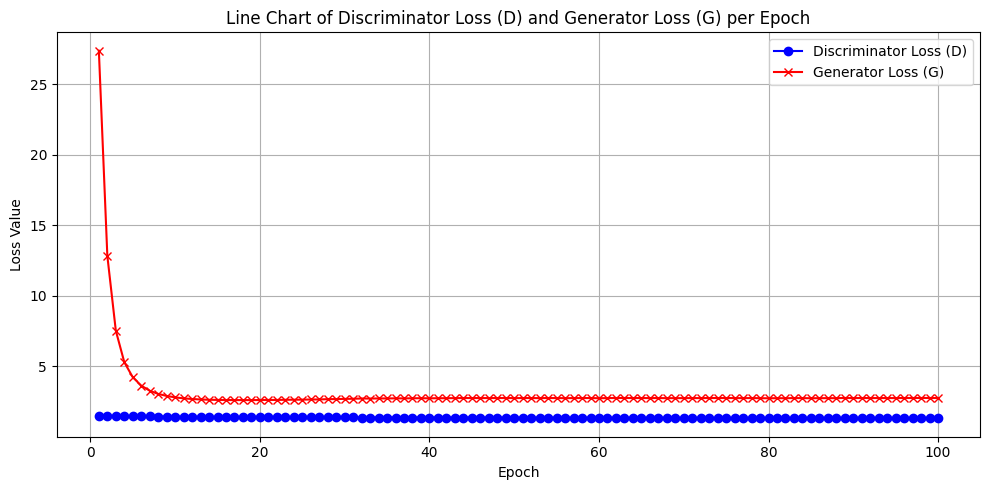

Model saved to models/EVOGRAPH/evograph_simulated_dom3
Average Time per Epoch: 27.07s
Average CPU Usage: 6.98GB
Average Memory Usage: 5.18GB
Average GPU Usage: 0.12GB

Total Training Time: 2706.87s
Max CPU Usage: 8.66GB
Max Memory Usage: 5.22GB
Max GPU Usage: 0.12GB


In [28]:
conv_size = adj_train_domain_3.shape[2]
hidden_size = conv_size*conv_size

sim_dom3_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom3_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
sim_dom3_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom3_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(sim_dom3_generator1)
print(sim_dom3_discriminator1)
n_generator_param = sim_dom3_generator1.count_parameters()
n_discriminator_param = sim_dom3_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(sim_dom3_generator1, sim_dom3_discriminator1, sim_dom3_generator2, sim_dom3_discriminator2,
            adj_train_domain_3, num_epochs=100, save_path="models/EVOGRAPH/evograph_simulated_dom3")

#### Domain 4

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492



Epoch 1/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [1/100]
D1 Loss: 0.75553, G1 Loss: 13.48364, R1 Loss: 0.57159, F1 Loss: 0.93948, MSE: 0.16768, MAE: 0.36878
D2 Loss: 0.74643, G2 Loss: 13.55670, R2 Loss: 0.55859, F2 Loss: 0.93427, MSE: 0.16733, MAE: 0.36855
Time: 27.37s, CPU: 6.25GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 2/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [2/100]
D1 Loss: 0.74178, G1 Loss: 6.37499, R1 Loss: 0.55400, F1 Loss: 0.92956, MSE: 0.06958, MAE: 0.23918
D2 Loss: 0.74327, G2 Loss: 6.34575, R2 Loss: 0.55693, F2 Loss: 0.92961, MSE: 0.06886, MAE: 0.23828
Time: 26.32s, CPU: 5.43GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 3/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [3/100]
D1 Loss: 0.73376, G1 Loss: 3.74995, R1 Loss: 0.54896, F1 Loss: 0.91855, MSE: 0.03387, MAE: 0.16520
D2 Loss: 0.73434, G2 Loss: 3.72075, R2 Loss: 0.55224, F2 Loss: 0.91643, MSE: 0.03347, MAE: 0.16393
Time: 26.47s, CPU: 6.28GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 4/100: 100%|██████████| 80/80 [00:25<00:00,  3.11it/s]


Epoch [4/100]
D1 Loss: 0.72879, G1 Loss: 2.64259, R1 Loss: 0.54754, F1 Loss: 0.91003, MSE: 0.01918, MAE: 0.12320
D2 Loss: 0.73020, G2 Loss: 2.63056, R2 Loss: 0.55146, F2 Loss: 0.90893, MSE: 0.01883, MAE: 0.12243
Time: 25.76s, CPU: 4.76GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 5/100: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Epoch [5/100]
D1 Loss: 0.72372, G1 Loss: 2.10040, R1 Loss: 0.54910, F1 Loss: 0.89835, MSE: 0.01208, MAE: 0.09666
D2 Loss: 0.72423, G2 Loss: 2.08937, R2 Loss: 0.55231, F2 Loss: 0.89616, MSE: 0.01189, MAE: 0.09553
Time: 26.18s, CPU: 5.67GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 6/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [6/100]
D1 Loss: 0.71976, G1 Loss: 1.81204, R1 Loss: 0.54996, F1 Loss: 0.88955, MSE: 0.00817, MAE: 0.07866
D2 Loss: 0.72122, G2 Loss: 1.79722, R2 Loss: 0.55457, F2 Loss: 0.88788, MSE: 0.00797, MAE: 0.07783
Time: 27.85s, CPU: 8.07GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 7/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [7/100]
D1 Loss: 0.71554, G1 Loss: 1.63167, R1 Loss: 0.55241, F1 Loss: 0.87868, MSE: 0.00589, MAE: 0.06616
D2 Loss: 0.71750, G2 Loss: 1.62297, R2 Loss: 0.55597, F2 Loss: 0.87903, MSE: 0.00580, MAE: 0.06532
Time: 26.23s, CPU: 5.08GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 8/100: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Epoch [8/100]
D1 Loss: 0.71237, G1 Loss: 1.51795, R1 Loss: 0.55571, F1 Loss: 0.86904, MSE: 0.00441, MAE: 0.05630
D2 Loss: 0.71552, G2 Loss: 1.51708, R2 Loss: 0.56001, F2 Loss: 0.87103, MSE: 0.00431, MAE: 0.05570
Time: 27.00s, CPU: 5.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 9/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [9/100]
D1 Loss: 0.70970, G1 Loss: 1.44425, R1 Loss: 0.55834, F1 Loss: 0.86105, MSE: 0.00338, MAE: 0.04917
D2 Loss: 0.71140, G2 Loss: 1.43715, R2 Loss: 0.56239, F2 Loss: 0.86040, MSE: 0.00330, MAE: 0.04856
Time: 27.32s, CPU: 7.58GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 10/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [10/100]
D1 Loss: 0.70926, G1 Loss: 1.39116, R1 Loss: 0.56366, F1 Loss: 0.85485, MSE: 0.00267, MAE: 0.04352
D2 Loss: 0.70910, G2 Loss: 1.38890, R2 Loss: 0.56661, F2 Loss: 0.85160, MSE: 0.00262, MAE: 0.04300
Time: 27.02s, CPU: 7.43GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 11/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [11/100]
D1 Loss: 0.70519, G1 Loss: 1.36121, R1 Loss: 0.56627, F1 Loss: 0.84411, MSE: 0.00217, MAE: 0.03881
D2 Loss: 0.70947, G2 Loss: 1.35391, R2 Loss: 0.56921, F2 Loss: 0.84973, MSE: 0.00214, MAE: 0.03830
Time: 26.39s, CPU: 6.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 12/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [12/100]
D1 Loss: 0.70526, G1 Loss: 1.33442, R1 Loss: 0.57043, F1 Loss: 0.84009, MSE: 0.00182, MAE: 0.03494
D2 Loss: 0.70531, G2 Loss: 1.32989, R2 Loss: 0.57387, F2 Loss: 0.83675, MSE: 0.00177, MAE: 0.03471
Time: 26.55s, CPU: 7.46GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 13/100: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]


Epoch [13/100]
D1 Loss: 0.70156, G1 Loss: 1.31781, R1 Loss: 0.57434, F1 Loss: 0.82879, MSE: 0.00152, MAE: 0.03190
D2 Loss: 0.70469, G2 Loss: 1.31632, R2 Loss: 0.57711, F2 Loss: 0.83227, MSE: 0.00149, MAE: 0.03148
Time: 25.89s, CPU: 5.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 14/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [14/100]
D1 Loss: 0.70098, G1 Loss: 1.30842, R1 Loss: 0.57772, F1 Loss: 0.82424, MSE: 0.00130, MAE: 0.02920
D2 Loss: 0.70180, G2 Loss: 1.30359, R2 Loss: 0.58140, F2 Loss: 0.82220, MSE: 0.00127, MAE: 0.02904
Time: 27.37s, CPU: 7.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 15/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [15/100]
D1 Loss: 0.69824, G1 Loss: 1.29878, R1 Loss: 0.58226, F1 Loss: 0.81423, MSE: 0.00111, MAE: 0.02703
D2 Loss: 0.70108, G2 Loss: 1.29890, R2 Loss: 0.58451, F2 Loss: 0.81766, MSE: 0.00110, MAE: 0.02686
Time: 26.94s, CPU: 6.84GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 16/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [16/100]
D1 Loss: 0.69422, G1 Loss: 1.29743, R1 Loss: 0.58533, F1 Loss: 0.80310, MSE: 0.00098, MAE: 0.02534
D2 Loss: 0.69898, G2 Loss: 1.28961, R2 Loss: 0.58804, F2 Loss: 0.80993, MSE: 0.00097, MAE: 0.02508
Time: 26.53s, CPU: 6.64GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 17/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [17/100]
D1 Loss: 0.69546, G1 Loss: 1.29866, R1 Loss: 0.58910, F1 Loss: 0.80182, MSE: 0.00087, MAE: 0.02382
D2 Loss: 0.70077, G2 Loss: 1.29153, R2 Loss: 0.59160, F2 Loss: 0.80994, MSE: 0.00088, MAE: 0.02388
Time: 26.69s, CPU: 6.43GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 18/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [18/100]
D1 Loss: 0.69263, G1 Loss: 1.30080, R1 Loss: 0.59376, F1 Loss: 0.79151, MSE: 0.00078, MAE: 0.02265
D2 Loss: 0.69716, G2 Loss: 1.29263, R2 Loss: 0.59441, F2 Loss: 0.79991, MSE: 0.00079, MAE: 0.02277
Time: 27.29s, CPU: 7.75GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 19/100: 100%|██████████| 80/80 [00:27<00:00,  2.93it/s]


Epoch [19/100]
D1 Loss: 0.69224, G1 Loss: 1.29969, R1 Loss: 0.59732, F1 Loss: 0.78715, MSE: 0.00071, MAE: 0.02149
D2 Loss: 0.69678, G2 Loss: 1.29292, R2 Loss: 0.59842, F2 Loss: 0.79514, MSE: 0.00072, MAE: 0.02159
Time: 27.28s, CPU: 6.64GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 20/100: 100%|██████████| 80/80 [00:27<00:00,  2.86it/s]


Epoch [20/100]
D1 Loss: 0.69145, G1 Loss: 1.30317, R1 Loss: 0.60063, F1 Loss: 0.78226, MSE: 0.00065, MAE: 0.02058
D2 Loss: 0.69653, G2 Loss: 1.29200, R2 Loss: 0.60136, F2 Loss: 0.79170, MSE: 0.00066, MAE: 0.02071
Time: 27.99s, CPU: 8.60GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 21/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [21/100]
D1 Loss: 0.69174, G1 Loss: 1.29974, R1 Loss: 0.60458, F1 Loss: 0.77890, MSE: 0.00060, MAE: 0.01978
D2 Loss: 0.69637, G2 Loss: 1.28928, R2 Loss: 0.60418, F2 Loss: 0.78856, MSE: 0.00061, MAE: 0.02011
Time: 27.04s, CPU: 6.99GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 22/100: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]


Epoch [22/100]
D1 Loss: 0.69136, G1 Loss: 1.30620, R1 Loss: 0.60701, F1 Loss: 0.77571, MSE: 0.00057, MAE: 0.01921
D2 Loss: 0.69901, G2 Loss: 1.28917, R2 Loss: 0.60799, F2 Loss: 0.79003, MSE: 0.00058, MAE: 0.01951
Time: 25.49s, CPU: 5.34GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 23/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [23/100]
D1 Loss: 0.69070, G1 Loss: 1.31008, R1 Loss: 0.61128, F1 Loss: 0.77012, MSE: 0.00054, MAE: 0.01854
D2 Loss: 0.70019, G2 Loss: 1.28509, R2 Loss: 0.61161, F2 Loss: 0.78877, MSE: 0.00056, MAE: 0.01904
Time: 27.57s, CPU: 7.40GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 24/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [24/100]
D1 Loss: 0.68935, G1 Loss: 1.31506, R1 Loss: 0.61459, F1 Loss: 0.76411, MSE: 0.00052, MAE: 0.01804
D2 Loss: 0.69839, G2 Loss: 1.29345, R2 Loss: 0.61659, F2 Loss: 0.78019, MSE: 0.00053, MAE: 0.01862
Time: 27.24s, CPU: 7.84GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 25/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [25/100]
D1 Loss: 0.68938, G1 Loss: 1.32068, R1 Loss: 0.61687, F1 Loss: 0.76188, MSE: 0.00049, MAE: 0.01754
D2 Loss: 0.69834, G2 Loss: 1.29532, R2 Loss: 0.61929, F2 Loss: 0.77739, MSE: 0.00051, MAE: 0.01815
Time: 27.91s, CPU: 7.52GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 26/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [26/100]
D1 Loss: 0.68694, G1 Loss: 1.32421, R1 Loss: 0.62027, F1 Loss: 0.75362, MSE: 0.00045, MAE: 0.01698
D2 Loss: 0.69603, G2 Loss: 1.30772, R2 Loss: 0.62277, F2 Loss: 0.76930, MSE: 0.00049, MAE: 0.01775
Time: 26.82s, CPU: 6.67GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 27/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [27/100]
D1 Loss: 0.68901, G1 Loss: 1.32739, R1 Loss: 0.62231, F1 Loss: 0.75572, MSE: 0.00044, MAE: 0.01656
D2 Loss: 0.69254, G2 Loss: 1.31535, R2 Loss: 0.62544, F2 Loss: 0.75964, MSE: 0.00046, MAE: 0.01724
Time: 26.63s, CPU: 6.49GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 28/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [28/100]
D1 Loss: 0.68789, G1 Loss: 1.32550, R1 Loss: 0.62500, F1 Loss: 0.75078, MSE: 0.00044, MAE: 0.01641
D2 Loss: 0.69013, G2 Loss: 1.32200, R2 Loss: 0.62758, F2 Loss: 0.75267, MSE: 0.00043, MAE: 0.01670
Time: 26.70s, CPU: 7.34GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 29/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [29/100]
D1 Loss: 0.69011, G1 Loss: 1.32828, R1 Loss: 0.62670, F1 Loss: 0.75352, MSE: 0.00042, MAE: 0.01615
D2 Loss: 0.68861, G2 Loss: 1.33233, R2 Loss: 0.62926, F2 Loss: 0.74795, MSE: 0.00042, MAE: 0.01643
Time: 26.90s, CPU: 7.46GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 30/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [30/100]
D1 Loss: 0.68799, G1 Loss: 1.32759, R1 Loss: 0.62836, F1 Loss: 0.74761, MSE: 0.00042, MAE: 0.01587
D2 Loss: 0.68972, G2 Loss: 1.34072, R2 Loss: 0.63183, F2 Loss: 0.74761, MSE: 0.00040, MAE: 0.01605
Time: 27.62s, CPU: 6.43GB, Memory: 5.22GB, GPU: 0.12GB



Epoch 31/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [31/100]
D1 Loss: 0.68826, G1 Loss: 1.33212, R1 Loss: 0.63050, F1 Loss: 0.74602, MSE: 0.00040, MAE: 0.01549
D2 Loss: 0.68705, G2 Loss: 1.34118, R2 Loss: 0.63376, F2 Loss: 0.74033, MSE: 0.00038, MAE: 0.01556
Time: 26.29s, CPU: 5.96GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 32/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [32/100]
D1 Loss: 0.68900, G1 Loss: 1.33495, R1 Loss: 0.63298, F1 Loss: 0.74502, MSE: 0.00040, MAE: 0.01531
D2 Loss: 0.68683, G2 Loss: 1.34624, R2 Loss: 0.63673, F2 Loss: 0.73694, MSE: 0.00035, MAE: 0.01506
Time: 26.60s, CPU: 7.22GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 33/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [33/100]
D1 Loss: 0.68801, G1 Loss: 1.34216, R1 Loss: 0.63443, F1 Loss: 0.74158, MSE: 0.00038, MAE: 0.01485
D2 Loss: 0.68614, G2 Loss: 1.35449, R2 Loss: 0.63870, F2 Loss: 0.73358, MSE: 0.00035, MAE: 0.01475
Time: 27.42s, CPU: 7.40GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 34/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [34/100]
D1 Loss: 0.68537, G1 Loss: 1.34479, R1 Loss: 0.63444, F1 Loss: 0.73629, MSE: 0.00036, MAE: 0.01465
D2 Loss: 0.68504, G2 Loss: 1.35363, R2 Loss: 0.64007, F2 Loss: 0.73001, MSE: 0.00033, MAE: 0.01456
Time: 26.53s, CPU: 6.67GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 35/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [35/100]
D1 Loss: 0.68277, G1 Loss: 1.35323, R1 Loss: 0.63400, F1 Loss: 0.73155, MSE: 0.00036, MAE: 0.01456
D2 Loss: 0.68461, G2 Loss: 1.35439, R2 Loss: 0.64064, F2 Loss: 0.72859, MSE: 0.00032, MAE: 0.01416
Time: 27.24s, CPU: 7.63GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 36/100: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]


Epoch [36/100]
D1 Loss: 0.68092, G1 Loss: 1.35414, R1 Loss: 0.63321, F1 Loss: 0.72864, MSE: 0.00037, MAE: 0.01478
D2 Loss: 0.68577, G2 Loss: 1.35717, R2 Loss: 0.64254, F2 Loss: 0.72901, MSE: 0.00031, MAE: 0.01393
Time: 28.28s, CPU: 8.13GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 37/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [37/100]
D1 Loss: 0.67949, G1 Loss: 1.36409, R1 Loss: 0.63362, F1 Loss: 0.72536, MSE: 0.00034, MAE: 0.01445
D2 Loss: 0.68399, G2 Loss: 1.36199, R2 Loss: 0.64331, F2 Loss: 0.72468, MSE: 0.00030, MAE: 0.01376
Time: 27.50s, CPU: 7.28GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 38/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [38/100]
D1 Loss: 0.67851, G1 Loss: 1.36805, R1 Loss: 0.63324, F1 Loss: 0.72379, MSE: 0.00035, MAE: 0.01427
D2 Loss: 0.68345, G2 Loss: 1.36880, R2 Loss: 0.64554, F2 Loss: 0.72137, MSE: 0.00029, MAE: 0.01342
Time: 26.84s, CPU: 6.75GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 39/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [39/100]
D1 Loss: 0.67777, G1 Loss: 1.36643, R1 Loss: 0.63444, F1 Loss: 0.72111, MSE: 0.00033, MAE: 0.01415
D2 Loss: 0.68226, G2 Loss: 1.36719, R2 Loss: 0.64516, F2 Loss: 0.71937, MSE: 0.00028, MAE: 0.01316
Time: 27.37s, CPU: 7.96GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 40/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [40/100]
D1 Loss: 0.67759, G1 Loss: 1.36773, R1 Loss: 0.63483, F1 Loss: 0.72035, MSE: 0.00034, MAE: 0.01393
D2 Loss: 0.68244, G2 Loss: 1.37234, R2 Loss: 0.64525, F2 Loss: 0.71963, MSE: 0.00028, MAE: 0.01306
Time: 26.52s, CPU: 6.96GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 41/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [41/100]
D1 Loss: 0.67886, G1 Loss: 1.36613, R1 Loss: 0.63528, F1 Loss: 0.72244, MSE: 0.00031, MAE: 0.01366
D2 Loss: 0.68299, G2 Loss: 1.37143, R2 Loss: 0.64627, F2 Loss: 0.71971, MSE: 0.00027, MAE: 0.01288
Time: 27.51s, CPU: 7.90GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 42/100: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Epoch [42/100]
D1 Loss: 0.67854, G1 Loss: 1.37305, R1 Loss: 0.63778, F1 Loss: 0.71929, MSE: 0.00031, MAE: 0.01359
D2 Loss: 0.68135, G2 Loss: 1.37580, R2 Loss: 0.64598, F2 Loss: 0.71671, MSE: 0.00027, MAE: 0.01264
Time: 27.54s, CPU: 7.19GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 43/100: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]


Epoch [43/100]
D1 Loss: 0.67862, G1 Loss: 1.37501, R1 Loss: 0.63920, F1 Loss: 0.71804, MSE: 0.00029, MAE: 0.01337
D2 Loss: 0.68107, G2 Loss: 1.37467, R2 Loss: 0.64721, F2 Loss: 0.71494, MSE: 0.00026, MAE: 0.01262
Time: 27.44s, CPU: 7.75GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 44/100: 100%|██████████| 80/80 [00:26<00:00,  2.98it/s]


Epoch [44/100]
D1 Loss: 0.67910, G1 Loss: 1.37413, R1 Loss: 0.63983, F1 Loss: 0.71838, MSE: 0.00029, MAE: 0.01312
D2 Loss: 0.68129, G2 Loss: 1.37441, R2 Loss: 0.64707, F2 Loss: 0.71551, MSE: 0.00026, MAE: 0.01239
Time: 26.84s, CPU: 7.28GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 45/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [45/100]
D1 Loss: 0.67780, G1 Loss: 1.37386, R1 Loss: 0.63820, F1 Loss: 0.71741, MSE: 0.00027, MAE: 0.01271
D2 Loss: 0.68002, G2 Loss: 1.37682, R2 Loss: 0.64614, F2 Loss: 0.71391, MSE: 0.00025, MAE: 0.01224
Time: 26.37s, CPU: 5.76GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 46/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [46/100]
D1 Loss: 0.67754, G1 Loss: 1.37542, R1 Loss: 0.63942, F1 Loss: 0.71567, MSE: 0.00028, MAE: 0.01295
D2 Loss: 0.67815, G2 Loss: 1.37720, R2 Loss: 0.64423, F2 Loss: 0.71208, MSE: 0.00025, MAE: 0.01231
Time: 27.10s, CPU: 6.84GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 47/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [47/100]
D1 Loss: 0.67784, G1 Loss: 1.37902, R1 Loss: 0.64005, F1 Loss: 0.71563, MSE: 0.00028, MAE: 0.01291
D2 Loss: 0.67762, G2 Loss: 1.37716, R2 Loss: 0.64363, F2 Loss: 0.71162, MSE: 0.00025, MAE: 0.01214
Time: 27.89s, CPU: 8.34GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 48/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [48/100]
D1 Loss: 0.67595, G1 Loss: 1.37853, R1 Loss: 0.63882, F1 Loss: 0.71309, MSE: 0.00025, MAE: 0.01240
D2 Loss: 0.67916, G2 Loss: 1.37555, R2 Loss: 0.64279, F2 Loss: 0.71552, MSE: 0.00024, MAE: 0.01191
Time: 27.16s, CPU: 7.96GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 49/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [49/100]
D1 Loss: 0.67505, G1 Loss: 1.37683, R1 Loss: 0.63750, F1 Loss: 0.71260, MSE: 0.00025, MAE: 0.01223
D2 Loss: 0.67831, G2 Loss: 1.37641, R2 Loss: 0.64395, F2 Loss: 0.71268, MSE: 0.00024, MAE: 0.01185
Time: 27.73s, CPU: 8.69GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 50/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [50/100]
D1 Loss: 0.67620, G1 Loss: 1.37712, R1 Loss: 0.63793, F1 Loss: 0.71448, MSE: 0.00025, MAE: 0.01213
D2 Loss: 0.67730, G2 Loss: 1.37568, R2 Loss: 0.64295, F2 Loss: 0.71165, MSE: 0.00024, MAE: 0.01186
Time: 27.47s, CPU: 6.87GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 51/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [51/100]
D1 Loss: 0.67505, G1 Loss: 1.37871, R1 Loss: 0.63681, F1 Loss: 0.71329, MSE: 0.00026, MAE: 0.01217
D2 Loss: 0.67749, G2 Loss: 1.37953, R2 Loss: 0.64131, F2 Loss: 0.71368, MSE: 0.00024, MAE: 0.01185
Time: 26.76s, CPU: 6.78GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 52/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [52/100]
D1 Loss: 0.67386, G1 Loss: 1.38017, R1 Loss: 0.63402, F1 Loss: 0.71370, MSE: 0.00026, MAE: 0.01203
D2 Loss: 0.67618, G2 Loss: 1.37867, R2 Loss: 0.64104, F2 Loss: 0.71133, MSE: 0.00023, MAE: 0.01168
Time: 27.09s, CPU: 6.40GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 53/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [53/100]
D1 Loss: 0.67312, G1 Loss: 1.38020, R1 Loss: 0.63555, F1 Loss: 0.71069, MSE: 0.00025, MAE: 0.01202
D2 Loss: 0.67582, G2 Loss: 1.37845, R2 Loss: 0.64002, F2 Loss: 0.71161, MSE: 0.00023, MAE: 0.01153
Time: 26.29s, CPU: 5.96GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 54/100: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Epoch [54/100]
D1 Loss: 0.67380, G1 Loss: 1.37612, R1 Loss: 0.63202, F1 Loss: 0.71559, MSE: 0.00026, MAE: 0.01205
D2 Loss: 0.67405, G2 Loss: 1.37811, R2 Loss: 0.63867, F2 Loss: 0.70942, MSE: 0.00024, MAE: 0.01179
Time: 26.21s, CPU: 5.93GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 55/100: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch [55/100]
D1 Loss: 0.67295, G1 Loss: 1.37820, R1 Loss: 0.63205, F1 Loss: 0.71386, MSE: 0.00023, MAE: 0.01167
D2 Loss: 0.67447, G2 Loss: 1.38026, R2 Loss: 0.63642, F2 Loss: 0.71252, MSE: 0.00022, MAE: 0.01156
Time: 27.77s, CPU: 7.58GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 56/100: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]


Epoch [56/100]
D1 Loss: 0.67462, G1 Loss: 1.37492, R1 Loss: 0.63397, F1 Loss: 0.71526, MSE: 0.00025, MAE: 0.01187
D2 Loss: 0.67266, G2 Loss: 1.37952, R2 Loss: 0.63505, F2 Loss: 0.71027, MSE: 0.00023, MAE: 0.01153
Time: 26.53s, CPU: 6.08GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 57/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [57/100]
D1 Loss: 0.67410, G1 Loss: 1.37067, R1 Loss: 0.63262, F1 Loss: 0.71558, MSE: 0.00024, MAE: 0.01168
D2 Loss: 0.67280, G2 Loss: 1.37720, R2 Loss: 0.63462, F2 Loss: 0.71098, MSE: 0.00022, MAE: 0.01141
Time: 27.52s, CPU: 8.31GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 58/100: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]


Epoch [58/100]
D1 Loss: 0.67312, G1 Loss: 1.37763, R1 Loss: 0.63430, F1 Loss: 0.71193, MSE: 0.00024, MAE: 0.01168
D2 Loss: 0.67226, G2 Loss: 1.37881, R2 Loss: 0.63304, F2 Loss: 0.71148, MSE: 0.00023, MAE: 0.01147
Time: 28.10s, CPU: 8.63GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 59/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [59/100]
D1 Loss: 0.67185, G1 Loss: 1.38400, R1 Loss: 0.63296, F1 Loss: 0.71075, MSE: 0.00024, MAE: 0.01203
D2 Loss: 0.67200, G2 Loss: 1.38005, R2 Loss: 0.63234, F2 Loss: 0.71165, MSE: 0.00022, MAE: 0.01142
Time: 27.09s, CPU: 8.16GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 60/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [60/100]
D1 Loss: 0.67442, G1 Loss: 1.38194, R1 Loss: 0.63263, F1 Loss: 0.71620, MSE: 0.00024, MAE: 0.01210
D2 Loss: 0.67216, G2 Loss: 1.37923, R2 Loss: 0.63101, F2 Loss: 0.71331, MSE: 0.00022, MAE: 0.01145
Time: 27.70s, CPU: 8.02GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 61/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [61/100]
D1 Loss: 0.67267, G1 Loss: 1.37906, R1 Loss: 0.63228, F1 Loss: 0.71306, MSE: 0.00025, MAE: 0.01214
D2 Loss: 0.67078, G2 Loss: 1.37267, R2 Loss: 0.62982, F2 Loss: 0.71174, MSE: 0.00023, MAE: 0.01154
Time: 26.67s, CPU: 5.99GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 62/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [62/100]
D1 Loss: 0.67196, G1 Loss: 1.38181, R1 Loss: 0.63124, F1 Loss: 0.71268, MSE: 0.00027, MAE: 0.01221
D2 Loss: 0.67153, G2 Loss: 1.38045, R2 Loss: 0.63028, F2 Loss: 0.71279, MSE: 0.00023, MAE: 0.01158
Time: 26.34s, CPU: 5.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 63/100: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]


Epoch [63/100]
D1 Loss: 0.67222, G1 Loss: 1.38171, R1 Loss: 0.63216, F1 Loss: 0.71227, MSE: 0.00023, MAE: 0.01165
D2 Loss: 0.67141, G2 Loss: 1.37565, R2 Loss: 0.62941, F2 Loss: 0.71341, MSE: 0.00023, MAE: 0.01153
Time: 28.06s, CPU: 7.84GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 64/100: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Epoch [64/100]
D1 Loss: 0.67060, G1 Loss: 1.38207, R1 Loss: 0.63080, F1 Loss: 0.71039, MSE: 0.00024, MAE: 0.01195
D2 Loss: 0.67030, G2 Loss: 1.37667, R2 Loss: 0.62862, F2 Loss: 0.71199, MSE: 0.00023, MAE: 0.01142
Time: 26.11s, CPU: 5.46GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 65/100: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Epoch [65/100]
D1 Loss: 0.67228, G1 Loss: 1.37537, R1 Loss: 0.62851, F1 Loss: 0.71604, MSE: 0.00025, MAE: 0.01208
D2 Loss: 0.66874, G2 Loss: 1.37576, R2 Loss: 0.62671, F2 Loss: 0.71078, MSE: 0.00023, MAE: 0.01159
Time: 26.99s, CPU: 5.34GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 66/100: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s]


Epoch [66/100]
D1 Loss: 0.66952, G1 Loss: 1.38116, R1 Loss: 0.62420, F1 Loss: 0.71484, MSE: 0.00029, MAE: 0.01277
D2 Loss: 0.66844, G2 Loss: 1.37860, R2 Loss: 0.62616, F2 Loss: 0.71072, MSE: 0.00022, MAE: 0.01144
Time: 26.74s, CPU: 6.31GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 67/100: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Epoch [67/100]
D1 Loss: 0.66934, G1 Loss: 1.37339, R1 Loss: 0.62286, F1 Loss: 0.71582, MSE: 0.00027, MAE: 0.01241
D2 Loss: 0.66813, G2 Loss: 1.37816, R2 Loss: 0.62564, F2 Loss: 0.71062, MSE: 0.00022, MAE: 0.01147
Time: 26.11s, CPU: 5.73GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 68/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [68/100]
D1 Loss: 0.67123, G1 Loss: 1.37507, R1 Loss: 0.62477, F1 Loss: 0.71770, MSE: 0.00027, MAE: 0.01240
D2 Loss: 0.66849, G2 Loss: 1.38187, R2 Loss: 0.62529, F2 Loss: 0.71169, MSE: 0.00022, MAE: 0.01137
Time: 28.19s, CPU: 8.34GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 69/100: 100%|██████████| 80/80 [00:26<00:00,  2.96it/s]


Epoch [69/100]
D1 Loss: 0.67319, G1 Loss: 1.37029, R1 Loss: 0.62443, F1 Loss: 0.72194, MSE: 0.00029, MAE: 0.01280
D2 Loss: 0.66878, G2 Loss: 1.37942, R2 Loss: 0.62389, F2 Loss: 0.71367, MSE: 0.00022, MAE: 0.01136
Time: 26.99s, CPU: 7.52GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 70/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [70/100]
D1 Loss: 0.67274, G1 Loss: 1.36812, R1 Loss: 0.62301, F1 Loss: 0.72247, MSE: 0.00029, MAE: 0.01276
D2 Loss: 0.66709, G2 Loss: 1.37184, R2 Loss: 0.62305, F2 Loss: 0.71112, MSE: 0.00022, MAE: 0.01129
Time: 26.69s, CPU: 6.31GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 71/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [71/100]
D1 Loss: 0.67053, G1 Loss: 1.37515, R1 Loss: 0.62474, F1 Loss: 0.71633, MSE: 0.00027, MAE: 0.01241
D2 Loss: 0.66606, G2 Loss: 1.38166, R2 Loss: 0.62172, F2 Loss: 0.71040, MSE: 0.00023, MAE: 0.01153
Time: 27.24s, CPU: 7.46GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 72/100: 100%|██████████| 80/80 [00:28<00:00,  2.86it/s]


Epoch [72/100]
D1 Loss: 0.67116, G1 Loss: 1.36910, R1 Loss: 0.62533, F1 Loss: 0.71699, MSE: 0.00029, MAE: 0.01268
D2 Loss: 0.66598, G2 Loss: 1.38058, R2 Loss: 0.61967, F2 Loss: 0.71230, MSE: 0.00024, MAE: 0.01156
Time: 28.01s, CPU: 7.90GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 73/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [73/100]
D1 Loss: 0.66948, G1 Loss: 1.37004, R1 Loss: 0.62337, F1 Loss: 0.71560, MSE: 0.00028, MAE: 0.01294
D2 Loss: 0.66511, G2 Loss: 1.38009, R2 Loss: 0.61963, F2 Loss: 0.71058, MSE: 0.00023, MAE: 0.01140
Time: 26.92s, CPU: 7.96GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 74/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [74/100]
D1 Loss: 0.67038, G1 Loss: 1.37400, R1 Loss: 0.62198, F1 Loss: 0.71877, MSE: 0.00029, MAE: 0.01246
D2 Loss: 0.66445, G2 Loss: 1.38185, R2 Loss: 0.61859, F2 Loss: 0.71030, MSE: 0.00022, MAE: 0.01132
Time: 26.95s, CPU: 5.96GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 75/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [75/100]
D1 Loss: 0.67013, G1 Loss: 1.37346, R1 Loss: 0.62405, F1 Loss: 0.71620, MSE: 0.00028, MAE: 0.01249
D2 Loss: 0.66371, G2 Loss: 1.37757, R2 Loss: 0.61660, F2 Loss: 0.71082, MSE: 0.00023, MAE: 0.01159
Time: 27.24s, CPU: 6.75GB, Memory: 5.16GB, GPU: 0.12GB



Epoch 76/100: 100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Epoch [76/100]
D1 Loss: 0.66935, G1 Loss: 1.37474, R1 Loss: 0.62311, F1 Loss: 0.71560, MSE: 0.00028, MAE: 0.01279
D2 Loss: 0.66415, G2 Loss: 1.37717, R2 Loss: 0.61623, F2 Loss: 0.71206, MSE: 0.00022, MAE: 0.01152
Time: 27.22s, CPU: 7.05GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 77/100: 100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epoch [77/100]
D1 Loss: 0.66871, G1 Loss: 1.37183, R1 Loss: 0.62138, F1 Loss: 0.71604, MSE: 0.00029, MAE: 0.01267
D2 Loss: 0.66413, G2 Loss: 1.37673, R2 Loss: 0.61642, F2 Loss: 0.71184, MSE: 0.00023, MAE: 0.01145
Time: 25.53s, CPU: 6.08GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 78/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [78/100]
D1 Loss: 0.66970, G1 Loss: 1.37803, R1 Loss: 0.62416, F1 Loss: 0.71525, MSE: 0.00028, MAE: 0.01294
D2 Loss: 0.66345, G2 Loss: 1.37992, R2 Loss: 0.61522, F2 Loss: 0.71168, MSE: 0.00022, MAE: 0.01138
Time: 26.40s, CPU: 5.87GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 79/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [79/100]
D1 Loss: 0.66933, G1 Loss: 1.37860, R1 Loss: 0.62186, F1 Loss: 0.71679, MSE: 0.00030, MAE: 0.01339
D2 Loss: 0.66285, G2 Loss: 1.37641, R2 Loss: 0.61325, F2 Loss: 0.71245, MSE: 0.00023, MAE: 0.01159
Time: 27.13s, CPU: 6.87GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 80/100: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s]


Epoch [80/100]
D1 Loss: 0.66792, G1 Loss: 1.38089, R1 Loss: 0.62083, F1 Loss: 0.71501, MSE: 0.00028, MAE: 0.01289
D2 Loss: 0.66328, G2 Loss: 1.38006, R2 Loss: 0.61455, F2 Loss: 0.71200, MSE: 0.00023, MAE: 0.01143
Time: 26.29s, CPU: 6.61GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 81/100: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s]


Epoch [81/100]
D1 Loss: 0.66880, G1 Loss: 1.38127, R1 Loss: 0.62253, F1 Loss: 0.71508, MSE: 0.00031, MAE: 0.01348
D2 Loss: 0.66321, G2 Loss: 1.37738, R2 Loss: 0.61329, F2 Loss: 0.71313, MSE: 0.00022, MAE: 0.01142
Time: 25.15s, CPU: 5.02GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 82/100: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Epoch [82/100]
D1 Loss: 0.66833, G1 Loss: 1.38392, R1 Loss: 0.62172, F1 Loss: 0.71494, MSE: 0.00032, MAE: 0.01346
D2 Loss: 0.66242, G2 Loss: 1.37738, R2 Loss: 0.61257, F2 Loss: 0.71228, MSE: 0.00023, MAE: 0.01156
Time: 26.17s, CPU: 5.31GB, Memory: 5.21GB, GPU: 0.12GB



Epoch 83/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [83/100]
D1 Loss: 0.66763, G1 Loss: 1.38007, R1 Loss: 0.62037, F1 Loss: 0.71489, MSE: 0.00027, MAE: 0.01303
D2 Loss: 0.65961, G2 Loss: 1.37513, R2 Loss: 0.61060, F2 Loss: 0.70861, MSE: 0.00022, MAE: 0.01131
Time: 27.66s, CPU: 8.43GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 84/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [84/100]
D1 Loss: 0.66694, G1 Loss: 1.38528, R1 Loss: 0.62390, F1 Loss: 0.70999, MSE: 0.00026, MAE: 0.01279
D2 Loss: 0.66087, G2 Loss: 1.37856, R2 Loss: 0.60961, F2 Loss: 0.71214, MSE: 0.00023, MAE: 0.01153
Time: 27.16s, CPU: 6.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 85/100: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]


Epoch [85/100]
D1 Loss: 0.66604, G1 Loss: 1.37687, R1 Loss: 0.61988, F1 Loss: 0.71219, MSE: 0.00029, MAE: 0.01315
D2 Loss: 0.65981, G2 Loss: 1.38370, R2 Loss: 0.60847, F2 Loss: 0.71115, MSE: 0.00025, MAE: 0.01194
Time: 26.94s, CPU: 7.37GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 86/100: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Epoch [86/100]
D1 Loss: 0.66614, G1 Loss: 1.38691, R1 Loss: 0.61755, F1 Loss: 0.71472, MSE: 0.00030, MAE: 0.01306
D2 Loss: 0.66107, G2 Loss: 1.38004, R2 Loss: 0.60735, F2 Loss: 0.71480, MSE: 0.00024, MAE: 0.01181
Time: 27.46s, CPU: 7.61GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 87/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [87/100]
D1 Loss: 0.66546, G1 Loss: 1.38330, R1 Loss: 0.61677, F1 Loss: 0.71415, MSE: 0.00035, MAE: 0.01361
D2 Loss: 0.65873, G2 Loss: 1.37971, R2 Loss: 0.60822, F2 Loss: 0.70925, MSE: 0.00023, MAE: 0.01161
Time: 27.13s, CPU: 6.93GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 88/100: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s]


Epoch [88/100]
D1 Loss: 0.66491, G1 Loss: 1.38522, R1 Loss: 0.61610, F1 Loss: 0.71371, MSE: 0.00027, MAE: 0.01258
D2 Loss: 0.65886, G2 Loss: 1.38208, R2 Loss: 0.60641, F2 Loss: 0.71130, MSE: 0.00023, MAE: 0.01140
Time: 26.40s, CPU: 5.99GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 89/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [89/100]
D1 Loss: 0.66364, G1 Loss: 1.38762, R1 Loss: 0.61580, F1 Loss: 0.71147, MSE: 0.00026, MAE: 0.01263
D2 Loss: 0.65878, G2 Loss: 1.38218, R2 Loss: 0.60649, F2 Loss: 0.71108, MSE: 0.00023, MAE: 0.01148
Time: 26.70s, CPU: 6.43GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 90/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [90/100]
D1 Loss: 0.66321, G1 Loss: 1.38205, R1 Loss: 0.61325, F1 Loss: 0.71318, MSE: 0.00029, MAE: 0.01307
D2 Loss: 0.65773, G2 Loss: 1.37598, R2 Loss: 0.60565, F2 Loss: 0.70981, MSE: 0.00023, MAE: 0.01143
Time: 26.59s, CPU: 6.17GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 91/100: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


Epoch [91/100]
D1 Loss: 0.66351, G1 Loss: 1.38090, R1 Loss: 0.61194, F1 Loss: 0.71507, MSE: 0.00029, MAE: 0.01328
D2 Loss: 0.65760, G2 Loss: 1.37745, R2 Loss: 0.60488, F2 Loss: 0.71032, MSE: 0.00023, MAE: 0.01156
Time: 26.17s, CPU: 5.49GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 92/100: 100%|██████████| 80/80 [00:27<00:00,  2.96it/s]


Epoch [92/100]
D1 Loss: 0.66142, G1 Loss: 1.38126, R1 Loss: 0.60947, F1 Loss: 0.71336, MSE: 0.00029, MAE: 0.01297
D2 Loss: 0.65613, G2 Loss: 1.38091, R2 Loss: 0.60306, F2 Loss: 0.70920, MSE: 0.00023, MAE: 0.01151
Time: 27.07s, CPU: 6.17GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 93/100: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


Epoch [93/100]
D1 Loss: 0.66173, G1 Loss: 1.38298, R1 Loss: 0.60887, F1 Loss: 0.71459, MSE: 0.00029, MAE: 0.01320
D2 Loss: 0.65576, G2 Loss: 1.37323, R2 Loss: 0.60274, F2 Loss: 0.70878, MSE: 0.00023, MAE: 0.01144
Time: 27.08s, CPU: 6.75GB, Memory: 5.20GB, GPU: 0.12GB



Epoch 94/100: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]


Epoch [94/100]
D1 Loss: 0.66369, G1 Loss: 1.38733, R1 Loss: 0.61119, F1 Loss: 0.71618, MSE: 0.00029, MAE: 0.01329
D2 Loss: 0.65677, G2 Loss: 1.37732, R2 Loss: 0.60109, F2 Loss: 0.71244, MSE: 0.00024, MAE: 0.01161
Time: 28.30s, CPU: 7.37GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 95/100: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch [95/100]
D1 Loss: 0.66304, G1 Loss: 1.38653, R1 Loss: 0.61128, F1 Loss: 0.71479, MSE: 0.00027, MAE: 0.01282
D2 Loss: 0.65454, G2 Loss: 1.37777, R2 Loss: 0.60099, F2 Loss: 0.70809, MSE: 0.00023, MAE: 0.01156
Time: 27.92s, CPU: 8.07GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 96/100: 100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epoch [96/100]
D1 Loss: 0.66018, G1 Loss: 1.38472, R1 Loss: 0.60835, F1 Loss: 0.71201, MSE: 0.00026, MAE: 0.01275
D2 Loss: 0.65639, G2 Loss: 1.37740, R2 Loss: 0.59968, F2 Loss: 0.71311, MSE: 0.00023, MAE: 0.01147
Time: 25.53s, CPU: 5.40GB, Memory: 5.17GB, GPU: 0.12GB



Epoch 97/100: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


Epoch [97/100]
D1 Loss: 0.65989, G1 Loss: 1.38801, R1 Loss: 0.60858, F1 Loss: 0.71119, MSE: 0.00026, MAE: 0.01265
D2 Loss: 0.65365, G2 Loss: 1.38222, R2 Loss: 0.60183, F2 Loss: 0.70547, MSE: 0.00023, MAE: 0.01156
Time: 26.64s, CPU: 5.76GB, Memory: 5.19GB, GPU: 0.12GB



Epoch 98/100: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


Epoch [98/100]
D1 Loss: 0.65774, G1 Loss: 1.38398, R1 Loss: 0.60682, F1 Loss: 0.70866, MSE: 0.00024, MAE: 0.01247
D2 Loss: 0.65289, G2 Loss: 1.38635, R2 Loss: 0.59902, F2 Loss: 0.70676, MSE: 0.00023, MAE: 0.01132
Time: 26.55s, CPU: 6.34GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 99/100: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]


Epoch [99/100]
D1 Loss: 0.65867, G1 Loss: 1.38452, R1 Loss: 0.60823, F1 Loss: 0.70911, MSE: 0.00025, MAE: 0.01236
D2 Loss: 0.65504, G2 Loss: 1.38125, R2 Loss: 0.59764, F2 Loss: 0.71245, MSE: 0.00023, MAE: 0.01147
Time: 28.19s, CPU: 8.22GB, Memory: 5.18GB, GPU: 0.12GB



Epoch 100/100: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]


Epoch [100/100]
D1 Loss: 0.65531, G1 Loss: 1.38171, R1 Loss: 0.60412, F1 Loss: 0.70650, MSE: 0.00026, MAE: 0.01255
D2 Loss: 0.65361, G2 Loss: 1.38090, R2 Loss: 0.59675, F2 Loss: 0.71046, MSE: 0.00024, MAE: 0.01174
Time: 27.65s, CPU: 8.57GB, Memory: 5.19GB, GPU: 0.12GB



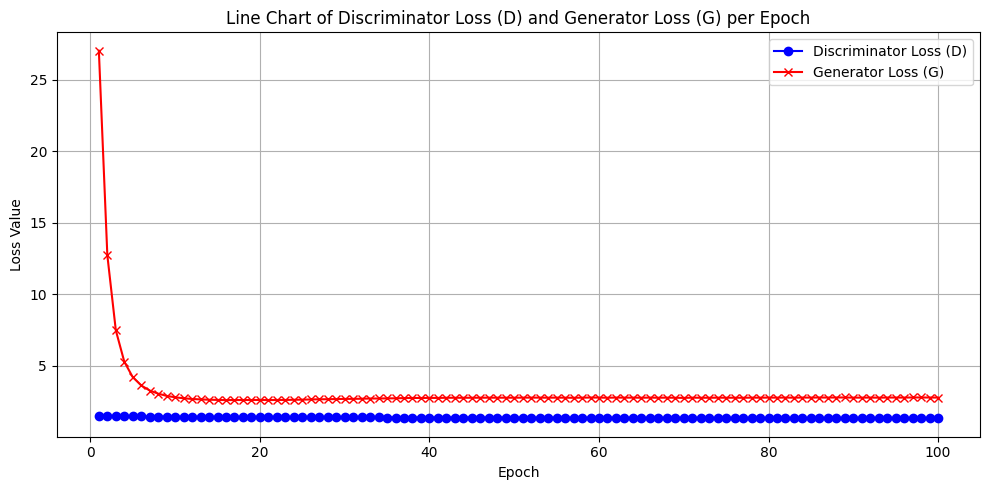

Model saved to models/EVOGRAPH/evograph_simulated_dom4
Average Time per Epoch: 26.97s
Average CPU Usage: 6.87GB
Average Memory Usage: 5.18GB
Average GPU Usage: 0.12GB

Total Training Time: 2697.37s
Max CPU Usage: 8.69GB
Max Memory Usage: 5.22GB
Max GPU Usage: 0.12GB


In [29]:
conv_size = adj_train_domain_4.shape[2]
hidden_size = conv_size*conv_size

sim_dom4_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom4_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
sim_dom4_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom4_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(sim_dom4_generator1)
print(sim_dom4_discriminator1)
n_generator_param = sim_dom4_generator1.count_parameters()
n_discriminator_param = sim_dom4_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(sim_dom4_generator1, sim_dom4_discriminator1, sim_dom4_generator2, sim_dom4_discriminator2,
            adj_train_domain_4, num_epochs=100, save_path="models/EVOGRAPH/evograph_simulated_dom4")

### SLIM Dataset

In [15]:
conv_size = adj_train_slim160.shape[2]
hidden_size = conv_size*conv_size

slim160_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
slim160_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
slim160_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
slim160_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(slim160_generator1)
print(slim160_discriminator1)
n_generator_param = slim160_generator1.count_parameters()
n_discriminator_param = slim160_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(slim160_generator1, slim160_discriminator1, slim160_generator2, slim160_discriminator2,
            adj_train_slim160, num_epochs=100, save_path="models/EVOGRAPH/evograph_slim160")

EvoGenerator(
  (conv1): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=25600, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(160)
  (conv2): NNConv(160, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(160)
)
EvoDiscriminator(
  (conv1): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=25600, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(160)
  (conv2): NNConv(160, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 364492



Epoch 1/100:   0%|          | 0/87 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.89 GiB of which 582.69 MiB is free. Process 3248824 has 15.32 GiB memory in use. Of the allocated memory 12.47 GiB is allocated by PyTorch, and 2.25 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### GmTE-Net

In [ ]:
class GCN(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class Encoder(nn.Module):
    def __init__(self, nfeat, nhid1, nhid2, dropout):

        super(Encoder, self).__init__()

        self.dropout = dropout
        self.gc1 = GCN(nfeat, nhid1)
        self.gc2 = GCN(nhid1, nhid2)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x


class Decoder_SR(nn.Module):
    """
    Decoder Network for Super-Resolution Brain Evolution Trajectory
    """
    def __init__(self, nhid1, nhid2, noutSR, dropout, timepoints):

        super(Decoder_SR, self).__init__()

        self.dropout = dropout
        self.timepoints = timepoints

        self.gc1 = GCN(nhid1, nhid2)
        self.gc2 = GCN(nhid2, noutSR)
        self.gc3 = GCN(noutSR, noutSR)

    def forward(self, x, adj):
        timepoints_prediction = []

        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        timepoints_prediction.append(x)

        for _ in range(1, self.timepoints):
            x = F.relu(self.gc3(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            timepoints_prediction.append(x)

        return timepoints_prediction

    def extract_features(self, x, adj, device):
        features_vector = torch.empty((x.shape[0], 0), device=device)

        x = self.gc1(x, adj)
        features_vector = torch.cat((features_vector, x), dim=1)

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)

        x = self.gc2(x, adj)
        features_vector = torch.cat((features_vector, x), dim=1)

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)

        for _ in range(1, self.timepoints):
            x = self.gc3(x, adj)
            features_vector = torch.cat((features_vector, x), dim=1)

            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

        return features_vector


    def forward_from_t(self, x, adj, start_t, end_t):
        for _ in range(start_t, end_t):
            x = F.relu(self.gc3(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)

        return x

    def forward_once(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Decoder_LR(nn.Module):
    def __init__(self, nhid1, nhid2, noutLR, dropout, timepoints):

        super(Decoder_LR, self).__init__()

        self.dropout = dropout
        self.timepoints = timepoints

        self.gc1 = GCN(nhid1, nhid2)
        self.gc2 = GCN(nhid2, noutLR)
        self.gc3 = GCN(noutLR, noutLR)

    def forward(self, x, adj):
        timepoints_prediction = []

        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        timepoints_prediction.append(x)

        for _ in range(1, self.timepoints):
            x = F.relu(self.gc3(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            timepoints_prediction.append(x)

        return timepoints_prediction

    def extract_features(self, x, adj, device):
        features_vector = torch.empty((x.shape[0], 0), device=device)

        x = self.gc1(x, adj)
        features_vector = torch.cat((features_vector, x), dim=1)

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)

        x = self.gc2(x, adj)
        features_vector = torch.cat((features_vector, x), dim=1)

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)

        for _ in range(1, self.timepoints):
            x = self.gc3(x, adj)
            features_vector = torch.cat((features_vector, x), dim=1)

            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

        return features_vector

    def forward_from_t(self, x, adj, start_t, end_t):
        for _ in range(start_t, end_t):
            x = F.relu(self.gc3(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)

        return x


    def forward_once(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x


# Evaluation & Inference

In [15]:
# Define plot_heatmaps function if not already defined
def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()

In [16]:
# Select a sample
sample_idx = 10

## RBGM

In [17]:
def inference_rgbm(model_1, model_2, model_path, adj, sample_idx=0):
    # Load the saved model
    model_path_1 = model_path + '_model_1.pth'
    model_path_2 = model_path + '_model_2.pth'
    model_1.load_state_dict(torch.load(model_path_1))
    model_2.load_state_dict(torch.load(model_path_2))
    model_1.eval()
    model_2.eval()


    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1  = model_1(adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        # Generate graph at time point 2 given graph at time point 1
        recon_adj_2 = model_2(adj[sample_idx, 1])
        residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
        plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

        residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
        mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
        print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
        plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)
        
        residual_between_outputs = recon_adj_2 - recon_adj_1
        mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
        print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
        plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def evaluate_rgbm(model_1, model_2, adj_test):
    num_test_samples = adj_test.shape[0]
    num_roi = adj_test.shape[2]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            set_seed(42)
            
            # Predict adjacency matrix at time point t-1
            recon_adj_t_1= model_1(adj_test[i, 0])
            pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
            adj_t_gt_1 = adj_test[i, 0]  
            gt_matrices_all.append(adj_t_gt_1.cpu().numpy())
            
            pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
            gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))


            # Predict adjacency matrix at time point t-1
            recon_adj_t_2= model_2(adj_test[i, 1])
            pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
            adj_t_gt_2 = adj_test[i, 2]  
            gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

            pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
            gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))
    
    
    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

        

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc

#### Domain 1

MAE:  0.33227986
PCC:  0.7528312616919055
Jensen-Shannon Distance:  0.1757966140814301
Average MAE betweenness centrality: 0.06784313725490194
Average MAE eigenvector centrality: 0.014278030001003389
Average MAE PageRank centrality: 0.0025786413588154604


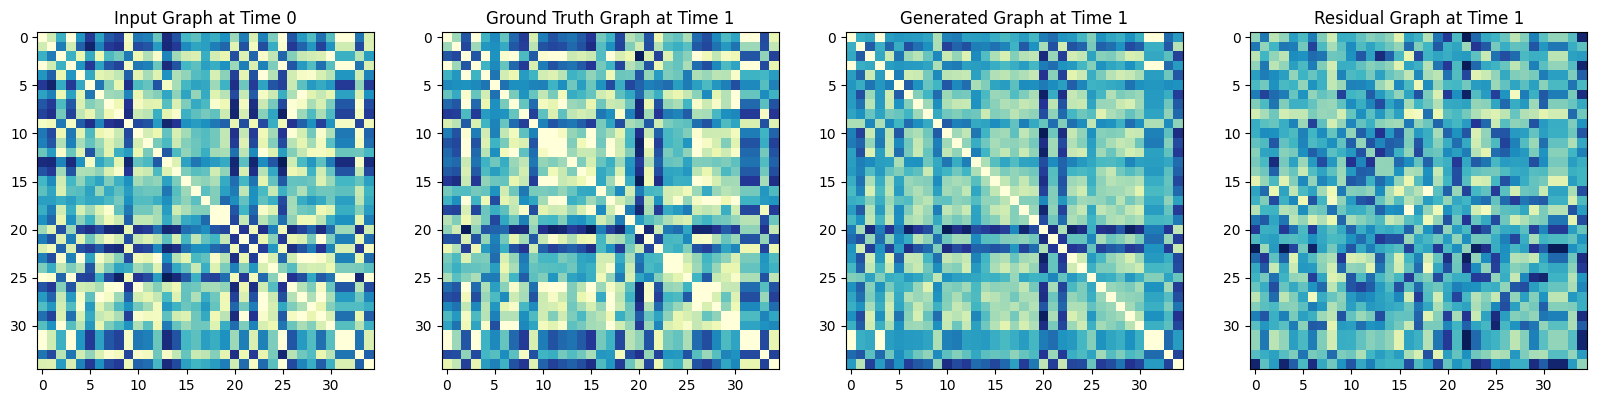

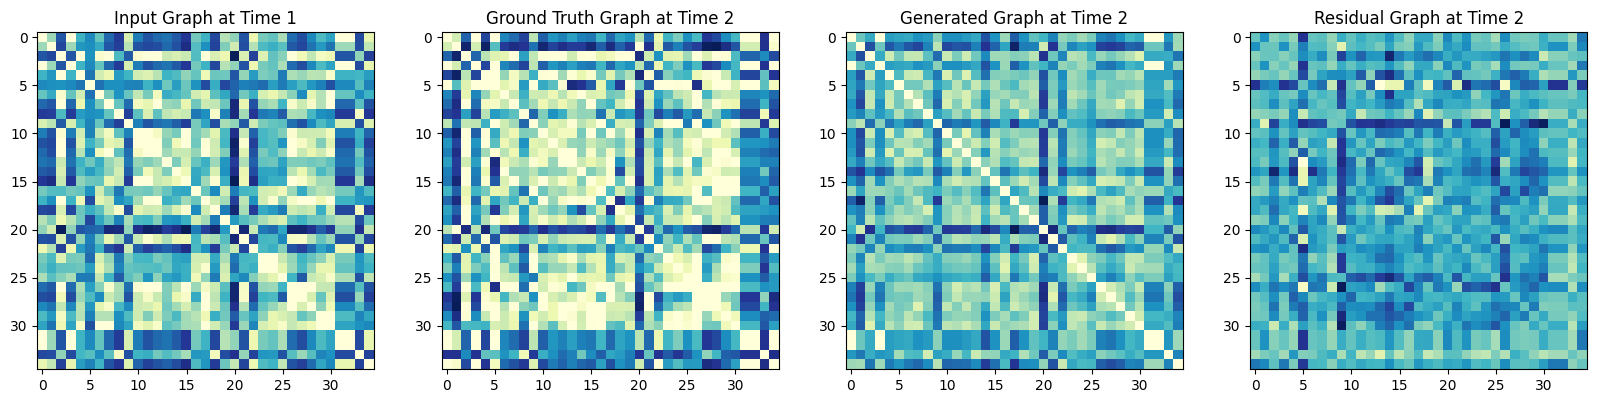

Mean Squared Error between ground truth graphs:  0.0002503937


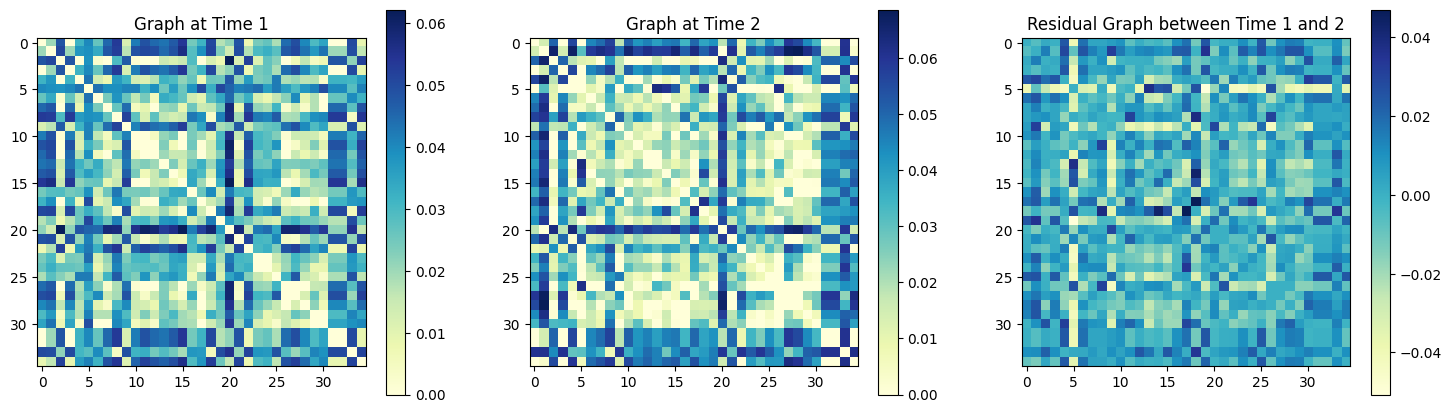

Mean Squared Error between generated graphs:  0.00011640901


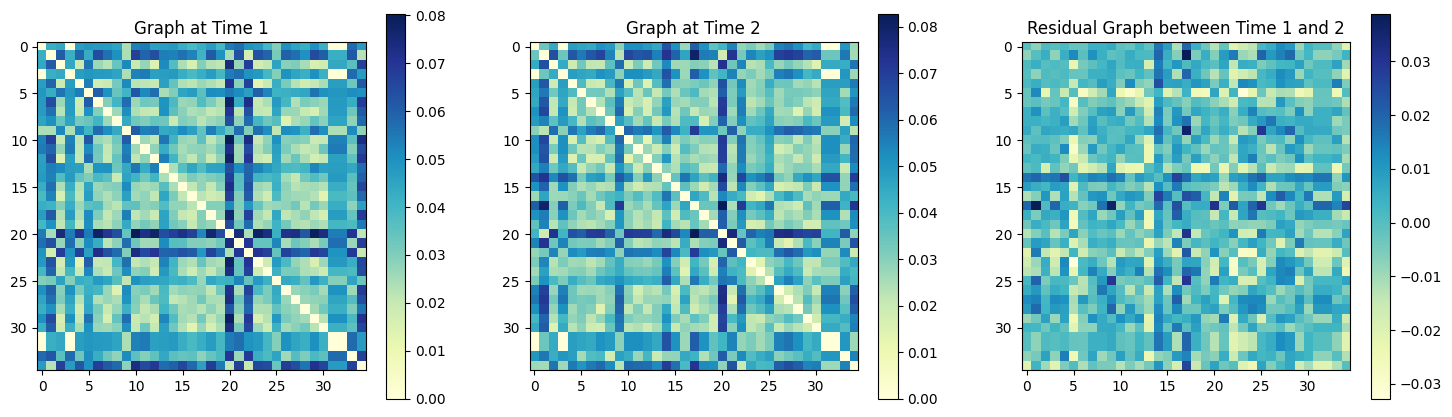

In [18]:
conv_size = adj_train_domain_1.shape[2]
hidden_size = conv_size*conv_size
model_1 = RBGM(conv_size, hidden_size).to(device)
model_2 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom1_path = 'models/RBGM/rbgm_simulated_dom1'

# evaluation
set_seed(42)
model_1.eval()
model_2.eval()
mae_1, pcc_1, js_dis_1, avg_mae_bc_1, avg_mae_ec_1, avg_mae_pc_1 = evaluate_rgbm(model_1, model_2, adj_test_domain_1.to(device))

# inference
inference_rgbm(model_1, model_2, rbgm_simulated_dom1_path, adj_test_domain_1.to(device), sample_idx)

#### Domain 2

MAE:  0.34303182
PCC:  0.9034652350008194
Jensen-Shannon Distance:  0.1535900379694755
Average MAE betweenness centrality: 0.07144257703081233
Average MAE eigenvector centrality: 0.009923818727554922
Average MAE PageRank centrality: 0.00232136544888066


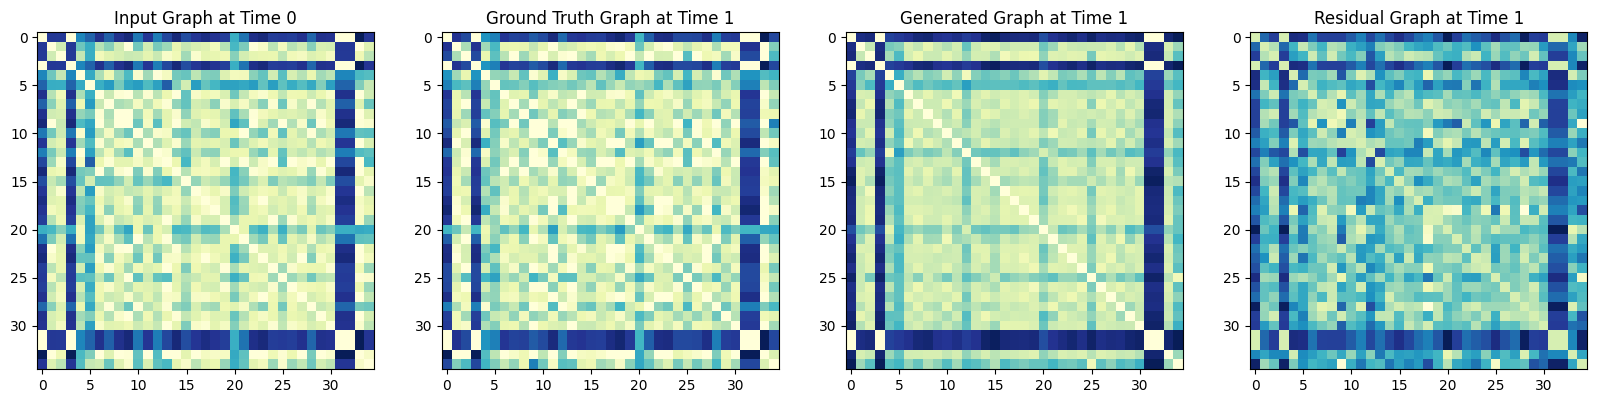

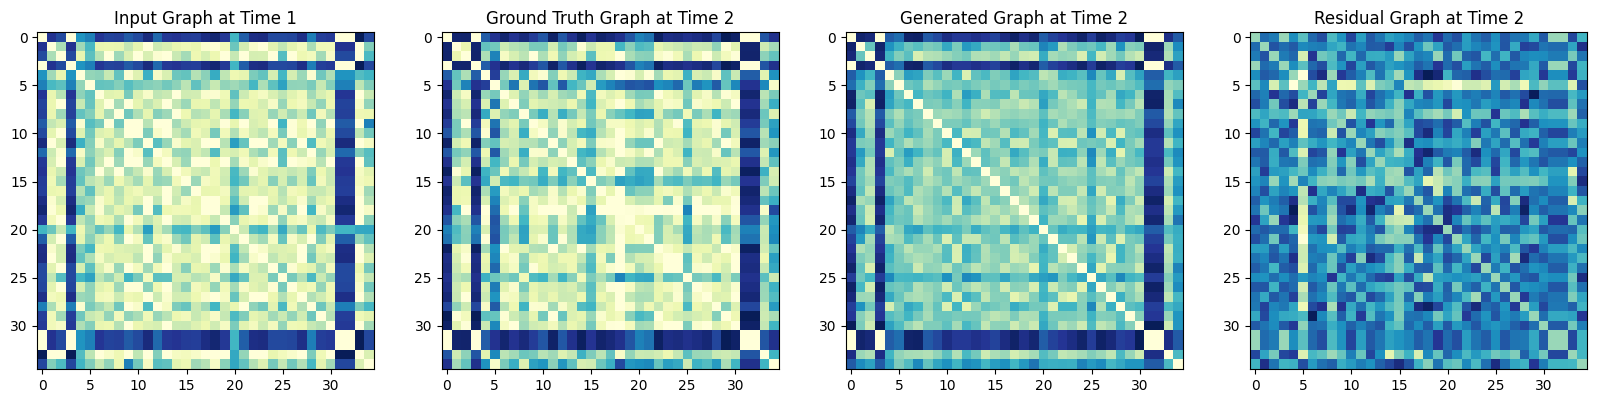

Mean Squared Error between ground truth graphs:  0.00012815003


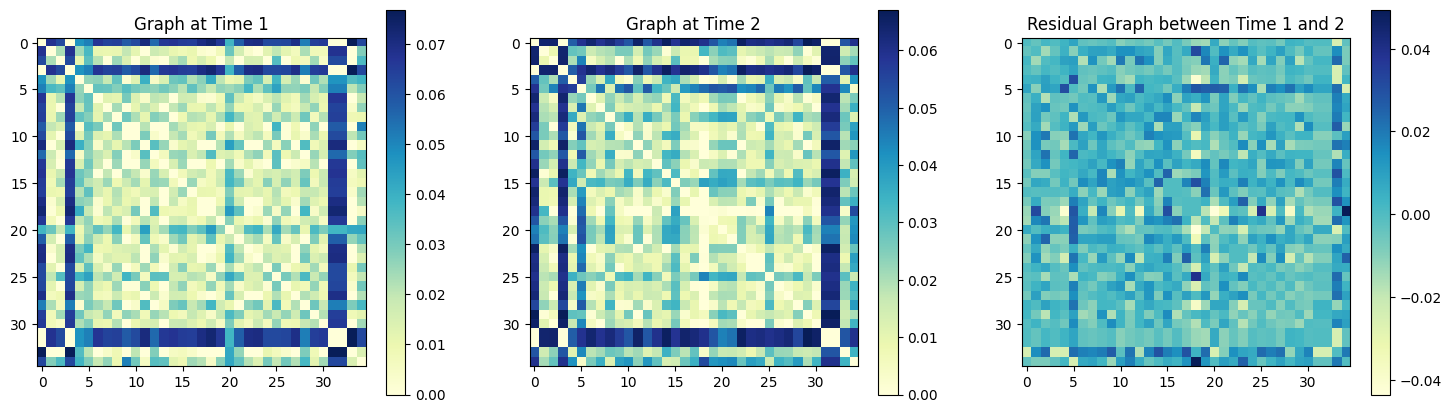

Mean Squared Error between generated graphs:  0.00017555489


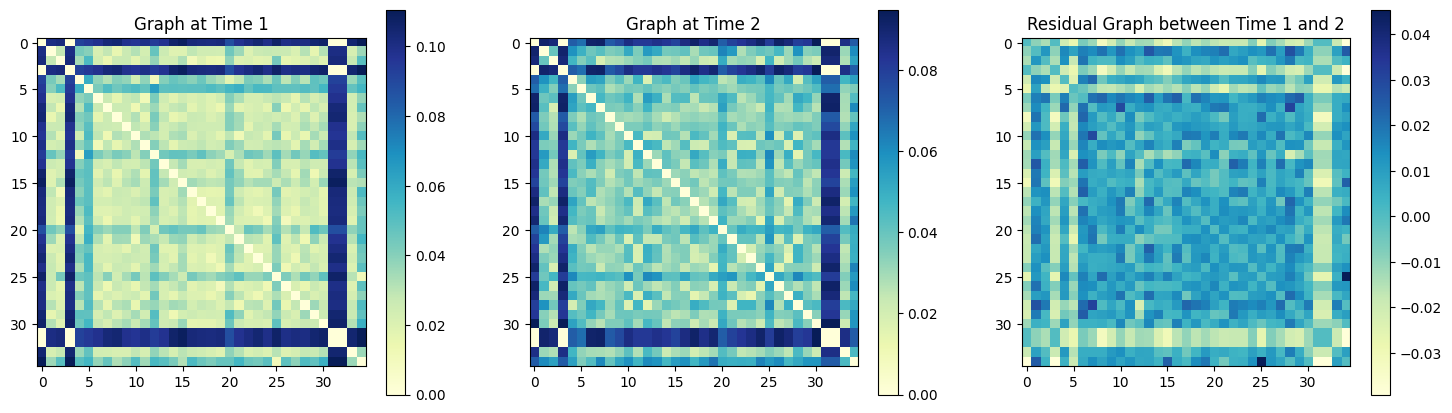

In [19]:
conv_size = adj_train_domain_2.shape[2]
hidden_size = conv_size*conv_size
model_1 = RBGM(conv_size, hidden_size).to(device)
model_2 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom2_path = 'models/RBGM/rbgm_simulated_dom2'

# evaluation
set_seed(42)
model_1.eval()
model_2.eval()
mae_2, pcc_2, js_dis_2, avg_mae_bc_2, avg_mae_ec_2, avg_mae_pc_2 = evaluate_rgbm(model_1, model_2, adj_test_domain_2.to(device))

# inference
inference_rgbm(model_1, model_2, rbgm_simulated_dom2_path, adj_test_domain_2.to(device), sample_idx)

#### Domain 3

MAE:  0.32016677
PCC:  0.8612841867389958
Jensen-Shannon Distance:  0.13406700305667504
Average MAE betweenness centrality: 0.082277183600713
Average MAE eigenvector centrality: 0.011386558310327843
Average MAE PageRank centrality: 0.0022108251831774277


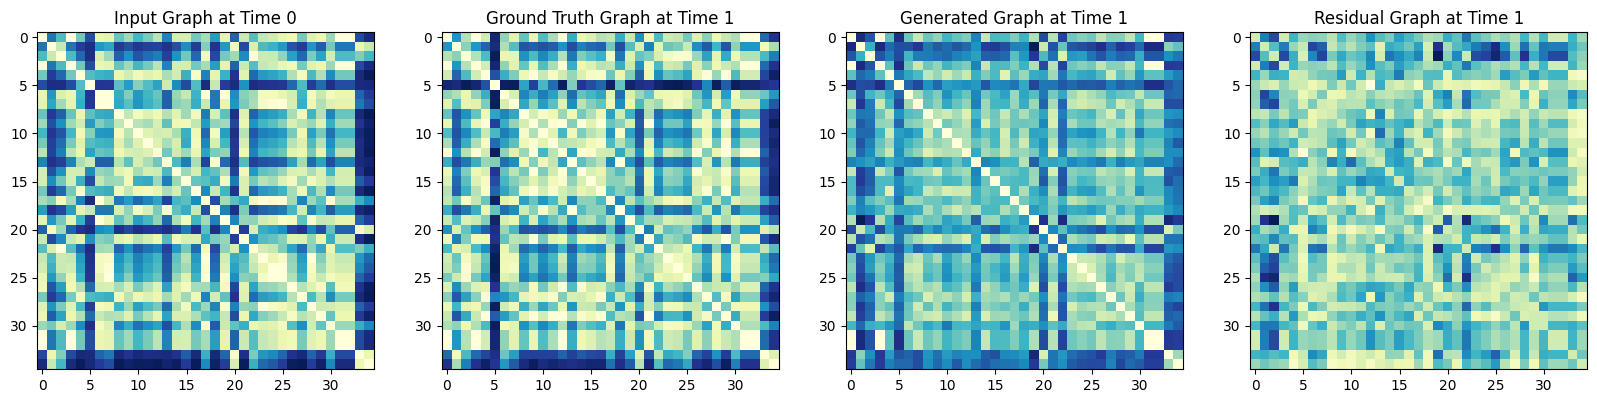

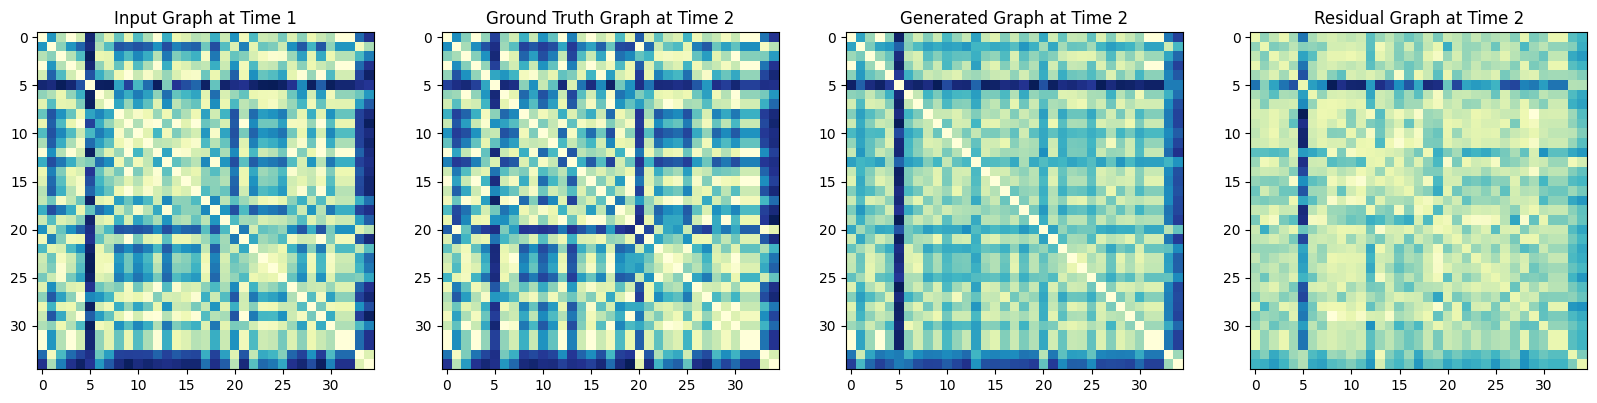

Mean Squared Error between ground truth graphs:  7.967437e-05


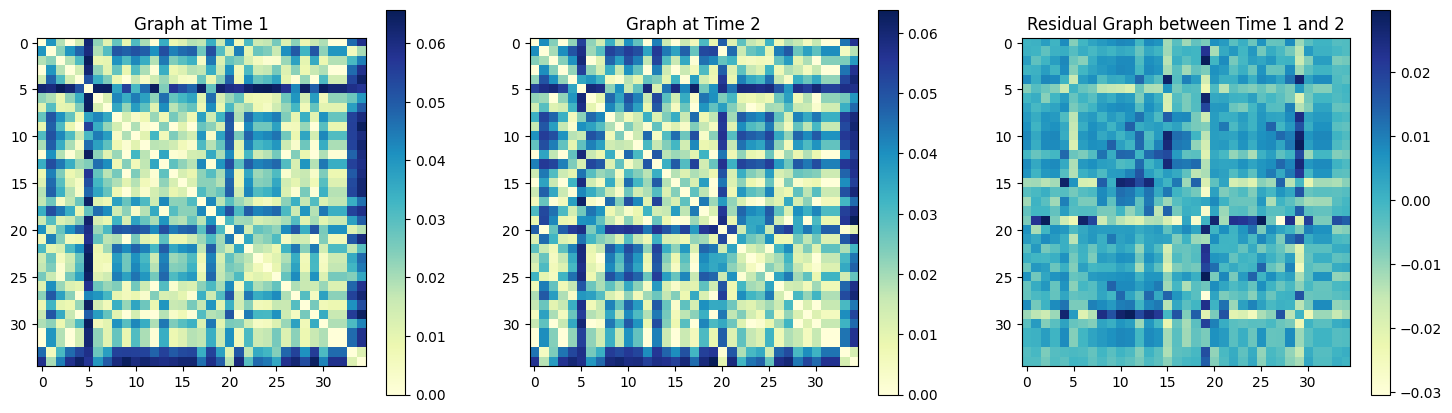

Mean Squared Error between generated graphs:  0.00021109912


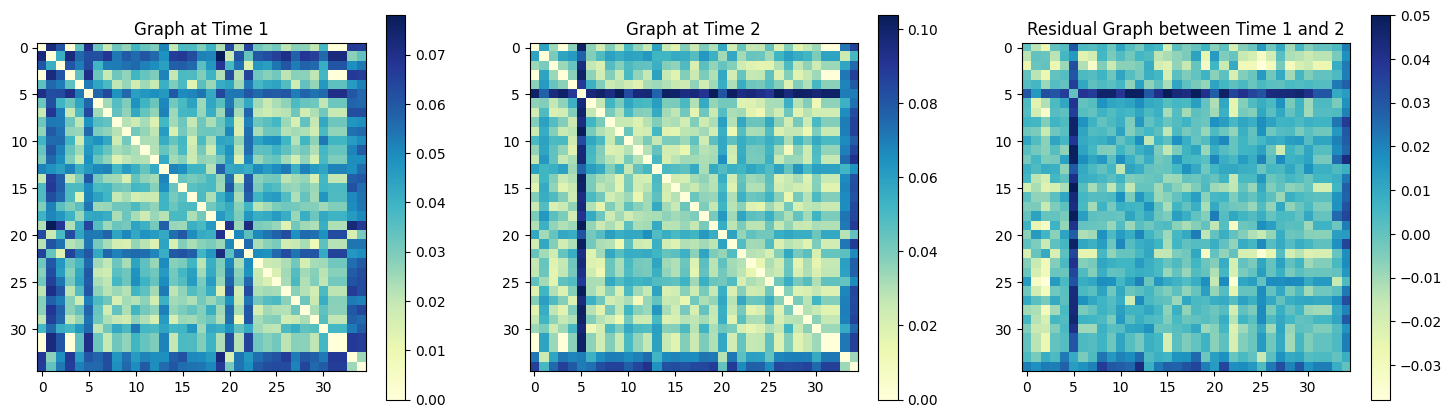

In [20]:
conv_size = adj_train_domain_3.shape[2]
hidden_size = conv_size*conv_size
model_1 = RBGM(conv_size, hidden_size).to(device)
model_2 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom3_path = 'models/RBGM/rbgm_simulated_dom3'

# evaluation
set_seed(42)
model_1.eval()
model_2.eval()
mae_3, pcc_3, js_dis_3, avg_mae_bc_3, avg_mae_ec_3, avg_mae_pc_3 = evaluate_rgbm(model_1, model_2, adj_test_domain_3.to(device))

# inference
inference_rgbm(model_1, model_2, rbgm_simulated_dom3_path, adj_test_domain_3.to(device), sample_idx)

#### Domain 4

MAE:  0.3042747
PCC:  0.8941117453588845
Jensen-Shannon Distance:  0.12061682736426847
Average MAE betweenness centrality: 0.08082123758594349
Average MAE eigenvector centrality: 0.009764529971706536
Average MAE PageRank centrality: 0.001906223469961821


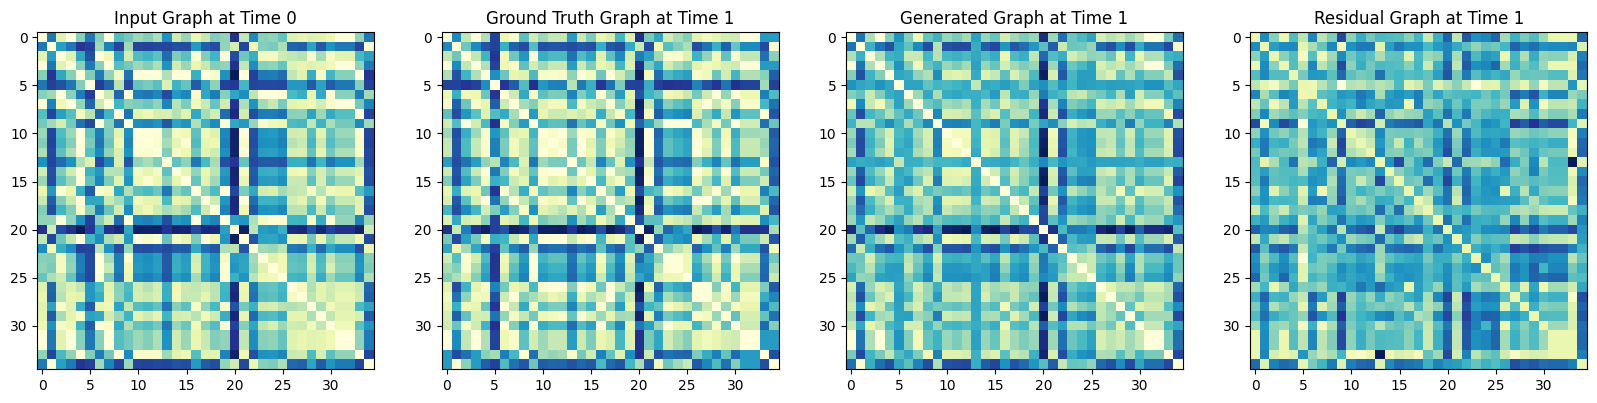

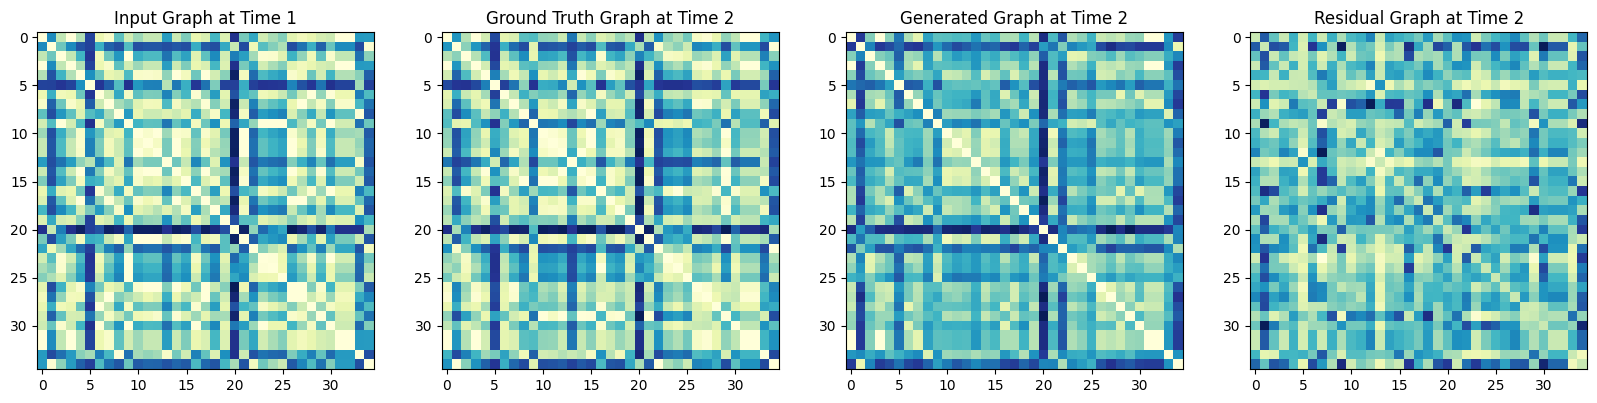

Mean Squared Error between ground truth graphs:  4.4266708e-05


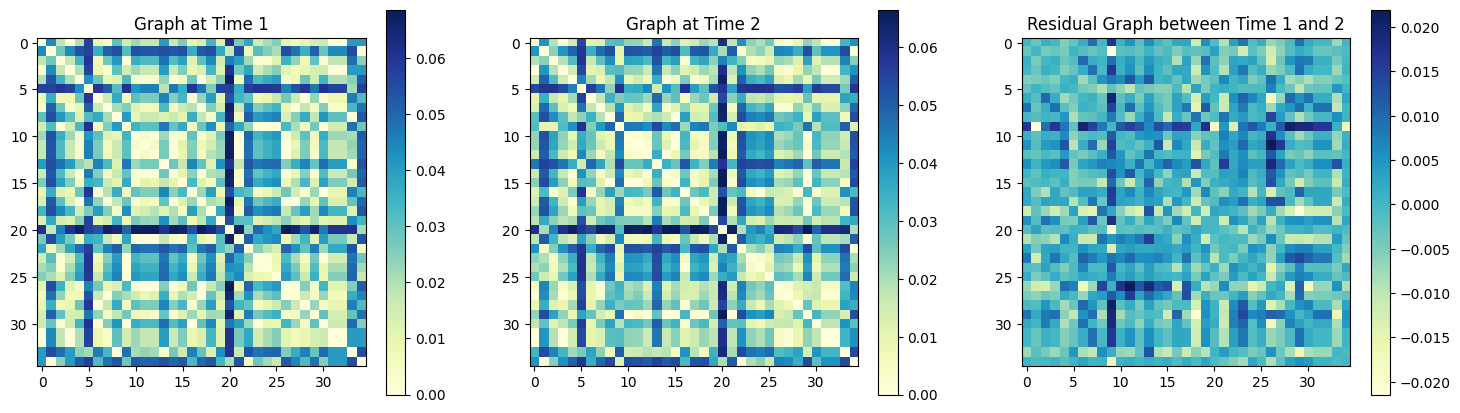

Mean Squared Error between generated graphs:  0.00020868922


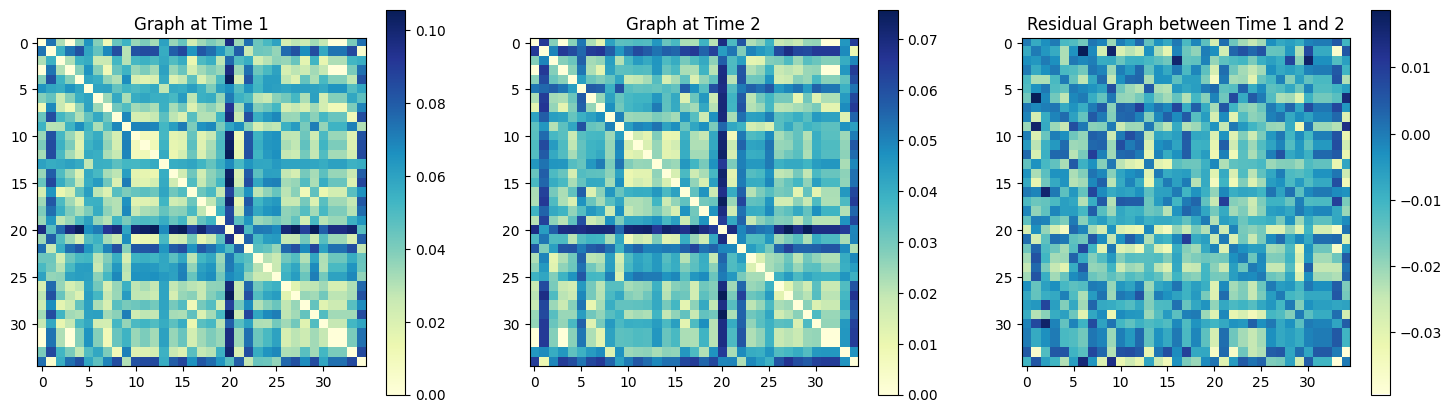

In [21]:
conv_size = adj_train_domain_4.shape[2]
hidden_size = conv_size*conv_size
model_1 = RBGM(conv_size, hidden_size).to(device)
model_2 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_dom4_path = 'models/RBGM/rbgm_simulated_dom4'

# evaluation
set_seed(42)
model_1.eval()
model_2.eval()
mae_4, pcc_4, js_dis_4, avg_mae_bc_4, avg_mae_ec_4, avg_mae_pc_4 = evaluate_rgbm(model_1, model_2, adj_test_domain_4.to(device))

# inference
inference_rgbm(model_1, model_2, rbgm_simulated_dom4_path, adj_test_domain_4.to(device), sample_idx)

## EvoGraph

In [24]:
def inference_evograph(model_1, model_2, model_path, adj, sample_idx=0):
    # Load the saved model
    model_path_1 = model_path + '_model_generator1.pth'
    model_path_2 = model_path + '_model_generator2.pth'
    model_1.load_state_dict(torch.load(model_path_1))
    model_2.load_state_dict(torch.load(model_path_2))
    model_1.eval()
    model_2.eval()


    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(adj[sample_idx, 0])
        data_t0 = Data(x=adj[sample_idx, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
        recon_adj_1  = model_1(data_t0)
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        # Generate graph at time point 2 given graph at time point 1
        edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(adj[sample_idx, 1])
        data_t1 = Data(x=adj[sample_idx, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
        recon_adj_2 = model_2(data_t1)
        residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
        plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

        residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
        mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
        print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
        plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)
        
        residual_between_outputs = recon_adj_2 - recon_adj_1
        mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
        print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
        plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def evaluate_evograph(generator_1, generator_2, adj_test):
    num_test_samples = adj_test.shape[0]
    num_roi = adj_test.shape[2]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            set_seed(42)
            
            # Predict adjacency matrix at time point t-1
            edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(adj_test[i, 0])
            data_t0 = Data(x=adj_test[i, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
            recon_adj_t_1 = generator_1(data_t0)
            pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
            adj_t_gt_1 = adj_test[i, 0]  
            gt_matrices_all.append(adj_t_gt_1.cpu().numpy())
            
            pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
            gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

            # Predict adjacency matrix at time point t-1
            edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(adj_test[i, 1])
            data_t1 = Data(x=adj_test[i, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
            recon_adj_t_2 = generator_2(data_t1)
            pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
            adj_t_gt_2 = adj_test[i, 2]  
            gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

            pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
            gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))

    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc


### Simulated Dataset

#### Domain 1

MAE:  0.52596164
PCC:  0.0677143950065383
Jensen-Shannon Distance:  0.2549985133389538
Average MAE betweenness centrality: 0.06784313725490194
Average MAE eigenvector centrality: 0.0236201892392569
Average MAE PageRank centrality: 0.004636083091208661


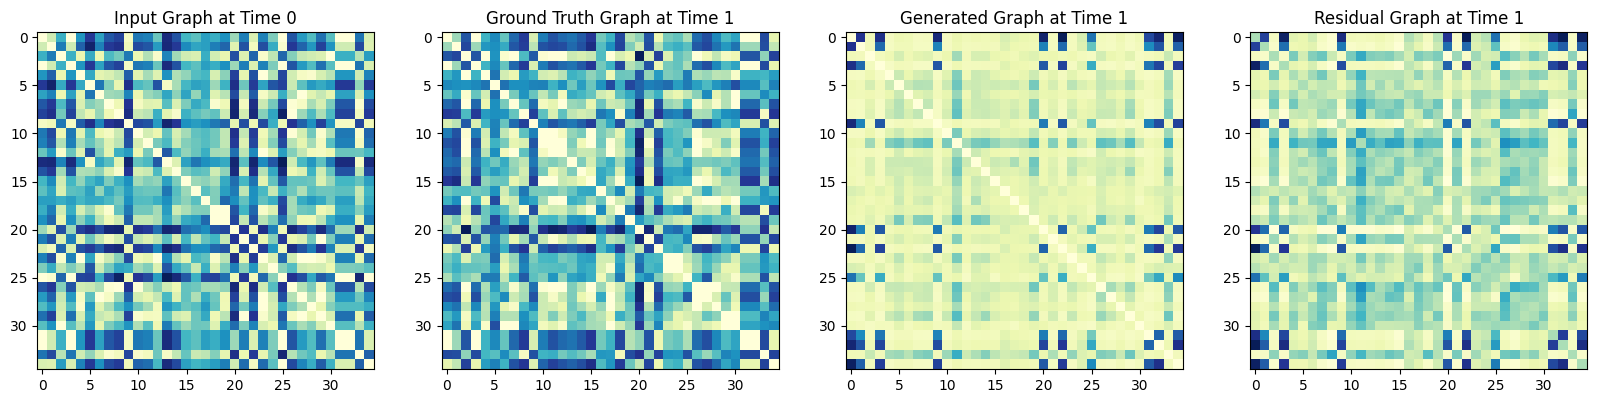

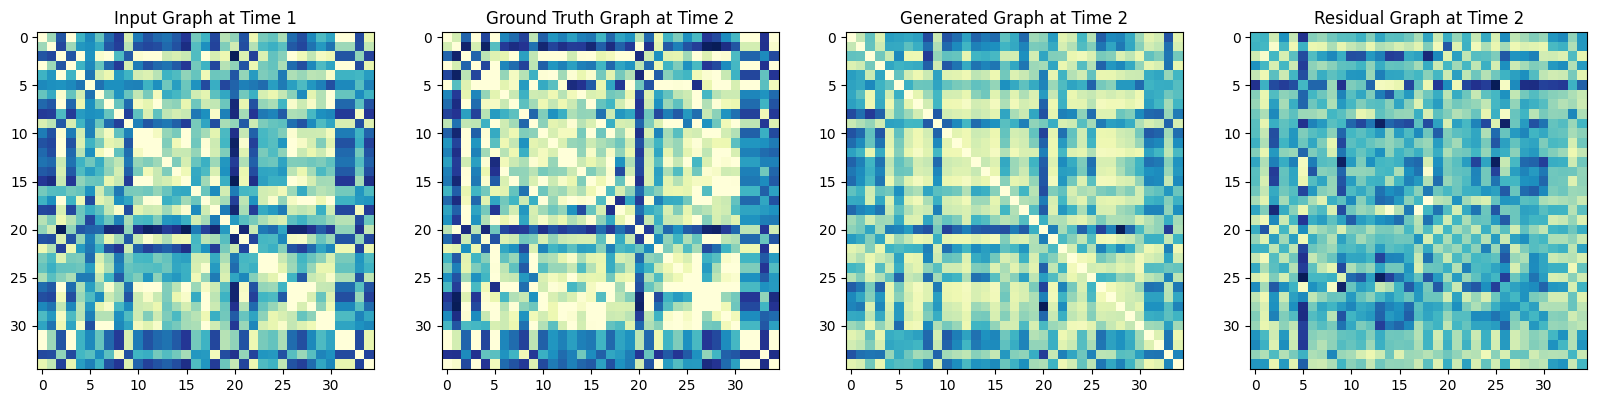

Mean Squared Error between ground truth graphs:  0.0002503937


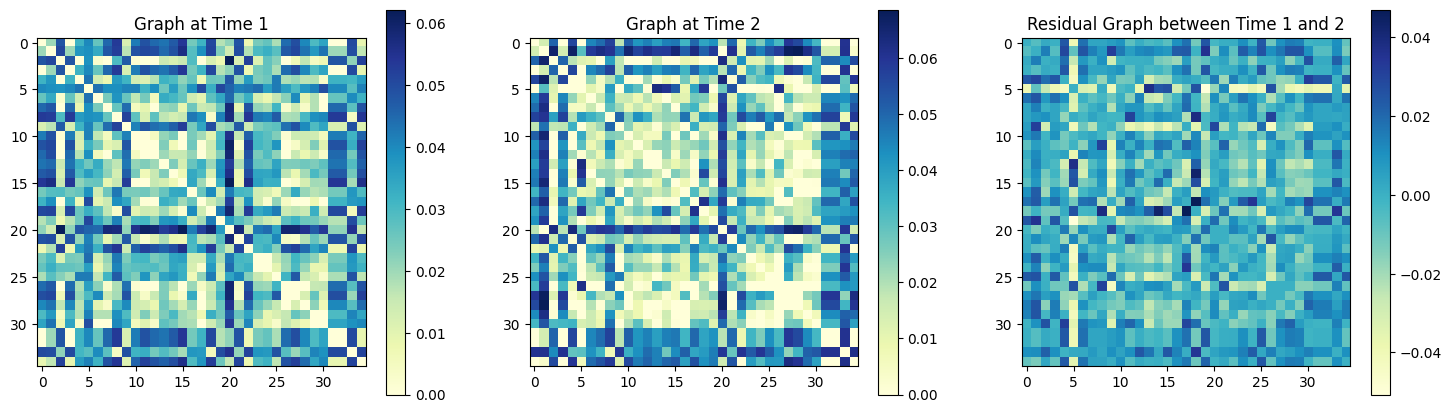

Mean Squared Error between generated graphs:  0.0007451031


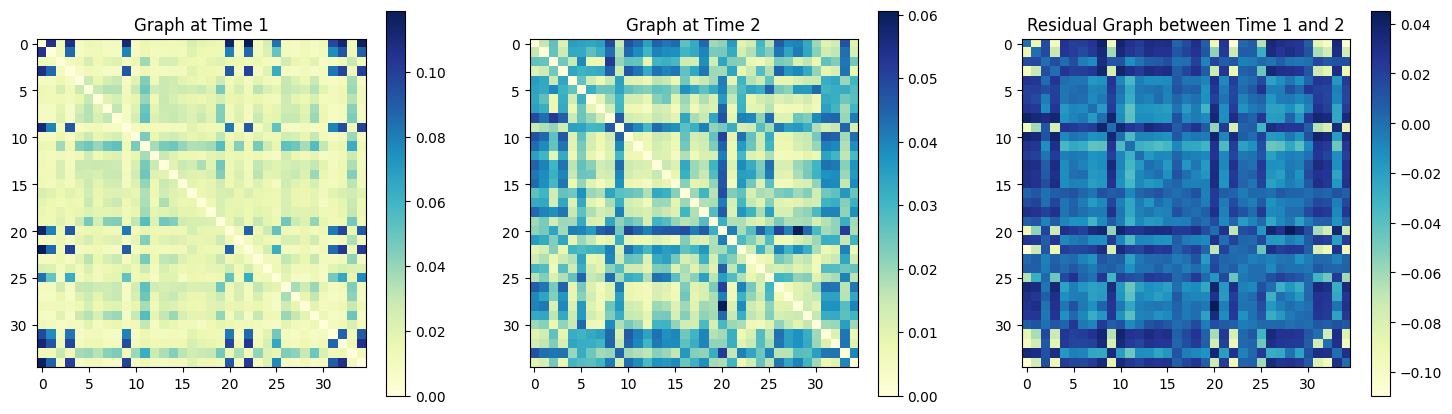

In [25]:
conv_size = adj_test_domain_1.shape[2]
hidden_size = conv_size*conv_size
sim_dom1_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom1_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
evonet_simulated_dom1_path = 'models/EVOGRAPH/evograph_simulated_dom1'

# evaluation
set_seed(42)
sim_dom1_generator1.eval()
sim_dom1_generator2.eval()
mae_1, pcc_1, js_dis_1, avg_mae_bc_1, avg_mae_ec_1, avg_mae_pc_1 = evaluate_evograph(sim_dom1_generator1, sim_dom1_generator2, adj_test_domain_1.to(device))

# inference
inference_evograph(sim_dom1_generator1, sim_dom1_generator2, evonet_simulated_dom1_path, adj_test_domain_1.to(device), sample_idx)

MAE:  0.5251712
PCC:  0.073114317060079
Jensen-Shannon Distance:  0.2950124033243931
Average MAE betweenness centrality: 0.07144512350394704
Average MAE eigenvector centrality: 0.03356575923021772
Average MAE PageRank centrality: 0.0073669767336954585


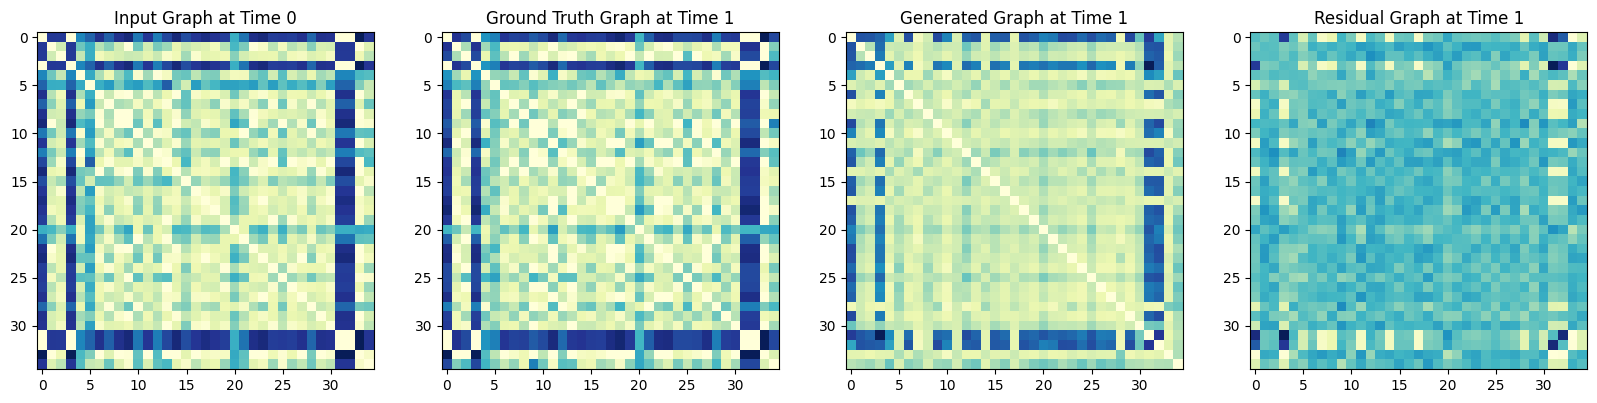

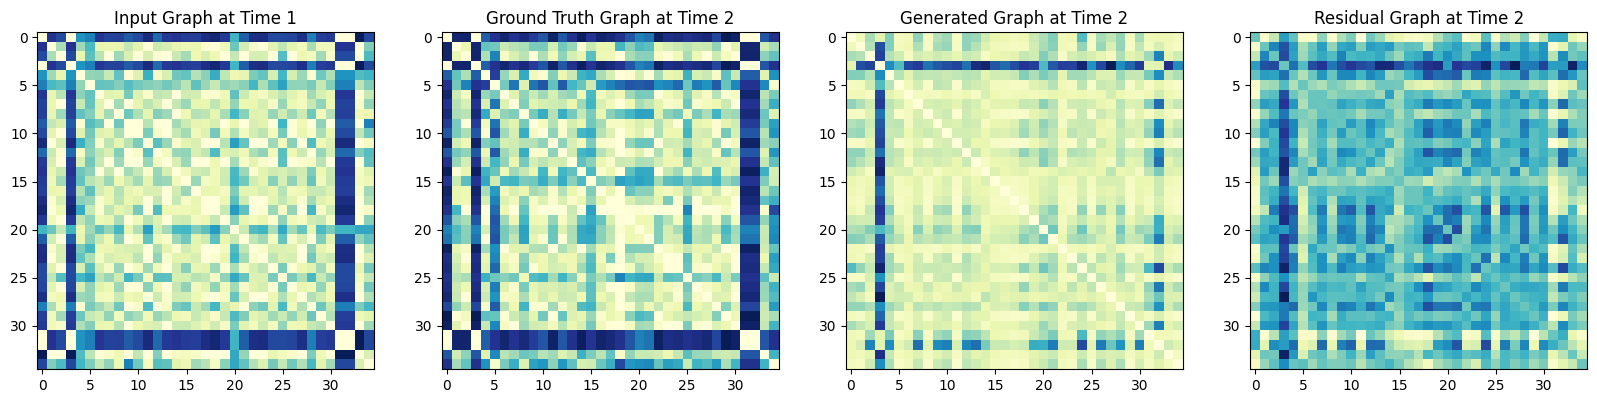

Mean Squared Error between ground truth graphs:  0.00012815003


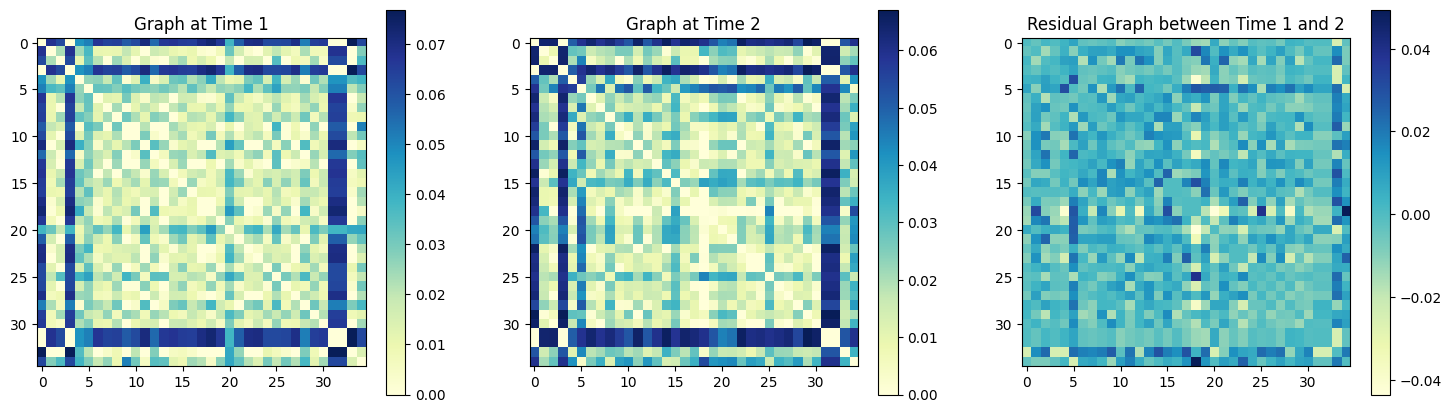

Mean Squared Error between generated graphs:  0.00063113414


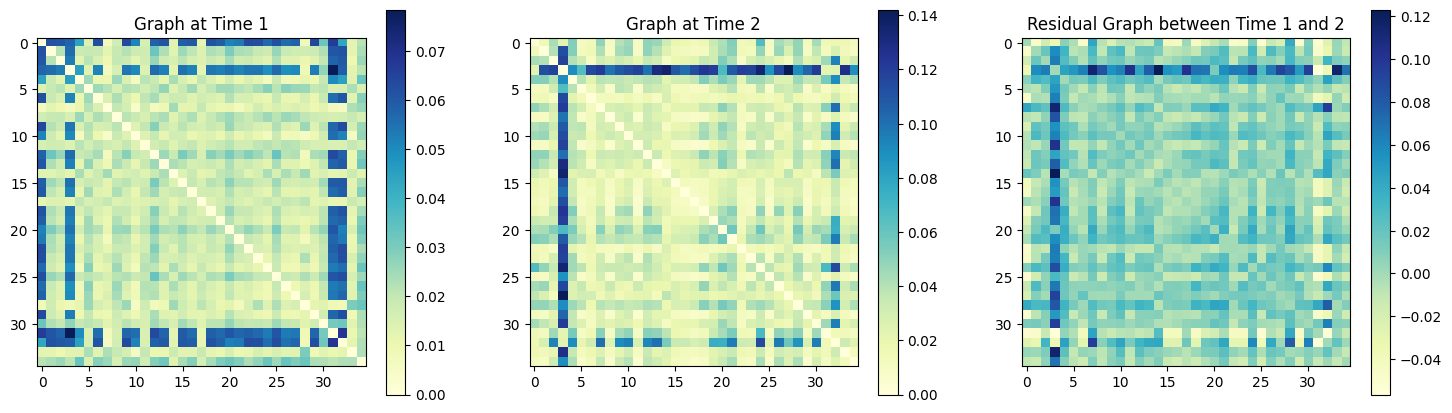

In [31]:
conv_size = adj_test_domain_2.shape[2]
hidden_size = conv_size*conv_size
sim_dom2_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom2_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
evonet_simulated_dom2_path = 'models/EVOGRAPH/evograph_simulated_dom2'

# evaluation
set_seed(42)
sim_dom2_generator1.eval()
sim_dom2_generator2.eval()
mae_2, pcc_2, js_dis_2, avg_mae_bc_2, avg_mae_ec_2, avg_mae_pc_2 = evaluate_evograph(sim_dom2_generator1, sim_dom2_generator2, adj_test_domain_2.to(device))

# inference
inference_evograph(sim_dom2_generator1, sim_dom2_generator2, evonet_simulated_dom2_path, adj_test_domain_2.to(device), sample_idx)

MAE:  0.5262529
PCC:  0.08287658177450608
Jensen-Shannon Distance:  0.2462404812749729
Average MAE betweenness centrality: 0.08227782021899668
Average MAE eigenvector centrality: 0.027947079388794177
Average MAE PageRank centrality: 0.005506380399215673


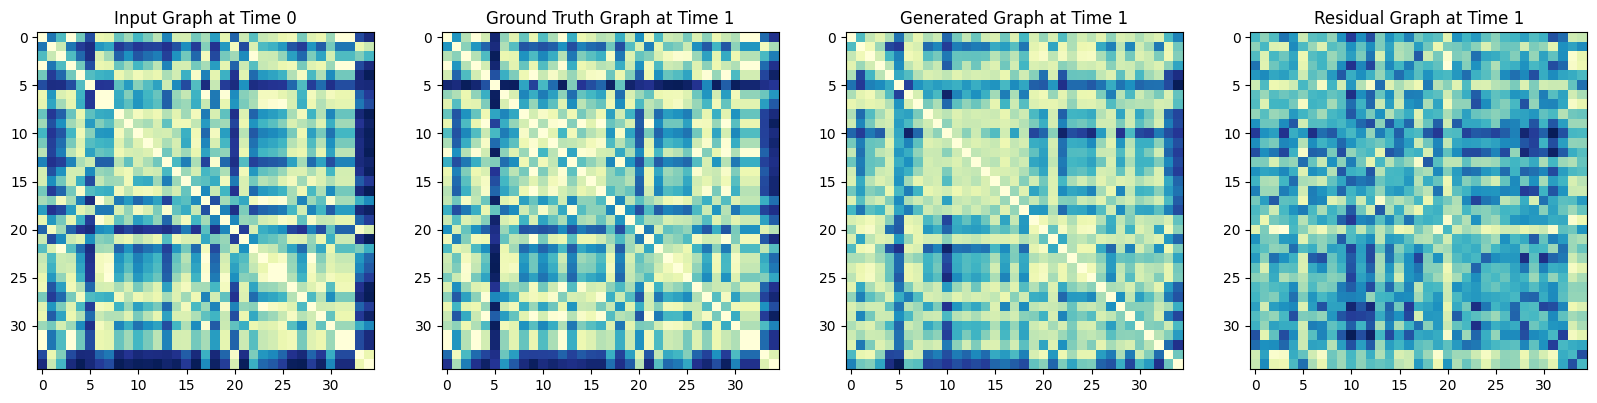

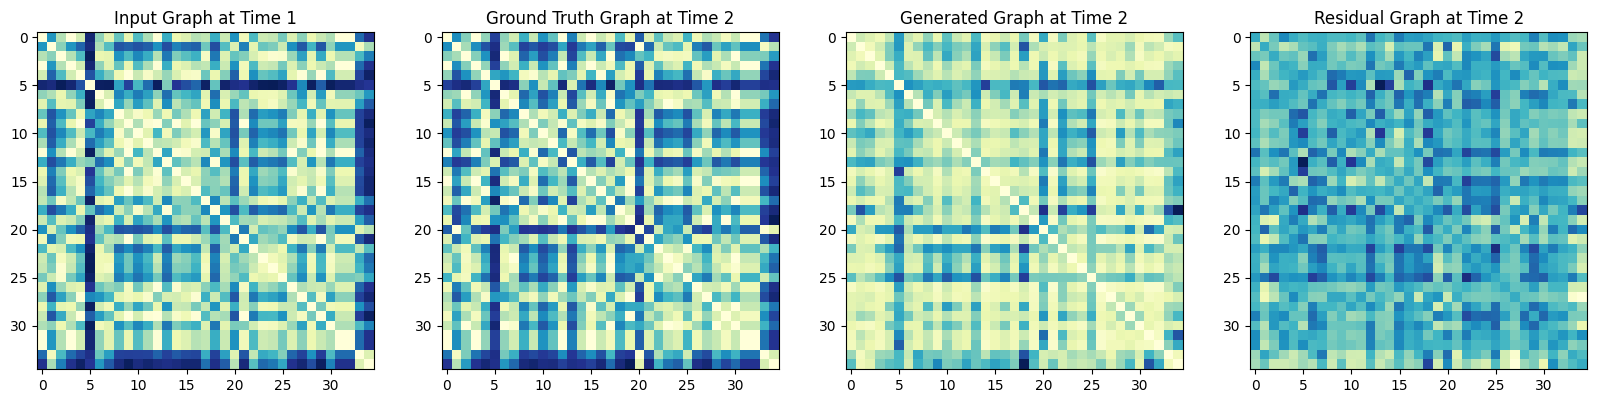

Mean Squared Error between ground truth graphs:  7.967437e-05


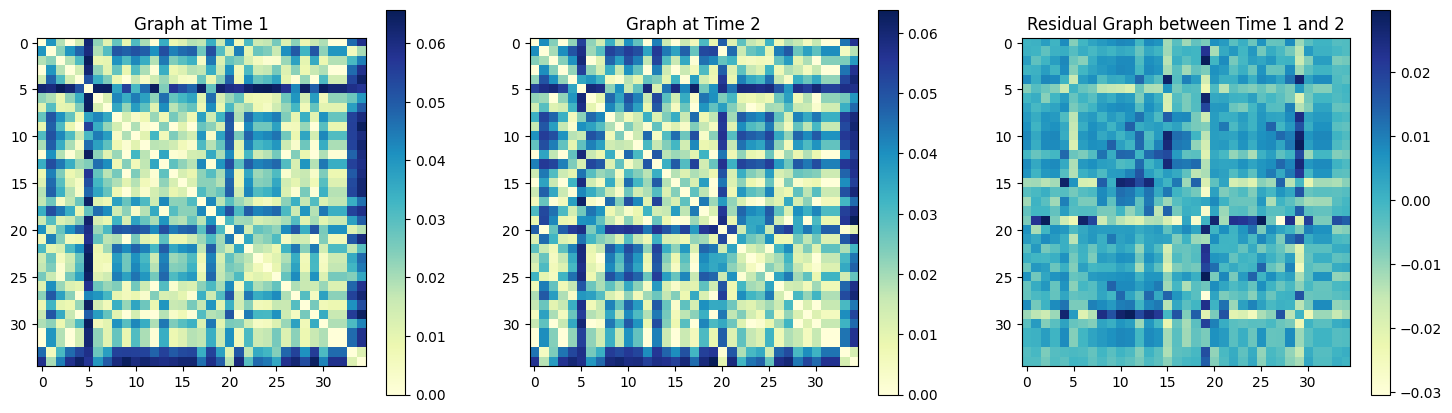

Mean Squared Error between generated graphs:  0.00015635221


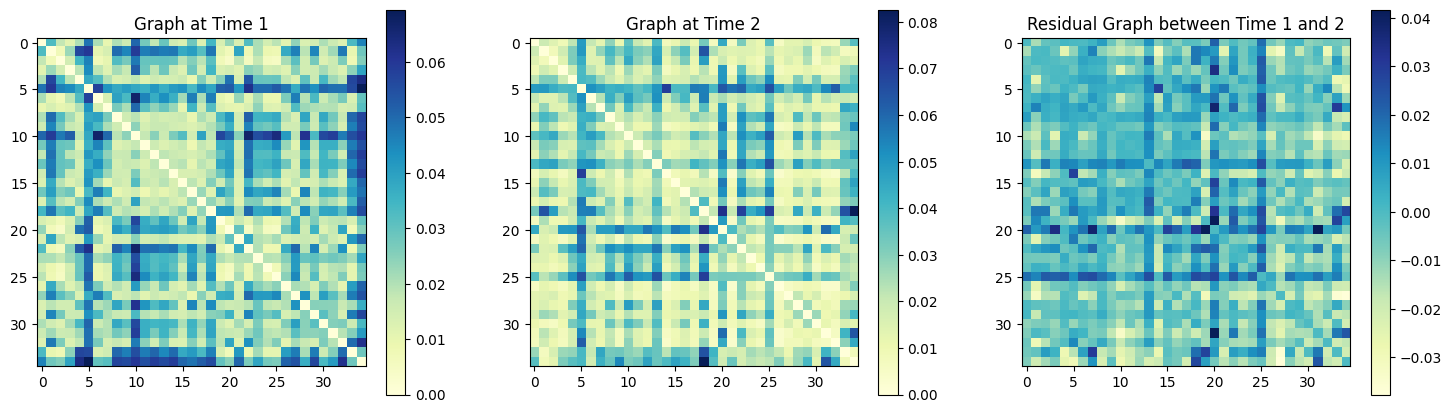

In [32]:
conv_size = adj_test_domain_3.shape[2]
hidden_size = conv_size*conv_size
sim_dom3_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom3_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
evonet_simulated_dom3_path = 'models/EVOGRAPH/evograph_simulated_dom3'

# evaluation
set_seed(42)
sim_dom3_generator1.eval()
sim_dom3_generator2.eval()
mae_3, pcc_3, js_dis_3, avg_mae_bc_3, avg_mae_ec_3, avg_mae_pc_3 = evaluate_evograph(sim_dom3_generator1, sim_dom3_generator2, adj_test_domain_3.to(device))

# inference
inference_evograph(sim_dom3_generator1, sim_dom3_generator2, evonet_simulated_dom3_path, adj_test_domain_3.to(device), sample_idx)

MAE:  0.52609193
PCC:  0.09081394275108343
Jensen-Shannon Distance:  0.24326320909604845
Average MAE betweenness centrality: 0.08082251082251084
Average MAE eigenvector centrality: 0.027993131457724058
Average MAE PageRank centrality: 0.005464277343493698


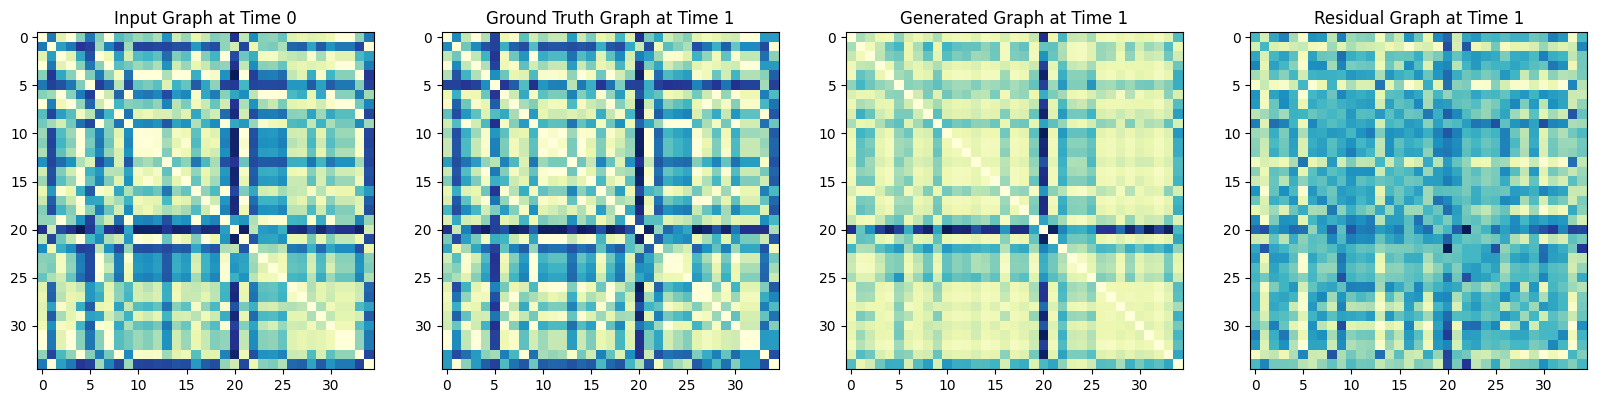

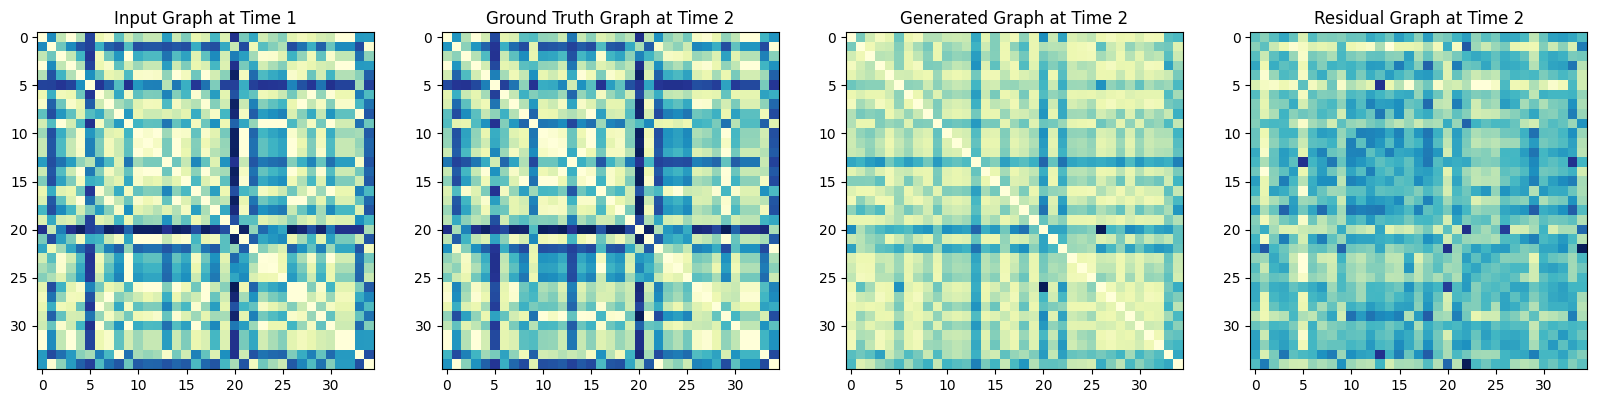

Mean Squared Error between ground truth graphs:  4.4266708e-05


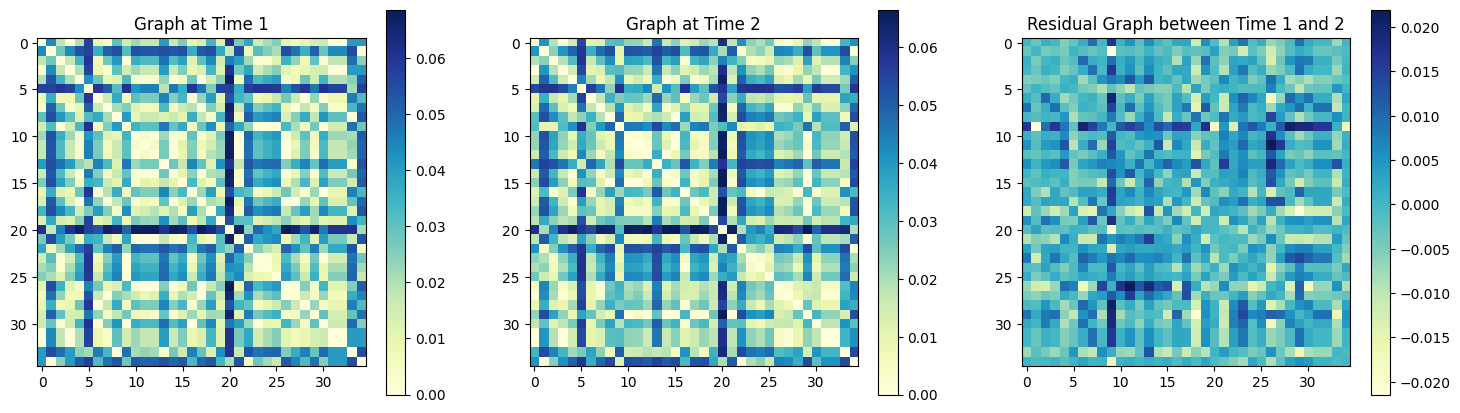

Mean Squared Error between generated graphs:  0.0001242394


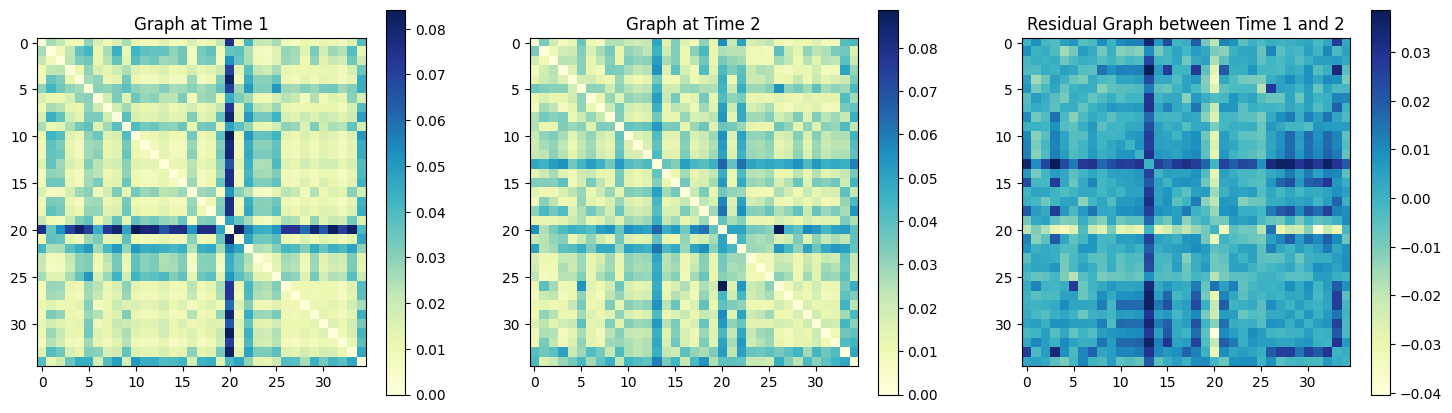

In [33]:
conv_size = adj_test_domain_4.shape[2]
hidden_size = conv_size*conv_size
sim_dom4_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
sim_dom4_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
evonet_simulated_dom4_path = 'models/EVOGRAPH/evograph_simulated_dom4'

# evaluation
set_seed(42)
sim_dom4_generator1.eval()
sim_dom4_generator2.eval()
mae_2, pcc_2, js_dis_2, avg_mae_bc_2, avg_mae_ec_2, avg_mae_pc_2 = evaluate_evograph(sim_dom4_generator1, sim_dom4_generator2, adj_test_domain_4.to(device))

# inference
inference_evograph(sim_dom4_generator1, sim_dom4_generator2, evonet_simulated_dom4_path, adj_test_domain_4.to(device), sample_idx)